In [1]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim, rot_ksamp
from hyppo.tools import SIMULATIONS
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm
from hyppo.tools import * 

import sys
import os
import multiprocessing as mp
from proglearn import UncertaintyForest
from joblib import Parallel, delayed
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')
%load_ext autoreload
%autoreload 2

In [2]:
class TestStat:
    def __init__(self, uf, oob_func, n_jobs=1):
        self.uf = uf
        self.oob_func = oob_func
        self.n_jobs = n_jobs
        
    def __call__(self, X, y):
        if not hasattr(self, "leaf_indices_"):
            self.leaf_indices_ = []
            for tree, voter_indices in zip(self.uf.transformers_, self.uf.voter_indices_):
                self.leaf_indices_.append(tree.apply(X[voter_indices]))

        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=np.exp(1))
        H_YX = self._refit_apply_oob(X, y)
        return H_Y - H_YX

    def _refit_apply_oob(self, X, y):
        posteriors = np.zeros((X.shape[0], self.uf.n_classes_), dtype=np.float64)
        # posteriors = np.zeros((X.shape[0], self.uf.n_estimators, self.uf.n_classes_), dtype=np.float64)

        for tree, leaf_indices, voter_indices in zip(self.uf.transformers_, self.leaf_indices_, self.uf.voter_indices_):
        # for tree_idx, (leaf_indices, voter_indices) in enumerate(zip(self.leaf_indices_, self.uf.voter_indices_)):
            tree.tree_.value[:, :, :] = 0

            for leaf_id, yval in zip(leaf_indices, y[voter_indices]):
                tree.tree_.value[leaf_id][0, yval] += 1
                # posteriors[leaf_id,]

            proba = tree.tree_.value[leaf_indices][:, 0, :]
            normalizer = proba.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0 # solves divide by 0 error
            proba /= normalizer
            posteriors[voter_indices] += proba

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.uf.empirical_prior_

        return np.mean(self.oob_func(posteriors))


In [3]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 5
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 100

In [4]:
def _perm_stat(calc_stat, x, y):
    permy = np.random.permutation(y)
    perm_stat = calc_stat(x, permy)

    return perm_stat


def perm_test(calc_stat, X, y, reps=1000, workers=1):
    """
    Calculate the p-value via permutation
    """
    # calculate observed test statistic
    stat = calc_stat(X, y)
    
    null_dist = np.asarray([_perm_stat(calc_stat, X, y) for rep in tqdm(range(reps))])
    pvalue = ((null_dist >= stat).sum() + 1) / (reps + 1)

    # calculate null distribution
    #null_dist = np.array(
    #    Parallel(n_jobs=workers)(
    #        [delayed(_perm_stat)(calc_stat, X, y) for rep in range(reps)]
    #    )
    #)
    #pvalue = (null_dist >= stat).sum() / reps

    # correct for a p-value of 0. This is because, with bootstrapping
    # permutations, a p-value of 0 is incorrect
    #if pvalue == 0:
        #pvalue = 1 / reps

    return stat, pvalue

In [5]:
def estimate_power(sim, test):
    
    est_power = []
    for i in tqdm(SAMP_SIZES):
        print("sample size" + str(i))
        print(sim)
        #temp_power = calc_power(test, sim_type="indep", sim=sim, n=i, p=3, auto=False, noise=True)
        pvalues = []
        for _ in tqdm(range(POWER_REPS)): 
            x, y = rot_ksamp(sim, n=i, p=3, noise=True)
            X, y = k_sample_transform([x, y])
            y = y.astype(int)
            y = y.ravel()
            print(X.shape)
            print(y.shape)
            uf = UncertaintyForest(
                n_estimators=100,
                tree_construction_proportion=0.5,
                kappa=np.inf,
                honest_prior="ignore",
                max_features=0.33,
                n_jobs=-2,
            )
            uf = uf.fit(X, y)
            print('Fitted')

            ce = lambda x: entropy(x, axis=1, base=np.exp(1))
            obs_stat = TestStat(uf, ce)

            reps = 100
            stat, pvalue = perm_test(obs_stat, X, y, reps=reps, workers=-2)
            print(pvalue)
            pvalues.append(pvalue)
            with open("./type_vs_attributes_test.csv", "w") as f:
                f.write(f"Test Statistic,p-value\n{stat},{pvalue}")
        #empirical_power = (1 + (pvalues <= 0.05).sum()) / (1 + POWER_REPS) 
        num = 0
        for pval in pvalues: 
            if pval <= 0.05: 
                num += 1
        empirical_power = (1+num) / (1+POWER_REPS)
        est_power.append(empirical_power)
        
    print(est_power)
        
    
    print(sim + " done")
    np.savetxt('C:/Users/siptest/Desktop/NDD/{}_{}New_HonestSampling_100_estimators_100_reps.csv'.format(sim, "UF"),
            est_power, delimiter=',')
    
    return est_power

In [6]:
for sim_name in tqdm(SIMULATIONS.keys()): 
    power = estimate_power(sim_name, "UF")
    #if sim_name != 'linear' and sim_name != 'exponential' and sim_name != 'cubic' and sim_name != 'joint_normal' and sim_name!= 'step' and sim_name!= 'quadratic': 
        #power = estimate_power(sim_name, "UF")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

sample size100
w_shaped
(200, 4)
(200,)




  1%|▊                                                                               | 1/100 [00:37<1:02:18, 37.76s/it]

0.07
(200, 4)
(200,)




  2%|█▋                                                                                | 2/100 [01:05<56:59, 34.89s/it]

0.51
(200, 4)
(200,)




  3%|██▍                                                                               | 3/100 [01:34<53:05, 32.84s/it]

0.7
(200, 4)
(200,)




  4%|███▎                                                                              | 4/100 [02:02<50:19, 31.45s/it]

0.06
(200, 4)
(200,)




  5%|████                                                                              | 5/100 [02:30<48:28, 30.61s/it]

0.43
(200, 4)
(200,)




  6%|████▉                                                                             | 6/100 [02:59<47:02, 30.02s/it]

0.01
(200, 4)
(200,)




  7%|█████▋                                                                            | 7/100 [03:28<45:56, 29.64s/it]

0.45
(200, 4)
(200,)




  8%|██████▌                                                                           | 8/100 [03:55<44:28, 29.01s/it]

0.03
(200, 4)
(200,)




  9%|███████▍                                                                          | 9/100 [04:23<43:23, 28.61s/it]

0.14
(200, 4)
(200,)




 10%|████████                                                                         | 10/100 [04:52<43:05, 28.72s/it]

0.05
(200, 4)
(200,)




 11%|████████▉                                                                        | 11/100 [05:19<41:51, 28.22s/it]

0.04
(200, 4)
(200,)




 12%|█████████▋                                                                       | 12/100 [05:51<42:51, 29.23s/it]

0.34
(200, 4)
(200,)




 13%|██████████▌                                                                      | 13/100 [06:22<43:23, 29.92s/it]

0.87
(200, 4)
(200,)




 14%|███████████▎                                                                     | 14/100 [06:50<41:57, 29.27s/it]

0.13
(200, 4)
(200,)




 15%|████████████▏                                                                    | 15/100 [07:18<40:49, 28.82s/it]

0.52
(200, 4)
(200,)




 16%|████████████▉                                                                    | 16/100 [07:45<39:46, 28.41s/it]

0.16
(200, 4)
(200,)




 17%|█████████████▊                                                                   | 17/100 [08:12<38:36, 27.92s/it]

0.08
(200, 4)
(200,)




 18%|██████████████▌                                                                  | 18/100 [08:40<38:08, 27.90s/it]

0.12
(200, 4)
(200,)




 19%|███████████████▍                                                                 | 19/100 [09:08<37:37, 27.87s/it]

0.01
(200, 4)
(200,)




 20%|████████████████▏                                                                | 20/100 [09:36<37:20, 28.01s/it]

0.69
(200, 4)
(200,)




 21%|█████████████████                                                                | 21/100 [10:03<36:41, 27.86s/it]

0.01
(200, 4)
(200,)




 22%|█████████████████▊                                                               | 22/100 [10:31<36:06, 27.77s/it]

0.24
(200, 4)
(200,)




 23%|██████████████████▋                                                              | 23/100 [11:00<36:05, 28.12s/it]

0.67
(200, 4)
(200,)




 24%|███████████████████▍                                                             | 24/100 [11:28<35:31, 28.05s/it]

0.01
(200, 4)
(200,)




 25%|████████████████████▎                                                            | 25/100 [11:56<35:04, 28.06s/it]

0.67
(200, 4)
(200,)




 26%|█████████████████████                                                            | 26/100 [12:23<34:25, 27.91s/it]

0.7
(200, 4)
(200,)




 27%|█████████████████████▊                                                           | 27/100 [12:52<34:07, 28.05s/it]

0.22
(200, 4)
(200,)




 28%|██████████████████████▋                                                          | 28/100 [13:20<33:51, 28.22s/it]

0.46
(200, 4)
(200,)




 29%|███████████████████████▍                                                         | 29/100 [13:48<33:10, 28.03s/it]

0.01
(200, 4)
(200,)




 30%|████████████████████████▎                                                        | 30/100 [14:15<32:28, 27.84s/it]

0.01
(200, 4)
(200,)




 31%|█████████████████████████                                                        | 31/100 [14:43<31:57, 27.80s/it]

0.12
(200, 4)
(200,)




 32%|█████████████████████████▉                                                       | 32/100 [15:11<31:40, 27.95s/it]

0.73
(200, 4)
(200,)




 33%|██████████████████████████▋                                                      | 33/100 [15:41<31:43, 28.42s/it]

0.18
(200, 4)
(200,)




 34%|███████████████████████████▌                                                     | 34/100 [16:13<32:32, 29.58s/it]

0.13
(200, 4)
(200,)




 35%|████████████████████████████▎                                                    | 35/100 [16:42<31:41, 29.26s/it]

0.29
(200, 4)
(200,)




 36%|█████████████████████████████▏                                                   | 36/100 [17:10<30:50, 28.92s/it]

0.22
(200, 4)
(200,)




 37%|█████████████████████████████▉                                                   | 37/100 [17:36<29:31, 28.12s/it]

0.45
(200, 4)
(200,)




 38%|██████████████████████████████▊                                                  | 38/100 [18:02<28:19, 27.42s/it]

0.01
(200, 4)
(200,)




 39%|███████████████████████████████▌                                                 | 39/100 [18:29<27:39, 27.20s/it]

0.08
(200, 4)
(200,)




 40%|████████████████████████████████▍                                                | 40/100 [18:58<27:50, 27.83s/it]

0.48
(200, 4)
(200,)




 41%|█████████████████████████████████▏                                               | 41/100 [19:27<27:46, 28.25s/it]

0.49
(200, 4)
(200,)




 42%|██████████████████████████████████                                               | 42/100 [19:57<27:47, 28.75s/it]

0.78
(200, 4)
(200,)




 43%|██████████████████████████████████▊                                              | 43/100 [20:25<27:03, 28.49s/it]

0.02
(200, 4)
(200,)




 44%|███████████████████████████████████▋                                             | 44/100 [20:53<26:23, 28.28s/it]

0.02
(200, 4)
(200,)




 45%|████████████████████████████████████▍                                            | 45/100 [21:20<25:47, 28.14s/it]

0.01
(200, 4)
(200,)




 46%|█████████████████████████████████████▎                                           | 46/100 [21:48<25:06, 27.91s/it]

0.01
(200, 4)
(200,)




 47%|██████████████████████████████████████                                           | 47/100 [22:16<24:46, 28.04s/it]

0.5
(200, 4)
(200,)




 48%|██████████████████████████████████████▉                                          | 48/100 [22:44<24:11, 27.92s/it]

0.49
(200, 4)
(200,)




 49%|███████████████████████████████████████▋                                         | 49/100 [23:12<23:44, 27.93s/it]

0.17
(200, 4)
(200,)




 50%|████████████████████████████████████████▌                                        | 50/100 [23:39<23:09, 27.79s/it]

0.34
(200, 4)
(200,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [24:07<22:40, 27.77s/it]

0.33
(200, 4)
(200,)




 52%|██████████████████████████████████████████                                       | 52/100 [24:36<22:24, 28.01s/it]

0.01
(200, 4)
(200,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [25:04<21:56, 28.00s/it]

0.02
(200, 4)
(200,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [25:32<21:39, 28.24s/it]

0.57
(200, 4)
(200,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [26:05<22:12, 29.61s/it]

0.7
(200, 4)
(200,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [26:34<21:30, 29.33s/it]

0.27
(200, 4)
(200,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [27:03<20:55, 29.20s/it]

0.58
(200, 4)
(200,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [27:30<20:06, 28.73s/it]

0.06
(200, 4)
(200,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [27:59<19:31, 28.57s/it]

0.15
(200, 4)
(200,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [28:27<18:57, 28.45s/it]

0.18
(200, 4)
(200,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [28:55<18:24, 28.32s/it]

0.08
(200, 4)
(200,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [29:23<18:00, 28.43s/it]

0.1
(200, 4)
(200,)




 63%|███████████████████████████████████████████████████                              | 63/100 [29:52<17:31, 28.43s/it]

0.1
(200, 4)
(200,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [30:19<16:53, 28.16s/it]

0.02
(200, 4)
(200,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [30:46<16:05, 27.58s/it]

0.03
(200, 4)
(200,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [31:12<15:25, 27.21s/it]

0.08
(200, 4)
(200,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [31:40<15:10, 27.61s/it]

0.59
(200, 4)
(200,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [32:09<14:54, 27.97s/it]

0.3
(200, 4)
(200,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [32:37<14:25, 27.93s/it]

0.16
(200, 4)
(200,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [33:05<13:58, 27.95s/it]

0.01
(200, 4)
(200,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [33:33<13:33, 28.05s/it]

0.54
(200, 4)
(200,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [34:02<13:09, 28.20s/it]

0.16
(200, 4)
(200,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [34:31<12:46, 28.40s/it]

0.6
(200, 4)
(200,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [34:59<12:13, 28.20s/it]

0.02
(200, 4)
(200,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [35:28<11:54, 28.58s/it]

0.54
(200, 4)
(200,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [36:04<12:22, 30.95s/it]

0.38
(200, 4)
(200,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [36:32<11:30, 30.04s/it]

0.3
(200, 4)
(200,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [37:00<10:47, 29.43s/it]

0.21
(200, 4)
(200,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [37:29<10:10, 29.07s/it]

0.02
(200, 4)
(200,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [37:57<09:34, 28.72s/it]

0.64
(200, 4)
(200,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [38:24<08:58, 28.35s/it]

0.02
(200, 4)
(200,)




 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [38:52<08:30, 28.36s/it]

0.32
(200, 4)
(200,)




 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [39:21<08:00, 28.29s/it]

0.5
(200, 4)
(200,)




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [39:49<07:31, 28.21s/it]

0.12
(200, 4)
(200,)




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [40:17<07:02, 28.17s/it]

0.26
(200, 4)
(200,)




 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [40:45<06:37, 28.38s/it]

0.39
(200, 4)
(200,)




 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [41:15<06:11, 28.58s/it]

0.6
(200, 4)
(200,)




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [41:43<05:41, 28.42s/it]

0.33
(200, 4)
(200,)




 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [42:11<05:11, 28.35s/it]

0.16
(200, 4)
(200,)




 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [42:36<04:35, 27.52s/it]

0.02
(200, 4)
(200,)




 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [43:03<04:05, 27.25s/it]

0.07
(200, 4)
(200,)




 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [43:30<03:37, 27.24s/it]

0.26
(200, 4)
(200,)




 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [43:58<03:12, 27.52s/it]

0.41
(200, 4)
(200,)




 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [44:26<02:46, 27.67s/it]

0.1
(200, 4)
(200,)




 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [44:56<02:20, 28.19s/it]

0.59
(200, 4)
(200,)




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [45:23<01:51, 27.87s/it]

0.01
(200, 4)
(200,)




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [45:53<01:25, 28.57s/it]

0.3
(200, 4)
(200,)




 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [46:19<00:55, 27.77s/it]

0.05
(200, 4)
(200,)




 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [46:48<00:28, 28.00s/it]

0.38
(200, 4)
(200,)




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [47:15<00:00, 28.36s/it]

 20%|████████████████                                                                | 1/5 [47:15<3:09:03, 2835.89s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.02
sample size150
w_shaped
(300, 4)
(300,)




  1%|▊                                                                                 | 1/100 [00:35<58:01, 35.17s/it]

0.13
(300, 4)
(300,)




  2%|█▋                                                                                | 2/100 [01:10<57:32, 35.23s/it]

0.03
(300, 4)
(300,)




  3%|██▍                                                                               | 3/100 [01:46<57:28, 35.56s/it]

0.06
(300, 4)
(300,)




  4%|███▎                                                                              | 4/100 [02:22<56:55, 35.58s/it]

0.54
(300, 4)
(300,)




  5%|████                                                                              | 5/100 [02:59<56:51, 35.91s/it]

0.01
(300, 4)
(300,)




  6%|████▉                                                                             | 6/100 [03:35<56:36, 36.13s/it]

0.04
(300, 4)
(300,)




  7%|█████▋                                                                            | 7/100 [04:11<55:56, 36.09s/it]

0.23
(300, 4)
(300,)




  8%|██████▌                                                                           | 8/100 [04:45<54:16, 35.40s/it]

0.01
(300, 4)
(300,)




  9%|███████▍                                                                          | 9/100 [05:21<53:43, 35.42s/it]

0.18
(300, 4)
(300,)




 10%|████████                                                                         | 10/100 [05:57<53:44, 35.83s/it]

0.01
(300, 4)
(300,)




 11%|████████▉                                                                        | 11/100 [06:34<53:41, 36.19s/it]

0.09
(300, 4)
(300,)




 12%|█████████▋                                                                       | 12/100 [07:11<53:07, 36.22s/it]

0.07
(300, 4)
(300,)




 13%|██████████▌                                                                      | 13/100 [07:46<52:18, 36.07s/it]

0.04
(300, 4)
(300,)




 14%|███████████▎                                                                     | 14/100 [08:23<51:52, 36.19s/it]

0.01
(300, 4)
(300,)




 15%|████████████▏                                                                    | 15/100 [09:04<53:24, 37.70s/it]

0.87
(300, 4)
(300,)




 16%|████████████▉                                                                    | 16/100 [09:45<54:03, 38.62s/it]

0.2
(300, 4)
(300,)




 17%|█████████████▊                                                                   | 17/100 [10:21<52:17, 37.80s/it]

0.01
(300, 4)
(300,)




 18%|██████████████▌                                                                  | 18/100 [10:57<51:05, 37.39s/it]

0.13
(300, 4)
(300,)




 19%|███████████████▍                                                                 | 19/100 [11:33<49:58, 37.02s/it]

0.1
(300, 4)
(300,)




 20%|████████████████▏                                                                | 20/100 [12:09<48:55, 36.70s/it]

0.02
(300, 4)
(300,)




 21%|█████████████████                                                                | 21/100 [12:46<48:11, 36.60s/it]

0.48
(300, 4)
(300,)




 22%|█████████████████▊                                                               | 22/100 [13:21<46:57, 36.12s/it]

0.27
(300, 4)
(300,)




 23%|██████████████████▋                                                              | 23/100 [13:54<45:06, 35.15s/it]

0.01
(300, 4)
(300,)




 24%|███████████████████▍                                                             | 24/100 [14:28<44:21, 35.02s/it]

0.01
(300, 4)
(300,)




 25%|████████████████████▎                                                            | 25/100 [15:03<43:46, 35.02s/it]

0.01
(300, 4)
(300,)




 26%|█████████████████████                                                            | 26/100 [15:39<43:22, 35.16s/it]

0.21
(300, 4)
(300,)




 27%|█████████████████████▊                                                           | 27/100 [16:14<42:41, 35.09s/it]

0.52
(300, 4)
(300,)




 28%|██████████████████████▋                                                          | 28/100 [16:48<41:47, 34.83s/it]

0.17
(300, 4)
(300,)




 29%|███████████████████████▍                                                         | 29/100 [17:22<40:56, 34.60s/it]

0.04
(300, 4)
(300,)




 30%|████████████████████████▎                                                        | 30/100 [17:58<40:48, 34.98s/it]

0.03
(300, 4)
(300,)




 31%|█████████████████████████                                                        | 31/100 [18:39<42:17, 36.78s/it]

0.01
(300, 4)
(300,)




 32%|█████████████████████████▉                                                       | 32/100 [19:16<41:58, 37.04s/it]

0.11
(300, 4)
(300,)




 33%|██████████████████████████▋                                                      | 33/100 [19:51<40:27, 36.24s/it]

0.01
(300, 4)
(300,)




 34%|███████████████████████████▌                                                     | 34/100 [20:26<39:30, 35.92s/it]

0.01
(300, 4)
(300,)




 35%|████████████████████████████▎                                                    | 35/100 [21:01<38:42, 35.72s/it]

0.03
(300, 4)
(300,)




 36%|█████████████████████████████▏                                                   | 36/100 [21:38<38:19, 35.92s/it]

0.01
(300, 4)
(300,)




 37%|█████████████████████████████▉                                                   | 37/100 [22:14<37:44, 35.94s/it]

0.08
(300, 4)
(300,)




 38%|██████████████████████████████▊                                                  | 38/100 [22:50<37:06, 35.92s/it]

0.4
(300, 4)
(300,)




 39%|███████████████████████████████▌                                                 | 39/100 [23:26<36:40, 36.07s/it]

0.64
(300, 4)
(300,)




 40%|████████████████████████████████▍                                                | 40/100 [24:02<36:01, 36.03s/it]

0.06
(300, 4)
(300,)




 41%|█████████████████████████████████▏                                               | 41/100 [24:38<35:34, 36.18s/it]

0.58
(300, 4)
(300,)




 42%|██████████████████████████████████                                               | 42/100 [25:13<34:30, 35.70s/it]

0.01
(300, 4)
(300,)




 43%|██████████████████████████████████▊                                              | 43/100 [25:48<33:50, 35.63s/it]

0.09
(300, 4)
(300,)




 44%|███████████████████████████████████▋                                             | 44/100 [26:24<33:13, 35.60s/it]

0.06
(300, 4)
(300,)




 45%|████████████████████████████████████▍                                            | 45/100 [27:01<32:59, 35.99s/it]

0.76
(300, 4)
(300,)




 46%|█████████████████████████████████████▎                                           | 46/100 [27:36<32:06, 35.68s/it]

0.15
(300, 4)
(300,)




 47%|██████████████████████████████████████                                           | 47/100 [28:12<31:33, 35.72s/it]

0.27
(300, 4)
(300,)




 48%|██████████████████████████████████████▉                                          | 48/100 [28:51<31:50, 36.75s/it]

0.26
(300, 4)
(300,)




 49%|███████████████████████████████████████▋                                         | 49/100 [29:26<30:49, 36.27s/it]

0.05
(300, 4)
(300,)




 50%|████████████████████████████████████████▌                                        | 50/100 [30:02<30:12, 36.24s/it]

0.47
(300, 4)
(300,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [30:39<29:38, 36.29s/it]

0.03
(300, 4)
(300,)




 52%|██████████████████████████████████████████                                       | 52/100 [31:14<28:48, 36.01s/it]

0.01
(300, 4)
(300,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [31:50<28:18, 36.14s/it]

0.22
(300, 4)
(300,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [32:57<34:43, 45.30s/it]

0.47
(300, 4)
(300,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [33:41<33:34, 44.77s/it]

0.03
(300, 4)
(300,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [34:27<33:14, 45.33s/it]

0.03
(300, 4)
(300,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [35:03<30:28, 42.51s/it]

0.04
(300, 4)
(300,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [35:38<28:12, 40.29s/it]

0.22
(300, 4)
(300,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [36:15<26:47, 39.20s/it]

0.42
(300, 4)
(300,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [36:58<26:59, 40.48s/it]

0.41
(300, 4)
(300,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [37:41<26:42, 41.10s/it]

0.2
(300, 4)
(300,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [38:16<24:49, 39.18s/it]

0.03
(300, 4)
(300,)




 63%|███████████████████████████████████████████████████                              | 63/100 [38:55<24:09, 39.16s/it]

0.01
(300, 4)
(300,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [39:30<22:48, 38.03s/it]

0.38
(300, 4)
(300,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [40:06<21:49, 37.41s/it]

0.04
(300, 4)
(300,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [40:43<21:08, 37.31s/it]

0.06
(300, 4)
(300,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [41:18<20:05, 36.54s/it]

0.01
(300, 4)
(300,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [41:54<19:27, 36.47s/it]

0.17
(300, 4)
(300,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [42:30<18:46, 36.35s/it]

0.19
(300, 4)
(300,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [43:06<18:02, 36.09s/it]

0.02
(300, 4)
(300,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [43:41<17:19, 35.85s/it]

0.03
(300, 4)
(300,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [44:18<16:50, 36.11s/it]

0.18
(300, 4)
(300,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [44:54<16:12, 36.03s/it]

0.12
(300, 4)
(300,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [45:29<15:32, 35.85s/it]

0.02
(300, 4)
(300,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [46:05<14:55, 35.81s/it]

0.17
(300, 4)
(300,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [46:41<14:22, 35.96s/it]

0.01
(300, 4)
(300,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [47:20<14:05, 36.76s/it]

0.39
(300, 4)
(300,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [47:56<13:22, 36.49s/it]

0.01
(300, 4)
(300,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [48:32<12:43, 36.35s/it]

0.01
(300, 4)
(300,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [49:12<12:30, 37.50s/it]

0.01
(300, 4)
(300,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [49:47<11:40, 36.88s/it]

0.01
(300, 4)
(300,)




 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [50:25<11:08, 37.16s/it]

0.23
(300, 4)
(300,)




 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [51:02<10:31, 37.16s/it]

0.01
(300, 4)
(300,)




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [51:39<09:53, 37.09s/it]

0.43
(300, 4)
(300,)




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [52:16<09:14, 36.98s/it]

0.08
(300, 4)
(300,)




 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [52:53<08:37, 36.96s/it]

0.15
(300, 4)
(300,)




 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [53:30<08:02, 37.08s/it]

0.26
(300, 4)
(300,)




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [54:09<07:31, 37.59s/it]

0.27
(300, 4)
(300,)




 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [54:45<06:49, 37.19s/it]

0.01
(300, 4)
(300,)




 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [55:20<06:05, 36.56s/it]

0.02
(300, 4)
(300,)




 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [55:57<05:29, 36.63s/it]

0.1
(300, 4)
(300,)




 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [56:31<04:45, 35.73s/it]

0.14
(300, 4)
(300,)




 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [57:05<04:06, 35.20s/it]

0.03
(300, 4)
(300,)




 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [57:42<03:35, 35.85s/it]

0.34
(300, 4)
(300,)




 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [58:17<02:58, 35.65s/it]

0.01
(300, 4)
(300,)




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [58:57<02:27, 36.91s/it]

0.1
(300, 4)
(300,)




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [59:32<01:48, 36.20s/it]

0.14
(300, 4)
(300,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:00:08<01:12, 36.19s/it]

0.01
(300, 4)
(300,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:00:43<00:35, 36.00s/it]

0.04
(300, 4)
(300,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:01:19<00:00, 36.80s/it]

 40%|███████████████████████████████▏                                              | 2/5 [1:48:35<2:34:27, 3089.03s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.55
sample size200
w_shaped
(400, 4)
(400,)




  1%|▊                                                                               | 1/100 [00:40<1:06:49, 40.50s/it]

0.04
(400, 4)
(400,)




  2%|█▌                                                                              | 2/100 [01:22<1:06:43, 40.86s/it]

0.01
(400, 4)
(400,)




  3%|██▍                                                                             | 3/100 [02:03<1:06:21, 41.05s/it]

0.01
(400, 4)
(400,)




  4%|███▏                                                                            | 4/100 [02:47<1:06:56, 41.84s/it]

0.01
(400, 4)
(400,)




  5%|████                                                                            | 5/100 [03:28<1:05:42, 41.50s/it]

0.01
(400, 4)
(400,)




  6%|████▊                                                                           | 6/100 [04:10<1:05:21, 41.72s/it]

0.01
(400, 4)
(400,)




  7%|█████▌                                                                          | 7/100 [04:53<1:05:09, 42.03s/it]

0.12
(400, 4)
(400,)




  8%|██████▍                                                                         | 8/100 [05:34<1:04:10, 41.85s/it]

0.01
(400, 4)
(400,)




  9%|███████▏                                                                        | 9/100 [06:15<1:03:16, 41.72s/it]

0.01
(400, 4)
(400,)




 10%|███████▉                                                                       | 10/100 [06:58<1:02:59, 41.99s/it]

0.1
(400, 4)
(400,)




 11%|████████▋                                                                      | 11/100 [07:44<1:04:01, 43.16s/it]

0.01
(400, 4)
(400,)




 12%|█████████▍                                                                     | 12/100 [08:29<1:04:11, 43.76s/it]

0.01
(400, 4)
(400,)




 13%|██████████▎                                                                    | 13/100 [09:15<1:04:27, 44.45s/it]

0.02
(400, 4)
(400,)




 14%|███████████                                                                    | 14/100 [09:59<1:03:39, 44.41s/it]

0.01
(400, 4)
(400,)




 15%|███████████▊                                                                   | 15/100 [10:45<1:03:14, 44.64s/it]

0.02
(400, 4)
(400,)




 16%|████████████▋                                                                  | 16/100 [11:29<1:02:14, 44.46s/it]

0.01
(400, 4)
(400,)




 17%|█████████████▍                                                                 | 17/100 [12:12<1:00:51, 43.99s/it]

0.01
(400, 4)
(400,)




 18%|██████████████▌                                                                  | 18/100 [12:55<59:48, 43.77s/it]

0.01
(400, 4)
(400,)




 19%|███████████████▍                                                                 | 19/100 [13:39<59:13, 43.87s/it]

0.01
(400, 4)
(400,)




 20%|████████████████▏                                                                | 20/100 [14:23<58:30, 43.88s/it]

0.01
(400, 4)
(400,)




 21%|█████████████████                                                                | 21/100 [15:07<57:59, 44.04s/it]

0.01
(400, 4)
(400,)




 22%|█████████████████▊                                                               | 22/100 [15:53<58:02, 44.65s/it]

0.17
(400, 4)
(400,)




 23%|██████████████████▋                                                              | 23/100 [16:36<56:35, 44.10s/it]

0.01
(400, 4)
(400,)




 24%|███████████████████▍                                                             | 24/100 [17:28<58:46, 46.40s/it]

0.01
(400, 4)
(400,)




 25%|████████████████████▎                                                            | 25/100 [18:11<56:39, 45.33s/it]

0.01
(400, 4)
(400,)




 26%|█████████████████████                                                            | 26/100 [18:55<55:39, 45.13s/it]

0.04
(400, 4)
(400,)




 27%|█████████████████████▊                                                           | 27/100 [19:37<53:34, 44.03s/it]

0.03
(400, 4)
(400,)




 28%|██████████████████████▋                                                          | 28/100 [20:21<52:55, 44.10s/it]

0.01
(400, 4)
(400,)




 29%|███████████████████████▍                                                         | 29/100 [21:05<52:15, 44.16s/it]

0.04
(400, 4)
(400,)




 30%|████████████████████████▎                                                        | 30/100 [21:49<51:10, 43.86s/it]

0.01
(400, 4)
(400,)




 31%|█████████████████████████                                                        | 31/100 [22:30<49:45, 43.27s/it]

0.01
(400, 4)
(400,)




 32%|█████████████████████████▉                                                       | 32/100 [23:14<49:03, 43.28s/it]

0.01
(400, 4)
(400,)




 33%|██████████████████████████▋                                                      | 33/100 [23:59<49:06, 43.98s/it]

0.03
(400, 4)
(400,)




 34%|███████████████████████████▌                                                     | 34/100 [24:42<47:52, 43.52s/it]

0.01
(400, 4)
(400,)




 35%|████████████████████████████▎                                                    | 35/100 [25:26<47:30, 43.85s/it]

0.04
(400, 4)
(400,)




 36%|█████████████████████████████▏                                                   | 36/100 [26:09<46:20, 43.45s/it]

0.01
(400, 4)
(400,)




 37%|█████████████████████████████▉                                                   | 37/100 [26:53<45:50, 43.66s/it]

0.12
(400, 4)
(400,)




 38%|██████████████████████████████▊                                                  | 38/100 [27:39<45:43, 44.24s/it]

0.01
(400, 4)
(400,)




 39%|███████████████████████████████▌                                                 | 39/100 [28:24<45:17, 44.56s/it]

0.03
(400, 4)
(400,)




 40%|████████████████████████████████▍                                                | 40/100 [29:09<44:44, 44.74s/it]

0.01
(400, 4)
(400,)




 41%|█████████████████████████████████▏                                               | 41/100 [29:54<44:08, 44.90s/it]

0.23
(400, 4)
(400,)




 42%|██████████████████████████████████                                               | 42/100 [30:37<42:46, 44.25s/it]

0.01
(400, 4)
(400,)




 43%|██████████████████████████████████▊                                              | 43/100 [31:21<41:53, 44.11s/it]

0.01
(400, 4)
(400,)




 44%|███████████████████████████████████▋                                             | 44/100 [32:03<40:34, 43.48s/it]

0.08
(400, 4)
(400,)




 45%|████████████████████████████████████▍                                            | 45/100 [32:45<39:23, 42.97s/it]

0.03
(400, 4)
(400,)




 46%|█████████████████████████████████████▎                                           | 46/100 [33:28<38:38, 42.94s/it]

0.01
(400, 4)
(400,)




 47%|██████████████████████████████████████                                           | 47/100 [34:12<38:10, 43.21s/it]

0.01
(400, 4)
(400,)




 48%|██████████████████████████████████████▉                                          | 48/100 [34:53<37:07, 42.83s/it]

0.01
(400, 4)
(400,)




 49%|███████████████████████████████████████▋                                         | 49/100 [35:35<36:10, 42.55s/it]

0.3
(400, 4)
(400,)




 50%|████████████████████████████████████████▌                                        | 50/100 [36:17<35:10, 42.21s/it]

0.23
(400, 4)
(400,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [36:59<34:36, 42.37s/it]

0.01
(400, 4)
(400,)




 52%|██████████████████████████████████████████                                       | 52/100 [37:47<35:12, 44.00s/it]

0.01
(400, 4)
(400,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [38:32<34:32, 44.11s/it]

0.12
(400, 4)
(400,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [39:12<32:54, 42.92s/it]

0.01
(400, 4)
(400,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [39:54<31:59, 42.65s/it]

0.41
(400, 4)
(400,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [40:35<31:03, 42.35s/it]

0.02
(400, 4)
(400,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [41:19<30:31, 42.59s/it]

0.16
(400, 4)
(400,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [42:01<29:40, 42.40s/it]

0.01
(400, 4)
(400,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [42:43<28:55, 42.32s/it]

0.01
(400, 4)
(400,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [43:27<28:31, 42.78s/it]

0.01
(400, 4)
(400,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [44:09<27:46, 42.73s/it]

0.01
(400, 4)
(400,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [44:52<27:10, 42.89s/it]

0.01
(400, 4)
(400,)




 63%|███████████████████████████████████████████████████                              | 63/100 [45:35<26:20, 42.73s/it]

0.01
(400, 4)
(400,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [46:21<26:11, 43.66s/it]

0.02
(400, 4)
(400,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [47:08<26:05, 44.74s/it]

0.08
(400, 4)
(400,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [47:58<26:12, 46.26s/it]

0.02
(400, 4)
(400,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [48:39<24:35, 44.72s/it]

0.01
(400, 4)
(400,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [49:22<23:38, 44.31s/it]

0.01
(400, 4)
(400,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [50:07<22:59, 44.51s/it]

0.06
(400, 4)
(400,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [50:51<22:10, 44.35s/it]

0.06
(400, 4)
(400,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [51:32<20:53, 43.24s/it]

0.01
(400, 4)
(400,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [52:15<20:13, 43.33s/it]

0.02
(400, 4)
(400,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [52:56<19:09, 42.58s/it]

0.01
(400, 4)
(400,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [53:38<18:23, 42.43s/it]

0.01
(400, 4)
(400,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [54:20<17:34, 42.19s/it]

0.06
(400, 4)
(400,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [55:01<16:46, 41.96s/it]

0.1
(400, 4)
(400,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [55:43<16:03, 41.90s/it]

0.03
(400, 4)
(400,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [56:23<15:08, 41.28s/it]

0.01
(400, 4)
(400,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [57:05<14:29, 41.42s/it]

0.01
(400, 4)
(400,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [57:50<14:13, 42.69s/it]

0.01
(400, 4)
(400,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [58:33<13:32, 42.75s/it]

0.16
(400, 4)
(400,)




 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [59:14<12:39, 42.19s/it]

0.01
(400, 4)
(400,)




 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [59:56<11:55, 42.11s/it]

0.01
(400, 4)
(400,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:00:38<11:12, 42.05s/it]

0.02
(400, 4)
(400,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:01:17<10:16, 41.08s/it]

0.01
(400, 4)
(400,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:01:58<09:35, 41.07s/it]

0.01
(400, 4)
(400,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:02:41<09:00, 41.61s/it]

0.21
(400, 4)
(400,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:03:24<08:26, 42.18s/it]

0.26
(400, 4)
(400,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:04:06<07:42, 42.08s/it]

0.01
(400, 4)
(400,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:04:47<06:58, 41.89s/it]

0.01
(400, 4)
(400,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:05:27<06:11, 41.27s/it]

0.01
(400, 4)
(400,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:06:12<05:38, 42.29s/it]

0.04
(400, 4)
(400,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:06:57<05:02, 43.23s/it]

0.03
(400, 4)
(400,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:07:46<04:28, 44.74s/it]

0.21
(400, 4)
(400,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:08:27<03:38, 43.76s/it]

0.01
(400, 4)
(400,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:09:11<02:54, 43.72s/it]

0.02
(400, 4)
(400,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:09:56<02:12, 44.33s/it]

0.02
(400, 4)
(400,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:10:41<01:28, 44.28s/it]

0.44
(400, 4)
(400,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:11:22<00:43, 43.52s/it]

0.01
(400, 4)
(400,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:12:06<00:00, 43.26s/it]

 60%|██████████████████████████████████████████████▊                               | 3/5 [3:00:41<1:55:20, 3460.16s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.12
sample size250
w_shaped
(500, 4)
(500,)




  1%|▊                                                                               | 1/100 [00:49<1:21:26, 49.36s/it]

0.01
(500, 4)
(500,)




  2%|█▌                                                                              | 2/100 [01:40<1:21:26, 49.87s/it]

0.01
(500, 4)
(500,)




  3%|██▍                                                                             | 3/100 [02:33<1:21:56, 50.69s/it]

0.01
(500, 4)
(500,)




  4%|███▏                                                                            | 4/100 [03:21<1:20:15, 50.16s/it]

0.01
(500, 4)
(500,)




  5%|████                                                                            | 5/100 [04:12<1:19:26, 50.17s/it]

0.01
(500, 4)
(500,)




  6%|████▊                                                                           | 6/100 [05:06<1:20:32, 51.41s/it]

0.01
(500, 4)
(500,)




  7%|█████▌                                                                          | 7/100 [06:04<1:22:51, 53.46s/it]

0.01
(500, 4)
(500,)




  8%|██████▍                                                                         | 8/100 [06:55<1:20:34, 52.55s/it]

0.01
(500, 4)
(500,)




  9%|███████▏                                                                        | 9/100 [07:46<1:19:12, 52.23s/it]

0.01
(500, 4)
(500,)




 10%|███████▉                                                                       | 10/100 [08:38<1:18:15, 52.17s/it]

0.01
(500, 4)
(500,)




 11%|████████▋                                                                      | 11/100 [09:30<1:17:13, 52.06s/it]

0.01
(500, 4)
(500,)




 12%|█████████▍                                                                     | 12/100 [10:20<1:15:22, 51.39s/it]

0.08
(500, 4)
(500,)




 13%|██████████▎                                                                    | 13/100 [11:15<1:16:06, 52.49s/it]

0.01
(500, 4)
(500,)




 14%|███████████                                                                    | 14/100 [12:05<1:14:18, 51.84s/it]

0.01
(500, 4)
(500,)




 15%|███████████▊                                                                   | 15/100 [12:54<1:12:03, 50.86s/it]

0.01
(500, 4)
(500,)




 16%|████████████▋                                                                  | 16/100 [13:46<1:11:42, 51.22s/it]

0.01
(500, 4)
(500,)




 17%|█████████████▍                                                                 | 17/100 [14:35<1:10:03, 50.64s/it]

0.01
(500, 4)
(500,)




 18%|██████████████▏                                                                | 18/100 [15:30<1:10:48, 51.82s/it]

0.01
(500, 4)
(500,)




 19%|███████████████                                                                | 19/100 [16:22<1:10:12, 52.01s/it]

0.01
(500, 4)
(500,)




 20%|███████████████▊                                                               | 20/100 [17:13<1:08:49, 51.62s/it]

0.01
(500, 4)
(500,)




 21%|████████████████▌                                                              | 21/100 [18:03<1:07:24, 51.19s/it]

0.01
(500, 4)
(500,)




 22%|█████████████████▍                                                             | 22/100 [18:53<1:06:07, 50.87s/it]

0.01
(500, 4)
(500,)




 23%|██████████████████▏                                                            | 23/100 [19:47<1:06:36, 51.90s/it]

0.01
(500, 4)
(500,)




 24%|██████████████████▉                                                            | 24/100 [20:41<1:06:27, 52.46s/it]

0.01
(500, 4)
(500,)




 25%|███████████████████▊                                                           | 25/100 [21:34<1:05:41, 52.56s/it]

0.06
(500, 4)
(500,)




 26%|████████████████████▌                                                          | 26/100 [22:27<1:04:54, 52.64s/it]

0.01
(500, 4)
(500,)




 27%|█████████████████████▎                                                         | 27/100 [23:18<1:03:23, 52.10s/it]

0.02
(500, 4)
(500,)




 28%|██████████████████████                                                         | 28/100 [24:10<1:02:36, 52.17s/it]

0.02
(500, 4)
(500,)




 29%|██████████████████████▉                                                        | 29/100 [25:06<1:03:14, 53.44s/it]

0.01
(500, 4)
(500,)




 30%|███████████████████████▋                                                       | 30/100 [26:15<1:07:36, 57.95s/it]

0.01
(500, 4)
(500,)




 31%|████████████████████████▍                                                      | 31/100 [27:06<1:04:23, 55.99s/it]

0.01
(500, 4)
(500,)




 32%|█████████████████████████▎                                                     | 32/100 [27:58<1:02:01, 54.73s/it]

0.01
(500, 4)
(500,)




 33%|██████████████████████████                                                     | 33/100 [28:51<1:00:24, 54.09s/it]

0.13
(500, 4)
(500,)




 34%|███████████████████████████▌                                                     | 34/100 [29:43<58:57, 53.60s/it]

0.01
(500, 4)
(500,)




 35%|████████████████████████████▎                                                    | 35/100 [30:37<58:06, 53.64s/it]

0.01
(500, 4)
(500,)




 36%|█████████████████████████████▏                                                   | 36/100 [31:27<56:00, 52.50s/it]

0.14
(500, 4)
(500,)




 37%|█████████████████████████████▉                                                   | 37/100 [32:18<54:54, 52.29s/it]

0.01
(500, 4)
(500,)




 38%|██████████████████████████████▊                                                  | 38/100 [33:11<54:02, 52.30s/it]

0.12
(500, 4)
(500,)




 39%|███████████████████████████████▌                                                 | 39/100 [34:01<52:28, 51.61s/it]

0.01
(500, 4)
(500,)




 40%|████████████████████████████████▍                                                | 40/100 [34:53<51:50, 51.83s/it]

0.01
(500, 4)
(500,)




 41%|█████████████████████████████████▏                                               | 41/100 [35:55<53:52, 54.79s/it]

0.01
(500, 4)
(500,)




 42%|██████████████████████████████████                                               | 42/100 [36:49<52:48, 54.63s/it]

0.01
(500, 4)
(500,)




 43%|██████████████████████████████████▊                                              | 43/100 [37:43<51:36, 54.33s/it]

0.01
(500, 4)
(500,)




 44%|███████████████████████████████████▋                                             | 44/100 [38:36<50:26, 54.05s/it]

0.01
(500, 4)
(500,)




 45%|████████████████████████████████████▍                                            | 45/100 [39:30<49:34, 54.08s/it]

0.01
(500, 4)
(500,)




 46%|█████████████████████████████████████▎                                           | 46/100 [40:24<48:32, 53.93s/it]

0.01
(500, 4)
(500,)




 47%|██████████████████████████████████████                                           | 47/100 [41:19<47:50, 54.16s/it]

0.01
(500, 4)
(500,)




 48%|██████████████████████████████████████▉                                          | 48/100 [42:14<47:11, 54.45s/it]

0.14
(500, 4)
(500,)




 49%|███████████████████████████████████████▋                                         | 49/100 [43:06<45:41, 53.76s/it]

0.01
(500, 4)
(500,)




 50%|████████████████████████████████████████▌                                        | 50/100 [43:56<44:01, 52.84s/it]

0.01
(500, 4)
(500,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [44:49<43:01, 52.68s/it]

0.02
(500, 4)
(500,)




 52%|██████████████████████████████████████████                                       | 52/100 [45:45<42:57, 53.69s/it]

0.01
(500, 4)
(500,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [46:39<42:15, 53.95s/it]

0.01
(500, 4)
(500,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [47:32<41:04, 53.59s/it]

0.01
(500, 4)
(500,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [48:21<39:09, 52.22s/it]

0.01
(500, 4)
(500,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [49:13<38:13, 52.13s/it]

0.05
(500, 4)
(500,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [50:04<37:04, 51.73s/it]

0.01
(500, 4)
(500,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [50:57<36:25, 52.05s/it]

0.01
(500, 4)
(500,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [51:50<35:43, 52.29s/it]

0.01
(500, 4)
(500,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [52:40<34:35, 51.89s/it]

0.22
(500, 4)
(500,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [53:31<33:22, 51.35s/it]

0.02
(500, 4)
(500,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [54:19<32:00, 50.53s/it]

0.01
(500, 4)
(500,)




 63%|███████████████████████████████████████████████████                              | 63/100 [55:14<31:52, 51.69s/it]

0.01
(500, 4)
(500,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [56:04<30:41, 51.16s/it]

0.01
(500, 4)
(500,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [56:56<30:05, 51.58s/it]

0.01
(500, 4)
(500,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [57:45<28:50, 50.91s/it]

0.01
(500, 4)
(500,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [58:37<28:10, 51.22s/it]

0.01
(500, 4)
(500,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [59:28<27:14, 51.09s/it]

0.01
(500, 4)
(500,)




 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:00:21<26:39, 51.60s/it]

0.01
(500, 4)
(500,)




 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:01:13<25:53, 51.79s/it]

0.01
(500, 4)
(500,)




 71%|████████████████████████████████████████████████████████                       | 71/100 [1:02:04<24:50, 51.39s/it]

0.01
(500, 4)
(500,)




 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:02:55<23:55, 51.28s/it]

0.01
(500, 4)
(500,)




 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:03:46<23:01, 51.17s/it]

0.01
(500, 4)
(500,)




 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:04:38<22:20, 51.54s/it]

0.01
(500, 4)
(500,)




 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:05:39<22:35, 54.24s/it]

0.03
(500, 4)
(500,)




 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:06:29<21:17, 53.22s/it]

0.01
(500, 4)
(500,)




 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:07:21<20:13, 52.77s/it]

0.01
(500, 4)
(500,)




 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:08:14<19:18, 52.67s/it]

0.01
(500, 4)
(500,)




 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:09:03<18:08, 51.84s/it]

0.01
(500, 4)
(500,)




 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:09:54<17:10, 51.54s/it]

0.01
(500, 4)
(500,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:10:45<16:12, 51.20s/it]

0.01
(500, 4)
(500,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:11:35<15:18, 51.05s/it]

0.01
(500, 4)
(500,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:12:28<14:36, 51.56s/it]

0.01
(500, 4)
(500,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:13:15<13:24, 50.26s/it]

0.01
(500, 4)
(500,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:14:06<12:35, 50.37s/it]

0.01
(500, 4)
(500,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:14:59<11:56, 51.16s/it]

0.01
(500, 4)
(500,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:15:54<11:19, 52.26s/it]

0.01
(500, 4)
(500,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:16:48<10:33, 52.78s/it]

0.03
(500, 4)
(500,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:17:40<09:38, 52.60s/it]

0.01
(500, 4)
(500,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:18:32<08:43, 52.38s/it]

0.01
(500, 4)
(500,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:19:27<07:57, 53.06s/it]

0.01
(500, 4)
(500,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:20:16<06:56, 52.03s/it]

0.01
(500, 4)
(500,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:21:08<06:04, 52.06s/it]

0.04
(500, 4)
(500,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:21:59<05:10, 51.78s/it]

0.01
(500, 4)
(500,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:22:50<04:17, 51.56s/it]

0.01
(500, 4)
(500,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:23:42<03:25, 51.46s/it]

0.01
(500, 4)
(500,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:24:33<02:34, 51.34s/it]

0.01
(500, 4)
(500,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:25:30<01:46, 53.22s/it]

0.01
(500, 4)
(500,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:26:24<00:53, 53.24s/it]

0.06
(500, 4)
(500,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:27:15<00:00, 52.35s/it]

 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [4:27:56<1:06:32, 3992.66s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size300
w_shaped
(600, 4)
(600,)




  1%|▊                                                                               | 1/100 [00:59<1:38:35, 59.75s/it]

0.01
(600, 4)
(600,)




  2%|█▌                                                                              | 2/100 [02:00<1:38:19, 60.20s/it]

0.01
(600, 4)
(600,)




  3%|██▍                                                                             | 3/100 [03:01<1:37:26, 60.27s/it]

0.01
(600, 4)
(600,)




  4%|███▏                                                                            | 4/100 [04:00<1:35:51, 59.91s/it]

0.01
(600, 4)
(600,)




  5%|████                                                                            | 5/100 [04:56<1:33:06, 58.81s/it]

0.01
(600, 4)
(600,)




  6%|████▊                                                                           | 6/100 [05:55<1:32:10, 58.84s/it]

0.01
(600, 4)
(600,)




  7%|█████▌                                                                          | 7/100 [06:55<1:31:31, 59.05s/it]

0.01
(600, 4)
(600,)




  8%|██████▍                                                                         | 8/100 [08:01<1:34:05, 61.36s/it]

0.01
(600, 4)
(600,)




  9%|███████▏                                                                        | 9/100 [09:04<1:33:38, 61.75s/it]

0.01
(600, 4)
(600,)




 10%|███████▉                                                                       | 10/100 [10:05<1:32:01, 61.35s/it]

0.01
(600, 4)
(600,)




 11%|████████▋                                                                      | 11/100 [11:05<1:30:33, 61.05s/it]

0.01
(600, 4)
(600,)




 12%|█████████▍                                                                     | 12/100 [12:03<1:28:04, 60.05s/it]

0.01
(600, 4)
(600,)




 13%|██████████▎                                                                    | 13/100 [13:01<1:26:29, 59.65s/it]

0.01
(600, 4)
(600,)




 14%|███████████                                                                    | 14/100 [13:59<1:24:44, 59.12s/it]

0.01
(600, 4)
(600,)




 15%|███████████▊                                                                   | 15/100 [14:58<1:23:32, 58.97s/it]

0.04
(600, 4)
(600,)




 16%|████████████▋                                                                  | 16/100 [15:54<1:21:23, 58.14s/it]

0.01
(600, 4)
(600,)




 17%|█████████████▍                                                                 | 17/100 [16:53<1:20:38, 58.30s/it]

0.01
(600, 4)
(600,)




 18%|██████████████▏                                                                | 18/100 [17:57<1:22:13, 60.16s/it]

0.01
(600, 4)
(600,)




 19%|███████████████                                                                | 19/100 [18:57<1:21:01, 60.01s/it]

0.01
(600, 4)
(600,)




 20%|███████████████▊                                                               | 20/100 [19:57<1:19:53, 59.92s/it]

0.01
(600, 4)
(600,)




 21%|████████████████▌                                                              | 21/100 [20:55<1:18:16, 59.45s/it]

0.02
(600, 4)
(600,)




 22%|█████████████████▍                                                             | 22/100 [21:55<1:17:23, 59.53s/it]

0.01
(600, 4)
(600,)




 23%|██████████████████▏                                                            | 23/100 [22:54<1:16:31, 59.63s/it]

0.01
(600, 4)
(600,)




 24%|██████████████████▉                                                            | 24/100 [23:54<1:15:32, 59.64s/it]

0.01
(600, 4)
(600,)




 25%|███████████████████▊                                                           | 25/100 [24:53<1:14:18, 59.44s/it]

0.01
(600, 4)
(600,)




 26%|████████████████████▌                                                          | 26/100 [25:55<1:14:15, 60.21s/it]

0.02
(600, 4)
(600,)




 27%|█████████████████████▎                                                         | 27/100 [26:56<1:13:38, 60.52s/it]

0.01
(600, 4)
(600,)




 28%|██████████████████████                                                         | 28/100 [28:03<1:14:38, 62.21s/it]

0.01
(600, 4)
(600,)




 29%|██████████████████████▉                                                        | 29/100 [29:04<1:13:11, 61.85s/it]

0.01
(600, 4)
(600,)




 30%|███████████████████████▋                                                       | 30/100 [30:06<1:12:29, 62.13s/it]

0.01
(600, 4)
(600,)




 31%|████████████████████████▍                                                      | 31/100 [31:06<1:10:38, 61.42s/it]

0.01
(600, 4)
(600,)




 32%|█████████████████████████▎                                                     | 32/100 [32:06<1:09:12, 61.07s/it]

0.01
(600, 4)
(600,)




 33%|██████████████████████████                                                     | 33/100 [33:05<1:07:14, 60.21s/it]

0.01
(600, 4)
(600,)




 34%|██████████████████████████▊                                                    | 34/100 [34:01<1:04:56, 59.03s/it]

0.01
(600, 4)
(600,)




 35%|███████████████████████████▋                                                   | 35/100 [34:58<1:03:23, 58.51s/it]

0.01
(600, 4)
(600,)




 36%|████████████████████████████▍                                                  | 36/100 [35:54<1:01:43, 57.86s/it]

0.01
(600, 4)
(600,)




 37%|█████████████████████████████▉                                                   | 37/100 [36:49<59:48, 56.96s/it]

0.01
(600, 4)
(600,)




 38%|██████████████████████████████▊                                                  | 38/100 [37:48<59:16, 57.36s/it]

0.01
(600, 4)
(600,)




 39%|██████████████████████████████▊                                                | 39/100 [38:53<1:00:43, 59.72s/it]

0.01
(600, 4)
(600,)




 40%|████████████████████████████████▍                                                | 40/100 [39:50<58:59, 58.99s/it]

0.01
(600, 4)
(600,)




 41%|█████████████████████████████████▏                                               | 41/100 [40:49<57:56, 58.92s/it]

0.01
(600, 4)
(600,)




 42%|██████████████████████████████████                                               | 42/100 [41:46<56:22, 58.32s/it]

0.01
(600, 4)
(600,)




 43%|██████████████████████████████████▊                                              | 43/100 [42:43<55:08, 58.04s/it]

0.01
(600, 4)
(600,)




 44%|███████████████████████████████████▋                                             | 44/100 [43:43<54:46, 58.68s/it]

0.01
(600, 4)
(600,)




 45%|████████████████████████████████████▍                                            | 45/100 [44:43<53:56, 58.85s/it]

0.01
(600, 4)
(600,)




 46%|█████████████████████████████████████▎                                           | 46/100 [45:41<52:50, 58.72s/it]

0.01
(600, 4)
(600,)




 47%|██████████████████████████████████████                                           | 47/100 [46:42<52:30, 59.45s/it]

0.01
(600, 4)
(600,)




 48%|██████████████████████████████████████▉                                          | 48/100 [47:40<51:05, 58.95s/it]

0.01
(600, 4)
(600,)




 49%|███████████████████████████████████████▋                                         | 49/100 [48:41<50:41, 59.63s/it]

0.01
(600, 4)
(600,)




 50%|████████████████████████████████████████▌                                        | 50/100 [49:38<48:57, 58.75s/it]

0.01
(600, 4)
(600,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [50:35<47:32, 58.22s/it]

0.01
(600, 4)
(600,)




 52%|██████████████████████████████████████████                                       | 52/100 [51:32<46:22, 57.97s/it]

0.01
(600, 4)
(600,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [52:35<46:24, 59.25s/it]

0.01
(600, 4)
(600,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [53:34<45:33, 59.43s/it]

0.01
(600, 4)
(600,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [54:33<44:24, 59.20s/it]

0.01
(600, 4)
(600,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [55:31<43:06, 58.78s/it]

0.01
(600, 4)
(600,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [56:29<41:55, 58.49s/it]

0.01
(600, 4)
(600,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [57:29<41:22, 59.10s/it]

0.06
(600, 4)
(600,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [58:33<41:22, 60.54s/it]

0.01
(600, 4)
(600,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [59:31<39:48, 59.71s/it]

0.01
(600, 4)
(600,)




 61%|████████████████████████████████████████████████▏                              | 61/100 [1:00:27<38:08, 58.67s/it]

0.01
(600, 4)
(600,)




 62%|████████████████████████████████████████████████▉                              | 62/100 [1:01:25<37:02, 58.49s/it]

0.01
(600, 4)
(600,)




 63%|█████████████████████████████████████████████████▊                             | 63/100 [1:02:25<36:21, 58.97s/it]

0.01
(600, 4)
(600,)




 64%|██████████████████████████████████████████████████▌                            | 64/100 [1:03:23<35:05, 58.49s/it]

0.01
(600, 4)
(600,)




 65%|███████████████████████████████████████████████████▎                           | 65/100 [1:04:23<34:26, 59.04s/it]

0.01
(600, 4)
(600,)




 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:05:25<33:53, 59.80s/it]

0.01
(600, 4)
(600,)




 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:06:25<33:03, 60.10s/it]

0.01
(600, 4)
(600,)




 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:07:24<31:52, 59.76s/it]

0.01
(600, 4)
(600,)




 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:08:30<31:50, 61.64s/it]

0.01
(600, 4)
(600,)




 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:09:28<30:14, 60.50s/it]

0.01
(600, 4)
(600,)




 71%|████████████████████████████████████████████████████████                       | 71/100 [1:10:29<29:14, 60.51s/it]

0.01
(600, 4)
(600,)




 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:11:26<27:50, 59.66s/it]

0.01
(600, 4)
(600,)




 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:12:26<26:49, 59.62s/it]

0.01
(600, 4)
(600,)




 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:13:25<25:42, 59.32s/it]

0.01
(600, 4)
(600,)




 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:14:24<24:44, 59.40s/it]

0.01
(600, 4)
(600,)




 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:15:25<23:53, 59.73s/it]

0.01
(600, 4)
(600,)




 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:16:24<22:52, 59.67s/it]

0.01
(600, 4)
(600,)




 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:17:24<21:53, 59.70s/it]

0.01
(600, 4)
(600,)




 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:18:25<21:03, 60.17s/it]

0.01
(600, 4)
(600,)




 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:19:23<19:50, 59.53s/it]

0.01
(600, 4)
(600,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:20:20<18:34, 58.67s/it]

0.01
(600, 4)
(600,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:21:21<17:48, 59.34s/it]

0.02
(600, 4)
(600,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:22:22<17:00, 60.03s/it]

0.01
(600, 4)
(600,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:23:26<16:18, 61.18s/it]

0.01
(600, 4)
(600,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:24:29<15:23, 61.59s/it]

0.01
(600, 4)
(600,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:25:33<14:33, 62.38s/it]

0.01
(600, 4)
(600,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:26:37<13:36, 62.84s/it]

0.01
(600, 4)
(600,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:27:38<12:26, 62.19s/it]

0.01
(600, 4)
(600,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:28:39<11:20, 61.84s/it]

0.01
(600, 4)
(600,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:29:41<10:19, 61.96s/it]

0.01
(600, 4)
(600,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:30:41<09:12, 61.36s/it]

0.01
(600, 4)
(600,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:31:42<08:10, 61.36s/it]

0.01
(600, 4)
(600,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:32:45<07:13, 61.91s/it]

0.01
(600, 4)
(600,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:33:45<06:06, 61.16s/it]

0.01
(600, 4)
(600,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:34:44<05:02, 60.46s/it]

0.01
(600, 4)
(600,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:35:42<03:59, 59.93s/it]

0.01
(600, 4)
(600,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:36:42<02:59, 59.88s/it]

0.01
(600, 4)
(600,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:37:44<02:00, 60.37s/it]

0.01
(600, 4)
(600,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:38:48<01:01, 61.62s/it]

0.01
(600, 4)
(600,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:39:46<00:00, 59.87s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
[0.26732673267326734, 0.45544554455445546, 0.7821782178217822, 0.9207920792079208, 0.9900990099009901]
w_shaped done
sample size100
spiral
(200, 4)
(200,)




  1%|▊                                                                                 | 1/100 [00:20<33:54, 20.55s/it]

0.01
(200, 4)
(200,)




  2%|█▋                                                                                | 2/100 [00:41<33:37, 20.58s/it]

0.01
(200, 4)
(200,)




  3%|██▍                                                                               | 3/100 [01:03<33:56, 21.00s/it]

0.01
(200, 4)
(200,)




  4%|███▎                                                                              | 4/100 [01:24<33:36, 21.01s/it]

0.01
(200, 4)
(200,)




  5%|████                                                                              | 5/100 [01:44<33:04, 20.89s/it]

0.01
(200, 4)
(200,)




  6%|████▉                                                                             | 6/100 [02:06<33:07, 21.15s/it]

0.01
(200, 4)
(200,)




  7%|█████▋                                                                            | 7/100 [02:28<33:18, 21.49s/it]

0.01
(200, 4)
(200,)




  8%|██████▌                                                                           | 8/100 [02:49<32:26, 21.16s/it]

0.01
(200, 4)
(200,)




  9%|███████▍                                                                          | 9/100 [03:11<32:42, 21.56s/it]

0.01
(200, 4)
(200,)




 10%|████████                                                                         | 10/100 [03:34<32:54, 21.94s/it]

0.01
(200, 4)
(200,)




 11%|████████▉                                                                        | 11/100 [03:56<32:34, 21.96s/it]

0.01
(200, 4)
(200,)




 12%|█████████▋                                                                       | 12/100 [04:20<32:52, 22.41s/it]

0.01
(200, 4)
(200,)




 13%|██████████▌                                                                      | 13/100 [04:42<32:28, 22.39s/it]

0.01
(200, 4)
(200,)




 14%|███████████▎                                                                     | 14/100 [05:04<32:02, 22.36s/it]

0.01
(200, 4)
(200,)




 15%|████████████▏                                                                    | 15/100 [05:25<31:10, 22.00s/it]

0.01
(200, 4)
(200,)




 16%|████████████▉                                                                    | 16/100 [05:49<31:17, 22.35s/it]

0.01
(200, 4)
(200,)




 17%|█████████████▊                                                                   | 17/100 [06:12<31:12, 22.56s/it]

0.01
(200, 4)
(200,)




 18%|██████████████▌                                                                  | 18/100 [06:35<31:03, 22.73s/it]

0.01
(200, 4)
(200,)




 19%|███████████████▍                                                                 | 19/100 [06:57<30:28, 22.57s/it]

0.01
(200, 4)
(200,)




 20%|████████████████▏                                                                | 20/100 [07:20<30:18, 22.73s/it]

0.01
(200, 4)
(200,)




 21%|█████████████████                                                                | 21/100 [07:41<29:17, 22.25s/it]

0.01
(200, 4)
(200,)




 22%|█████████████████▊                                                               | 22/100 [08:05<29:34, 22.74s/it]

0.01
(200, 4)
(200,)




 23%|██████████████████▋                                                              | 23/100 [08:27<29:05, 22.66s/it]

0.01
(200, 4)
(200,)




 24%|███████████████████▍                                                             | 24/100 [08:51<28:59, 22.89s/it]

0.01
(200, 4)
(200,)




 25%|████████████████████▎                                                            | 25/100 [09:15<28:59, 23.19s/it]

0.01
(200, 4)
(200,)




 26%|█████████████████████                                                            | 26/100 [09:39<28:55, 23.45s/it]

0.01
(200, 4)
(200,)




 27%|█████████████████████▊                                                           | 27/100 [09:59<27:25, 22.54s/it]

0.01
(200, 4)
(200,)




 28%|██████████████████████▋                                                          | 28/100 [10:22<27:12, 22.68s/it]

0.01
(200, 4)
(200,)




 29%|███████████████████████▍                                                         | 29/100 [10:45<26:44, 22.59s/it]

0.01
(200, 4)
(200,)




 30%|████████████████████████▎                                                        | 30/100 [11:07<26:11, 22.45s/it]

0.01
(200, 4)
(200,)




 31%|█████████████████████████                                                        | 31/100 [11:29<25:40, 22.32s/it]

0.01
(200, 4)
(200,)




 32%|█████████████████████████▉                                                       | 32/100 [11:51<25:25, 22.43s/it]

0.01
(200, 4)
(200,)




 33%|██████████████████████████▋                                                      | 33/100 [12:15<25:23, 22.73s/it]

0.01
(200, 4)
(200,)




 34%|███████████████████████████▌                                                     | 34/100 [12:38<25:02, 22.76s/it]

0.01
(200, 4)
(200,)




 35%|████████████████████████████▎                                                    | 35/100 [13:01<24:41, 22.80s/it]

0.01
(200, 4)
(200,)




 36%|█████████████████████████████▏                                                   | 36/100 [13:24<24:31, 22.99s/it]

0.01
(200, 4)
(200,)




 37%|█████████████████████████████▉                                                   | 37/100 [13:47<23:59, 22.85s/it]

0.01
(200, 4)
(200,)




 38%|██████████████████████████████▊                                                  | 38/100 [14:08<23:07, 22.37s/it]

0.01
(200, 4)
(200,)




 39%|███████████████████████████████▌                                                 | 39/100 [14:28<22:03, 21.70s/it]

0.01
(200, 4)
(200,)




 40%|████████████████████████████████▍                                                | 40/100 [14:49<21:29, 21.49s/it]

0.01
(200, 4)
(200,)




 41%|█████████████████████████████████▏                                               | 41/100 [15:11<21:15, 21.63s/it]

0.01
(200, 4)
(200,)




 42%|██████████████████████████████████                                               | 42/100 [15:32<20:41, 21.40s/it]

0.01
(200, 4)
(200,)




 43%|██████████████████████████████████▊                                              | 43/100 [15:52<20:06, 21.17s/it]

0.01
(200, 4)
(200,)




 44%|███████████████████████████████████▋                                             | 44/100 [16:14<19:51, 21.28s/it]

0.01
(200, 4)
(200,)




 45%|████████████████████████████████████▍                                            | 45/100 [16:34<19:11, 20.93s/it]

0.01
(200, 4)
(200,)




 46%|█████████████████████████████████████▎                                           | 46/100 [16:55<18:49, 20.92s/it]

0.01
(200, 4)
(200,)




 47%|██████████████████████████████████████                                           | 47/100 [17:17<18:47, 21.27s/it]

0.01
(200, 4)
(200,)




 48%|██████████████████████████████████████▉                                          | 48/100 [17:39<18:34, 21.43s/it]

0.01
(200, 4)
(200,)




 49%|███████████████████████████████████████▋                                         | 49/100 [18:03<18:54, 22.24s/it]

0.01
(200, 4)
(200,)




 50%|████████████████████████████████████████▌                                        | 50/100 [18:27<18:53, 22.67s/it]

0.01
(200, 4)
(200,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [18:47<17:59, 22.03s/it]

0.01
(200, 4)
(200,)




 52%|██████████████████████████████████████████                                       | 52/100 [19:08<17:17, 21.61s/it]

0.01
(200, 4)
(200,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [19:28<16:33, 21.14s/it]

0.01
(200, 4)
(200,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [19:49<16:06, 21.02s/it]

0.01
(200, 4)
(200,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [20:10<15:55, 21.23s/it]

0.01
(200, 4)
(200,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [20:32<15:38, 21.32s/it]

0.01
(200, 4)
(200,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [20:53<15:17, 21.34s/it]

0.01
(200, 4)
(200,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [21:15<14:56, 21.35s/it]

0.01
(200, 4)
(200,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [21:37<14:49, 21.70s/it]

0.01
(200, 4)
(200,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [21:58<14:23, 21.58s/it]

0.01
(200, 4)
(200,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [22:20<14:02, 21.61s/it]

0.01
(200, 4)
(200,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [22:42<13:48, 21.81s/it]

0.01
(200, 4)
(200,)




 63%|███████████████████████████████████████████████████                              | 63/100 [23:04<13:27, 21.83s/it]

0.01
(200, 4)
(200,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [23:27<13:11, 21.99s/it]

0.01
(200, 4)
(200,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [23:50<13:00, 22.30s/it]

0.01
(200, 4)
(200,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [24:12<12:42, 22.41s/it]

0.01
(200, 4)
(200,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [24:36<12:30, 22.74s/it]

0.01
(200, 4)
(200,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [24:59<12:15, 22.98s/it]

0.01
(200, 4)
(200,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [25:22<11:49, 22.88s/it]

0.01
(200, 4)
(200,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [25:44<11:21, 22.70s/it]

0.01
(200, 4)
(200,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [26:06<10:51, 22.47s/it]

0.01
(200, 4)
(200,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [26:27<10:17, 22.05s/it]

0.01
(200, 4)
(200,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [26:50<09:57, 22.12s/it]

0.01
(200, 4)
(200,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [27:12<09:34, 22.08s/it]

0.01
(200, 4)
(200,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [27:33<09:06, 21.87s/it]

0.01
(200, 4)
(200,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [27:55<08:46, 21.94s/it]

0.01
(200, 4)
(200,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [28:27<09:32, 24.87s/it]

0.01
(200, 4)
(200,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [28:49<08:52, 24.20s/it]

0.01
(200, 4)
(200,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [29:13<08:22, 23.93s/it]

0.01
(200, 4)
(200,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [29:37<07:59, 23.99s/it]

0.01
(200, 4)
(200,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [30:00<07:28, 23.59s/it]

0.01
(200, 4)
(200,)




 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [30:23<07:02, 23.47s/it]

0.01
(200, 4)
(200,)




 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [30:46<06:36, 23.31s/it]

0.01
(200, 4)
(200,)




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [31:09<06:11, 23.22s/it]

0.01
(200, 4)
(200,)




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [31:32<05:46, 23.10s/it]

0.01
(200, 4)
(200,)




 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [31:55<05:23, 23.08s/it]

0.01
(200, 4)
(200,)




 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [32:18<05:00, 23.11s/it]

0.01
(200, 4)
(200,)




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [32:41<04:36, 23.03s/it]

0.01
(200, 4)
(200,)




 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [33:03<04:10, 22.82s/it]

0.01
(200, 4)
(200,)




 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [33:27<03:51, 23.17s/it]

0.01
(200, 4)
(200,)




 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [33:50<03:27, 23.03s/it]

0.01
(200, 4)
(200,)




 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [34:14<03:06, 23.32s/it]

0.01
(200, 4)
(200,)




 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [34:36<02:41, 23.14s/it]

0.01
(200, 4)
(200,)




 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [34:57<02:15, 22.55s/it]

0.01
(200, 4)
(200,)




 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [35:20<01:53, 22.68s/it]

0.01
(200, 4)
(200,)




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [35:43<01:30, 22.59s/it]

0.01
(200, 4)
(200,)




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [36:06<01:08, 22.74s/it]

0.01
(200, 4)
(200,)




 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [36:29<00:45, 22.78s/it]

0.01
(200, 4)
(200,)




 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [36:50<00:22, 22.40s/it]

0.01
(200, 4)
(200,)




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [37:13<00:00, 22.34s/it]

 20%|████████████████                                                                | 1/5 [37:13<2:28:55, 2233.92s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size150
spiral
(300, 4)
(300,)




  1%|▊                                                                                 | 1/100 [00:26<44:12, 26.79s/it]

0.01
(300, 4)
(300,)




  2%|█▋                                                                                | 2/100 [00:53<43:52, 26.86s/it]

0.01
(300, 4)
(300,)




  3%|██▍                                                                               | 3/100 [01:18<42:31, 26.31s/it]

0.01
(300, 4)
(300,)




  4%|███▎                                                                              | 4/100 [01:41<40:31, 25.33s/it]

0.01
(300, 4)
(300,)




  5%|████                                                                              | 5/100 [02:05<39:25, 24.90s/it]

0.01
(300, 4)
(300,)




  6%|████▉                                                                             | 6/100 [02:29<38:39, 24.67s/it]

0.01
(300, 4)
(300,)




  7%|█████▋                                                                            | 7/100 [02:53<37:38, 24.29s/it]

0.01
(300, 4)
(300,)




  8%|██████▌                                                                           | 8/100 [03:17<37:04, 24.17s/it]

0.01
(300, 4)
(300,)




  9%|███████▍                                                                          | 9/100 [03:41<36:38, 24.16s/it]

0.01
(300, 4)
(300,)




 10%|████████                                                                         | 10/100 [04:04<35:54, 23.94s/it]

0.01
(300, 4)
(300,)




 11%|████████▉                                                                        | 11/100 [04:29<35:42, 24.07s/it]

0.01
(300, 4)
(300,)




 12%|█████████▋                                                                       | 12/100 [04:53<35:35, 24.27s/it]

0.01
(300, 4)
(300,)




 13%|██████████▌                                                                      | 13/100 [05:18<35:20, 24.37s/it]

0.01
(300, 4)
(300,)




 14%|███████████▎                                                                     | 14/100 [05:42<34:54, 24.36s/it]

0.01
(300, 4)
(300,)




 15%|████████████▏                                                                    | 15/100 [06:06<34:25, 24.30s/it]

0.01
(300, 4)
(300,)




 16%|████████████▉                                                                    | 16/100 [06:33<34:45, 24.83s/it]

0.01
(300, 4)
(300,)




 17%|█████████████▊                                                                   | 17/100 [06:58<34:44, 25.11s/it]

0.01
(300, 4)
(300,)




 18%|██████████████▌                                                                  | 18/100 [07:25<34:52, 25.52s/it]

0.01
(300, 4)
(300,)




 19%|███████████████▍                                                                 | 19/100 [07:50<34:29, 25.54s/it]

0.01
(300, 4)
(300,)




 20%|████████████████▏                                                                | 20/100 [08:16<33:57, 25.47s/it]

0.01
(300, 4)
(300,)




 21%|█████████████████                                                                | 21/100 [08:40<33:15, 25.26s/it]

0.01
(300, 4)
(300,)




 22%|█████████████████▊                                                               | 22/100 [09:03<31:50, 24.50s/it]

0.01
(300, 4)
(300,)




 23%|██████████████████▋                                                              | 23/100 [09:27<31:14, 24.34s/it]

0.01
(300, 4)
(300,)




 24%|███████████████████▍                                                             | 24/100 [09:52<31:00, 24.48s/it]

0.01
(300, 4)
(300,)




 25%|████████████████████▎                                                            | 25/100 [10:16<30:37, 24.50s/it]

0.01
(300, 4)
(300,)




 26%|█████████████████████                                                            | 26/100 [10:40<29:57, 24.29s/it]

0.01
(300, 4)
(300,)




 27%|█████████████████████▊                                                           | 27/100 [11:08<30:55, 25.42s/it]

0.01
(300, 4)
(300,)




 28%|██████████████████████▋                                                          | 28/100 [11:33<30:21, 25.30s/it]

0.01
(300, 4)
(300,)




 29%|███████████████████████▍                                                         | 29/100 [12:00<30:14, 25.55s/it]

0.01
(300, 4)
(300,)




 30%|████████████████████████▎                                                        | 30/100 [12:24<29:35, 25.37s/it]

0.01
(300, 4)
(300,)




 31%|█████████████████████████                                                        | 31/100 [12:48<28:31, 24.81s/it]

0.01
(300, 4)
(300,)




 32%|█████████████████████████▉                                                       | 32/100 [13:13<28:07, 24.81s/it]

0.01
(300, 4)
(300,)




 33%|██████████████████████████▋                                                      | 33/100 [13:39<28:11, 25.25s/it]

0.01
(300, 4)
(300,)




 34%|███████████████████████████▌                                                     | 34/100 [14:06<28:14, 25.68s/it]

0.01
(300, 4)
(300,)




 35%|████████████████████████████▎                                                    | 35/100 [14:32<28:08, 25.97s/it]

0.01
(300, 4)
(300,)




 36%|█████████████████████████████▏                                                   | 36/100 [14:59<28:00, 26.25s/it]

0.01
(300, 4)
(300,)




 37%|█████████████████████████████▉                                                   | 37/100 [15:25<27:31, 26.22s/it]

0.01
(300, 4)
(300,)




 38%|██████████████████████████████▊                                                  | 38/100 [15:50<26:42, 25.85s/it]

0.01
(300, 4)
(300,)




 39%|███████████████████████████████▌                                                 | 39/100 [16:16<26:16, 25.84s/it]

0.01
(300, 4)
(300,)




 40%|████████████████████████████████▍                                                | 40/100 [16:42<25:49, 25.82s/it]

0.01
(300, 4)
(300,)




 41%|█████████████████████████████████▏                                               | 41/100 [17:05<24:36, 25.02s/it]

0.01
(300, 4)
(300,)




 42%|██████████████████████████████████                                               | 42/100 [17:32<24:39, 25.51s/it]

0.01
(300, 4)
(300,)




 43%|██████████████████████████████████▊                                              | 43/100 [17:57<24:15, 25.53s/it]

0.01
(300, 4)
(300,)




 44%|███████████████████████████████████▋                                             | 44/100 [18:23<23:44, 25.44s/it]

0.01
(300, 4)
(300,)




 45%|████████████████████████████████████▍                                            | 45/100 [18:49<23:27, 25.58s/it]

0.01
(300, 4)
(300,)




 46%|█████████████████████████████████████▎                                           | 46/100 [19:14<23:03, 25.63s/it]

0.01
(300, 4)
(300,)




 47%|██████████████████████████████████████                                           | 47/100 [19:41<22:50, 25.85s/it]

0.01
(300, 4)
(300,)




 48%|██████████████████████████████████████▉                                          | 48/100 [20:08<22:43, 26.21s/it]

0.01
(300, 4)
(300,)




 49%|███████████████████████████████████████▋                                         | 49/100 [20:35<22:28, 26.45s/it]

0.01
(300, 4)
(300,)




 50%|████████████████████████████████████████▌                                        | 50/100 [21:07<23:32, 28.25s/it]

0.01
(300, 4)
(300,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [21:34<22:42, 27.81s/it]

0.01
(300, 4)
(300,)




 52%|██████████████████████████████████████████                                       | 52/100 [22:00<21:56, 27.42s/it]

0.01
(300, 4)
(300,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [22:27<21:09, 27.01s/it]

0.01
(300, 4)
(300,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [22:54<20:49, 27.15s/it]

0.01
(300, 4)
(300,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [23:22<20:28, 27.30s/it]

0.01
(300, 4)
(300,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [23:49<20:03, 27.36s/it]

0.01
(300, 4)
(300,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [24:16<19:25, 27.09s/it]

0.01
(300, 4)
(300,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [24:42<18:42, 26.73s/it]

0.01
(300, 4)
(300,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [25:08<18:13, 26.66s/it]

0.01
(300, 4)
(300,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [25:35<17:56, 26.90s/it]

0.01
(300, 4)
(300,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [26:03<17:35, 27.06s/it]

0.01
(300, 4)
(300,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [26:30<17:13, 27.19s/it]

0.01
(300, 4)
(300,)




 63%|███████████████████████████████████████████████████                              | 63/100 [26:57<16:36, 26.94s/it]

0.01
(300, 4)
(300,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [27:24<16:16, 27.13s/it]

0.01
(300, 4)
(300,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [27:52<15:56, 27.33s/it]

0.01
(300, 4)
(300,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [28:18<15:15, 26.93s/it]

0.01
(300, 4)
(300,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [28:44<14:36, 26.56s/it]

0.01
(300, 4)
(300,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [29:11<14:14, 26.69s/it]

0.01
(300, 4)
(300,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [29:36<13:36, 26.32s/it]

0.01
(300, 4)
(300,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [30:02<13:06, 26.21s/it]

0.01
(300, 4)
(300,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [30:28<12:40, 26.21s/it]

0.01
(300, 4)
(300,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [30:58<12:42, 27.22s/it]

0.01
(300, 4)
(300,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [31:24<12:05, 26.88s/it]

0.01
(300, 4)
(300,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [31:52<11:44, 27.08s/it]

0.01
(300, 4)
(300,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [32:16<10:57, 26.31s/it]

0.01
(300, 4)
(300,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [32:42<10:29, 26.24s/it]

0.01
(300, 4)
(300,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [33:09<10:05, 26.31s/it]

0.01
(300, 4)
(300,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [33:34<09:33, 26.07s/it]

0.01
(300, 4)
(300,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [34:01<09:12, 26.29s/it]

0.01
(300, 4)
(300,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [34:28<08:52, 26.62s/it]

0.01
(300, 4)
(300,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [34:54<08:22, 26.43s/it]

0.01
(300, 4)
(300,)




 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [35:22<07:59, 26.65s/it]

0.01
(300, 4)
(300,)




 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [35:45<07:18, 25.79s/it]

0.01
(300, 4)
(300,)




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [36:10<06:49, 25.57s/it]

0.01
(300, 4)
(300,)




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [36:35<06:20, 25.37s/it]

0.01
(300, 4)
(300,)




 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [37:00<05:50, 25.03s/it]

0.01
(300, 4)
(300,)




 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [37:24<05:23, 24.87s/it]

0.01
(300, 4)
(300,)




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [37:47<04:52, 24.41s/it]

0.01
(300, 4)
(300,)




 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [38:13<04:31, 24.69s/it]

0.01
(300, 4)
(300,)




 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [38:39<04:11, 25.20s/it]

0.01
(300, 4)
(300,)




 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [39:06<03:50, 25.64s/it]

0.01
(300, 4)
(300,)




 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [39:32<03:26, 25.79s/it]

0.01
(300, 4)
(300,)




 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [39:57<02:58, 25.50s/it]

0.01
(300, 4)
(300,)




 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [40:24<02:35, 25.99s/it]

0.01
(300, 4)
(300,)




 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [40:53<02:13, 26.80s/it]

0.01
(300, 4)
(300,)




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [41:21<01:48, 27.24s/it]

0.01
(300, 4)
(300,)




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [41:46<01:19, 26.63s/it]

0.01
(300, 4)
(300,)




 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [42:10<00:51, 25.92s/it]

0.01
(300, 4)
(300,)




 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [42:38<00:26, 26.53s/it]

0.01
(300, 4)
(300,)




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [43:05<00:00, 25.85s/it]

 40%|███████████████████████████████▏                                              | 2/5 [1:20:19<1:56:57, 2339.29s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size200
spiral
(400, 4)
(400,)




  1%|▊                                                                                 | 1/100 [00:28<47:17, 28.66s/it]

0.01
(400, 4)
(400,)




  2%|█▋                                                                                | 2/100 [00:55<45:52, 28.09s/it]

0.01
(400, 4)
(400,)




  3%|██▍                                                                               | 3/100 [01:21<44:15, 27.38s/it]

0.01
(400, 4)
(400,)




  4%|███▎                                                                              | 4/100 [01:51<45:12, 28.25s/it]

0.01
(400, 4)
(400,)




  5%|████                                                                              | 5/100 [02:20<45:12, 28.55s/it]

0.01
(400, 4)
(400,)




  6%|████▉                                                                             | 6/100 [02:49<44:37, 28.49s/it]

0.01
(400, 4)
(400,)




  7%|█████▋                                                                            | 7/100 [03:16<43:40, 28.18s/it]

0.01
(400, 4)
(400,)




  8%|██████▌                                                                           | 8/100 [03:43<42:35, 27.78s/it]

0.01
(400, 4)
(400,)




  9%|███████▍                                                                          | 9/100 [04:10<41:45, 27.54s/it]

0.01
(400, 4)
(400,)




 10%|████████                                                                         | 10/100 [04:36<40:33, 27.03s/it]

0.01
(400, 4)
(400,)




 11%|████████▉                                                                        | 11/100 [05:03<40:06, 27.03s/it]

0.01
(400, 4)
(400,)




 12%|█████████▋                                                                       | 12/100 [05:28<38:44, 26.41s/it]

0.01
(400, 4)
(400,)




 13%|██████████▌                                                                      | 13/100 [05:54<38:22, 26.46s/it]

0.01
(400, 4)
(400,)




 14%|███████████▎                                                                     | 14/100 [06:21<38:04, 26.57s/it]

0.01
(400, 4)
(400,)




 15%|████████████▏                                                                    | 15/100 [06:48<37:57, 26.80s/it]

0.01
(400, 4)
(400,)




 16%|████████████▉                                                                    | 16/100 [07:16<37:50, 27.03s/it]

0.01
(400, 4)
(400,)




 17%|█████████████▊                                                                   | 17/100 [07:46<38:34, 27.89s/it]

0.01
(400, 4)
(400,)




 18%|██████████████▌                                                                  | 18/100 [08:21<41:04, 30.05s/it]

0.01
(400, 4)
(400,)




 19%|███████████████▍                                                                 | 19/100 [08:48<39:31, 29.27s/it]

0.01
(400, 4)
(400,)




 20%|████████████████▏                                                                | 20/100 [09:15<37:56, 28.45s/it]

0.01
(400, 4)
(400,)




 21%|█████████████████                                                                | 21/100 [09:43<37:08, 28.21s/it]

0.01
(400, 4)
(400,)




 22%|█████████████████▊                                                               | 22/100 [10:08<35:28, 27.29s/it]

0.01
(400, 4)
(400,)




 23%|██████████████████▋                                                              | 23/100 [10:34<34:35, 26.95s/it]

0.01
(400, 4)
(400,)




 24%|███████████████████▍                                                             | 24/100 [11:00<33:51, 26.73s/it]

0.01
(400, 4)
(400,)




 25%|████████████████████▎                                                            | 25/100 [11:27<33:28, 26.78s/it]

0.01
(400, 4)
(400,)




 26%|█████████████████████                                                            | 26/100 [11:53<32:39, 26.48s/it]

0.01
(400, 4)
(400,)




 27%|█████████████████████▊                                                           | 27/100 [12:20<32:18, 26.56s/it]

0.01
(400, 4)
(400,)




 28%|██████████████████████▋                                                          | 28/100 [12:46<31:46, 26.48s/it]

0.01
(400, 4)
(400,)




 29%|███████████████████████▍                                                         | 29/100 [13:16<32:30, 27.47s/it]

0.01
(400, 4)
(400,)




 30%|████████████████████████▎                                                        | 30/100 [13:44<32:30, 27.86s/it]

0.01
(400, 4)
(400,)




 31%|█████████████████████████                                                        | 31/100 [14:12<31:59, 27.81s/it]

0.01
(400, 4)
(400,)




 32%|█████████████████████████▉                                                       | 32/100 [14:40<31:38, 27.92s/it]

0.01
(400, 4)
(400,)




 33%|██████████████████████████▋                                                      | 33/100 [15:09<31:31, 28.23s/it]

0.01
(400, 4)
(400,)




 34%|███████████████████████████▌                                                     | 34/100 [15:39<31:33, 28.69s/it]

0.01
(400, 4)
(400,)




 35%|████████████████████████████▎                                                    | 35/100 [16:09<31:34, 29.14s/it]

0.01
(400, 4)
(400,)




 36%|█████████████████████████████▏                                                   | 36/100 [16:39<31:26, 29.47s/it]

0.01
(400, 4)
(400,)




 37%|█████████████████████████████▉                                                   | 37/100 [17:07<30:13, 28.78s/it]

0.01
(400, 4)
(400,)




 38%|██████████████████████████████▊                                                  | 38/100 [17:36<30:04, 29.10s/it]

0.01
(400, 4)
(400,)




 39%|███████████████████████████████▌                                                 | 39/100 [18:09<30:36, 30.11s/it]

0.01
(400, 4)
(400,)




 40%|████████████████████████████████▍                                                | 40/100 [18:37<29:38, 29.64s/it]

0.01
(400, 4)
(400,)




 41%|█████████████████████████████████▏                                               | 41/100 [19:07<29:16, 29.77s/it]

0.01
(400, 4)
(400,)




 42%|██████████████████████████████████                                               | 42/100 [19:36<28:23, 29.36s/it]

0.01
(400, 4)
(400,)




 43%|██████████████████████████████████▊                                              | 43/100 [20:03<27:15, 28.70s/it]

0.01
(400, 4)
(400,)




 44%|███████████████████████████████████▋                                             | 44/100 [20:30<26:24, 28.29s/it]

0.01
(400, 4)
(400,)




 45%|████████████████████████████████████▍                                            | 45/100 [20:59<26:00, 28.38s/it]

0.01
(400, 4)
(400,)




 46%|█████████████████████████████████████▎                                           | 46/100 [21:28<25:44, 28.61s/it]

0.01
(400, 4)
(400,)




 47%|██████████████████████████████████████                                           | 47/100 [21:55<24:52, 28.16s/it]

0.01
(400, 4)
(400,)




 48%|██████████████████████████████████████▉                                          | 48/100 [22:24<24:30, 28.29s/it]

0.01
(400, 4)
(400,)




 49%|███████████████████████████████████████▋                                         | 49/100 [22:50<23:32, 27.69s/it]

0.01
(400, 4)
(400,)




 50%|████████████████████████████████████████▌                                        | 50/100 [23:19<23:26, 28.13s/it]

0.01
(400, 4)
(400,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [23:49<23:24, 28.67s/it]

0.01
(400, 4)
(400,)




 52%|██████████████████████████████████████████                                       | 52/100 [24:18<22:58, 28.71s/it]

0.01
(400, 4)
(400,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [24:44<21:56, 28.00s/it]

0.01
(400, 4)
(400,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [25:11<21:12, 27.67s/it]

0.01
(400, 4)
(400,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [25:37<20:18, 27.09s/it]

0.01
(400, 4)
(400,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [26:03<19:37, 26.77s/it]

0.01
(400, 4)
(400,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [26:29<19:03, 26.59s/it]

0.01
(400, 4)
(400,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [26:55<18:21, 26.22s/it]

0.01
(400, 4)
(400,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [27:22<18:04, 26.46s/it]

0.01
(400, 4)
(400,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [27:54<18:48, 28.21s/it]

0.01
(400, 4)
(400,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [28:19<17:49, 27.43s/it]

0.01
(400, 4)
(400,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [28:48<17:30, 27.63s/it]

0.01
(400, 4)
(400,)




 63%|███████████████████████████████████████████████████                              | 63/100 [29:14<16:54, 27.42s/it]

0.01
(400, 4)
(400,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [29:41<16:19, 27.22s/it]

0.01
(400, 4)
(400,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [30:09<15:58, 27.38s/it]

0.01
(400, 4)
(400,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [30:37<15:38, 27.60s/it]

0.01
(400, 4)
(400,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [31:03<14:54, 27.11s/it]

0.01
(400, 4)
(400,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [31:30<14:30, 27.20s/it]

0.01
(400, 4)
(400,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [31:57<13:53, 26.90s/it]

0.01
(400, 4)
(400,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [32:24<13:34, 27.15s/it]

0.01
(400, 4)
(400,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [32:50<12:57, 26.82s/it]

0.01
(400, 4)
(400,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [33:18<12:34, 26.93s/it]

0.01
(400, 4)
(400,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [33:44<12:05, 26.86s/it]

0.01
(400, 4)
(400,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [34:12<11:43, 27.05s/it]

0.01
(400, 4)
(400,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [34:39<11:19, 27.16s/it]

0.01
(400, 4)
(400,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [35:06<10:52, 27.17s/it]

0.01
(400, 4)
(400,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [35:34<10:30, 27.40s/it]

0.01
(400, 4)
(400,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [36:02<10:06, 27.57s/it]

0.01
(400, 4)
(400,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [36:31<09:47, 27.97s/it]

0.01
(400, 4)
(400,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [36:58<09:12, 27.64s/it]

0.01
(400, 4)
(400,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [37:27<08:50, 27.92s/it]

0.01
(400, 4)
(400,)




 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [38:03<09:08, 30.46s/it]

0.01
(400, 4)
(400,)




 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [38:33<08:36, 30.39s/it]

0.01
(400, 4)
(400,)




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [39:03<08:04, 30.26s/it]

0.01
(400, 4)
(400,)




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [39:31<07:24, 29.62s/it]

0.01
(400, 4)
(400,)




 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [40:00<06:48, 29.17s/it]

0.01
(400, 4)
(400,)




 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [40:28<06:17, 29.01s/it]

0.01
(400, 4)
(400,)




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [40:55<05:40, 28.40s/it]

0.01
(400, 4)
(400,)




 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [41:22<05:07, 27.98s/it]

0.01
(400, 4)
(400,)




 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [41:51<04:43, 28.31s/it]

0.01
(400, 4)
(400,)




 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [42:20<04:15, 28.41s/it]

0.01
(400, 4)
(400,)




 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [42:51<03:53, 29.15s/it]

0.01
(400, 4)
(400,)




 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [43:18<03:20, 28.68s/it]

0.01
(400, 4)
(400,)




 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [43:44<02:46, 27.76s/it]

0.01
(400, 4)
(400,)




 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [44:11<02:18, 27.66s/it]

0.01
(400, 4)
(400,)




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [44:38<01:49, 27.37s/it]

0.01
(400, 4)
(400,)




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [45:08<01:24, 28.04s/it]

0.01
(400, 4)
(400,)




 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [45:37<00:56, 28.48s/it]

0.01
(400, 4)
(400,)




 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [46:04<00:28, 28.02s/it]

0.01
(400, 4)
(400,)




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [46:32<00:00, 27.92s/it]

 60%|██████████████████████████████████████████████▊                               | 3/5 [2:06:51<1:22:30, 2475.25s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size250
spiral
(500, 4)
(500,)




  1%|▊                                                                                 | 1/100 [00:31<51:27, 31.19s/it]

0.01
(500, 4)
(500,)




  2%|█▋                                                                                | 2/100 [01:01<50:35, 30.97s/it]

0.01
(500, 4)
(500,)




  3%|██▍                                                                               | 3/100 [01:36<52:10, 32.28s/it]

0.01
(500, 4)
(500,)




  4%|███▎                                                                              | 4/100 [02:07<50:47, 31.75s/it]

0.01
(500, 4)
(500,)




  5%|████                                                                              | 5/100 [02:39<50:19, 31.79s/it]

0.01
(500, 4)
(500,)




  6%|████▉                                                                             | 6/100 [03:16<52:19, 33.40s/it]

0.01
(500, 4)
(500,)




  7%|█████▋                                                                            | 7/100 [03:57<55:22, 35.73s/it]

0.01
(500, 4)
(500,)




  8%|██████▌                                                                           | 8/100 [04:29<53:11, 34.69s/it]

0.01
(500, 4)
(500,)




  9%|███████▍                                                                          | 9/100 [05:01<51:02, 33.65s/it]

0.01
(500, 4)
(500,)




 10%|████████                                                                         | 10/100 [05:31<48:55, 32.62s/it]

0.01
(500, 4)
(500,)




 11%|████████▉                                                                        | 11/100 [06:02<47:41, 32.15s/it]

0.01
(500, 4)
(500,)




 12%|█████████▋                                                                       | 12/100 [06:34<46:57, 32.01s/it]

0.01
(500, 4)
(500,)




 13%|██████████▌                                                                      | 13/100 [07:04<45:50, 31.62s/it]

0.01
(500, 4)
(500,)




 14%|███████████▎                                                                     | 14/100 [07:34<44:28, 31.03s/it]

0.01
(500, 4)
(500,)




 15%|████████████▏                                                                    | 15/100 [08:03<43:12, 30.50s/it]

0.01
(500, 4)
(500,)




 16%|████████████▉                                                                    | 16/100 [08:32<42:01, 30.02s/it]

0.01
(500, 4)
(500,)




 17%|█████████████▊                                                                   | 17/100 [09:03<41:47, 30.22s/it]

0.01
(500, 4)
(500,)




 18%|██████████████▌                                                                  | 18/100 [09:33<41:09, 30.12s/it]

0.01
(500, 4)
(500,)




 19%|███████████████▍                                                                 | 19/100 [10:02<40:21, 29.90s/it]

0.01
(500, 4)
(500,)




 20%|████████████████▏                                                                | 20/100 [10:33<40:11, 30.14s/it]

0.01
(500, 4)
(500,)




 21%|█████████████████                                                                | 21/100 [11:03<39:38, 30.11s/it]

0.01
(500, 4)
(500,)




 22%|█████████████████▊                                                               | 22/100 [11:36<40:28, 31.13s/it]

0.01
(500, 4)
(500,)




 23%|██████████████████▋                                                              | 23/100 [12:06<39:25, 30.72s/it]

0.01
(500, 4)
(500,)




 24%|███████████████████▍                                                             | 24/100 [12:36<38:26, 30.35s/it]

0.01
(500, 4)
(500,)




 25%|████████████████████▎                                                            | 25/100 [13:05<37:24, 29.92s/it]

0.01
(500, 4)
(500,)




 26%|█████████████████████                                                            | 26/100 [13:32<36:09, 29.32s/it]

0.01
(500, 4)
(500,)




 27%|█████████████████████▊                                                           | 27/100 [13:59<34:32, 28.39s/it]

0.01
(500, 4)
(500,)




 28%|██████████████████████▋                                                          | 28/100 [14:28<34:31, 28.77s/it]

0.01
(500, 4)
(500,)




 29%|███████████████████████▍                                                         | 29/100 [14:58<34:15, 28.95s/it]

0.01
(500, 4)
(500,)




 30%|████████████████████████▎                                                        | 30/100 [15:26<33:35, 28.79s/it]

0.01
(500, 4)
(500,)




 31%|█████████████████████████                                                        | 31/100 [15:54<32:57, 28.65s/it]

0.01
(500, 4)
(500,)




 32%|█████████████████████████▉                                                       | 32/100 [16:23<32:24, 28.59s/it]

0.01
(500, 4)
(500,)




 33%|██████████████████████████▋                                                      | 33/100 [16:52<32:15, 28.88s/it]

0.01
(500, 4)
(500,)




 34%|███████████████████████████▌                                                     | 34/100 [17:20<31:29, 28.62s/it]

0.01
(500, 4)
(500,)




 35%|████████████████████████████▎                                                    | 35/100 [17:51<31:32, 29.11s/it]

0.01
(500, 4)
(500,)




 36%|█████████████████████████████▏                                                   | 36/100 [18:21<31:16, 29.32s/it]

0.01
(500, 4)
(500,)




 37%|█████████████████████████████▉                                                   | 37/100 [18:51<30:59, 29.52s/it]

0.01
(500, 4)
(500,)




 38%|██████████████████████████████▊                                                  | 38/100 [19:23<31:16, 30.27s/it]

0.01
(500, 4)
(500,)




 39%|███████████████████████████████▌                                                 | 39/100 [19:53<30:49, 30.31s/it]

0.01
(500, 4)
(500,)




 40%|████████████████████████████████▍                                                | 40/100 [20:24<30:29, 30.50s/it]

0.01
(500, 4)
(500,)




 41%|█████████████████████████████████▏                                               | 41/100 [20:54<29:44, 30.25s/it]

0.01
(500, 4)
(500,)




 42%|██████████████████████████████████                                               | 42/100 [21:34<32:07, 33.24s/it]

0.01
(500, 4)
(500,)




 43%|██████████████████████████████████▊                                              | 43/100 [22:04<30:34, 32.19s/it]

0.01
(500, 4)
(500,)




 44%|███████████████████████████████████▋                                             | 44/100 [22:36<30:11, 32.35s/it]

0.01
(500, 4)
(500,)




 45%|████████████████████████████████████▍                                            | 45/100 [23:05<28:47, 31.41s/it]

0.01
(500, 4)
(500,)




 46%|█████████████████████████████████████▎                                           | 46/100 [23:34<27:29, 30.55s/it]

0.01
(500, 4)
(500,)




 47%|██████████████████████████████████████                                           | 47/100 [24:03<26:39, 30.18s/it]

0.01
(500, 4)
(500,)




 48%|██████████████████████████████████████▉                                          | 48/100 [24:34<26:14, 30.28s/it]

0.01
(500, 4)
(500,)




 49%|███████████████████████████████████████▋                                         | 49/100 [25:04<25:42, 30.24s/it]

0.01
(500, 4)
(500,)




 50%|████████████████████████████████████████▌                                        | 50/100 [25:35<25:25, 30.51s/it]

0.01
(500, 4)
(500,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [26:08<25:28, 31.19s/it]

0.01
(500, 4)
(500,)




 52%|██████████████████████████████████████████                                       | 52/100 [26:39<24:58, 31.21s/it]

0.01
(500, 4)
(500,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [27:10<24:26, 31.20s/it]

0.01
(500, 4)
(500,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [27:42<24:01, 31.34s/it]

0.01
(500, 4)
(500,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [28:11<22:54, 30.54s/it]

0.01
(500, 4)
(500,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [28:39<21:51, 29.80s/it]

0.01
(500, 4)
(500,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [29:06<20:43, 28.91s/it]

0.01
(500, 4)
(500,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [29:33<19:51, 28.37s/it]

0.01
(500, 4)
(500,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [30:01<19:24, 28.39s/it]

0.01
(500, 4)
(500,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [30:28<18:42, 28.05s/it]

0.01
(500, 4)
(500,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [30:57<18:23, 28.29s/it]

0.01
(500, 4)
(500,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [31:31<18:52, 29.81s/it]

0.01
(500, 4)
(500,)




 63%|███████████████████████████████████████████████████                              | 63/100 [33:38<36:23, 59.01s/it]

0.01
(500, 4)
(500,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [34:05<29:41, 49.49s/it]

0.01
(500, 4)
(500,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [34:34<25:16, 43.34s/it]

0.01
(500, 4)
(500,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [35:00<21:39, 38.23s/it]

0.01
(500, 4)
(500,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [35:29<19:24, 35.28s/it]

0.01
(500, 4)
(500,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [35:58<17:50, 33.47s/it]

0.01
(500, 4)
(500,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [36:27<16:40, 32.28s/it]

0.01
(500, 4)
(500,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [36:57<15:46, 31.55s/it]

0.01
(500, 4)
(500,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [37:28<15:06, 31.27s/it]

0.01
(500, 4)
(500,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [37:57<14:20, 30.72s/it]

0.01
(500, 4)
(500,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [38:27<13:41, 30.43s/it]

0.01
(500, 4)
(500,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [38:57<13:07, 30.27s/it]

0.01
(500, 4)
(500,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [39:27<12:36, 30.25s/it]

0.01
(500, 4)
(500,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [39:54<11:44, 29.36s/it]

0.01
(500, 4)
(500,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [40:23<11:08, 29.09s/it]

0.01
(500, 4)
(500,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [40:51<10:36, 28.92s/it]

0.01
(500, 4)
(500,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [41:24<10:28, 29.95s/it]

0.01
(500, 4)
(500,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [41:54<10:00, 30.04s/it]

0.01
(500, 4)
(500,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [42:26<09:42, 30.68s/it]

0.01
(500, 4)
(500,)




 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [42:58<09:18, 31.00s/it]

0.01
(500, 4)
(500,)




 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [43:29<08:48, 31.12s/it]

0.01
(500, 4)
(500,)




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [43:59<08:11, 30.70s/it]

0.01
(500, 4)
(500,)




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [44:31<07:45, 31.06s/it]

0.01
(500, 4)
(500,)




 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [44:59<07:03, 30.25s/it]

0.01
(500, 4)
(500,)




 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [45:27<06:22, 29.45s/it]

0.01
(500, 4)
(500,)




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [45:55<05:50, 29.18s/it]

0.01
(500, 4)
(500,)




 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [46:26<05:25, 29.62s/it]

0.01
(500, 4)
(500,)




 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [46:58<05:03, 30.34s/it]

0.01
(500, 4)
(500,)




 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [47:29<04:35, 30.64s/it]

0.01
(500, 4)
(500,)




 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [47:59<04:02, 30.34s/it]

0.01
(500, 4)
(500,)




 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [48:29<03:30, 30.13s/it]

0.01
(500, 4)
(500,)




 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [48:58<02:59, 29.94s/it]

0.01
(500, 4)
(500,)




 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [49:27<02:28, 29.73s/it]

0.01
(500, 4)
(500,)




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [49:57<01:58, 29.68s/it]

0.01
(500, 4)
(500,)




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [50:27<01:29, 29.71s/it]

0.01
(500, 4)
(500,)




 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [50:55<00:58, 29.29s/it]

0.01
(500, 4)
(500,)




 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [51:33<00:31, 31.89s/it]

0.01
(500, 4)
(500,)




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [52:02<00:00, 31.22s/it]

 80%|████████████████████████████████████████████████████████████████                | 4/5 [2:58:54<44:29, 2669.42s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size300
spiral
(600, 4)
(600,)




  1%|▊                                                                                 | 1/100 [00:33<54:47, 33.21s/it]

0.01
(600, 4)
(600,)




  2%|█▋                                                                                | 2/100 [01:05<53:36, 32.82s/it]

0.01
(600, 4)
(600,)




  3%|██▍                                                                               | 3/100 [01:36<52:30, 32.48s/it]

0.01
(600, 4)
(600,)




  4%|███▎                                                                              | 4/100 [02:06<50:35, 31.62s/it]

0.01
(600, 4)
(600,)




  5%|████                                                                              | 5/100 [02:38<50:09, 31.68s/it]

0.01
(600, 4)
(600,)




  6%|████▉                                                                             | 6/100 [03:07<48:30, 30.97s/it]

0.01
(600, 4)
(600,)




  7%|█████▋                                                                            | 7/100 [03:35<46:48, 30.20s/it]

0.01
(600, 4)
(600,)




  8%|██████▌                                                                           | 8/100 [04:03<44:55, 29.30s/it]

0.01
(600, 4)
(600,)




  9%|███████▍                                                                          | 9/100 [04:32<44:32, 29.37s/it]

0.01
(600, 4)
(600,)




 10%|████████                                                                         | 10/100 [05:02<44:23, 29.59s/it]

0.01
(600, 4)
(600,)




 11%|████████▉                                                                        | 11/100 [05:31<43:40, 29.45s/it]

0.01
(600, 4)
(600,)




 12%|█████████▋                                                                       | 12/100 [06:01<43:15, 29.49s/it]

0.01
(600, 4)
(600,)




 13%|██████████▌                                                                      | 13/100 [06:31<43:02, 29.68s/it]

0.01
(600, 4)
(600,)




 14%|███████████▎                                                                     | 14/100 [06:59<41:45, 29.13s/it]

0.01
(600, 4)
(600,)




 15%|████████████▏                                                                    | 15/100 [07:29<41:27, 29.26s/it]

0.01
(600, 4)
(600,)




 16%|████████████▉                                                                    | 16/100 [07:57<40:43, 29.09s/it]

0.01
(600, 4)
(600,)




 17%|█████████████▊                                                                   | 17/100 [08:27<40:26, 29.24s/it]

0.01
(600, 4)
(600,)




 18%|██████████████▌                                                                  | 18/100 [08:56<40:07, 29.36s/it]

0.01
(600, 4)
(600,)




 19%|███████████████▍                                                                 | 19/100 [09:29<40:49, 30.24s/it]

0.01
(600, 4)
(600,)




 20%|████████████████▏                                                                | 20/100 [09:58<40:00, 30.01s/it]

0.01
(600, 4)
(600,)




 21%|█████████████████                                                                | 21/100 [10:40<44:10, 33.55s/it]

0.01
(600, 4)
(600,)




 22%|█████████████████▊                                                               | 22/100 [11:25<48:01, 36.94s/it]

0.01
(600, 4)
(600,)




 23%|██████████████████▋                                                              | 23/100 [12:08<49:47, 38.80s/it]

0.01
(600, 4)
(600,)




 24%|███████████████████▍                                                             | 24/100 [12:49<50:02, 39.51s/it]

0.01
(600, 4)
(600,)




 25%|████████████████████▎                                                            | 25/100 [13:32<50:31, 40.42s/it]

0.01
(600, 4)
(600,)




 26%|████████████████████▎                                                         | 26/100 [38:11<9:42:20, 472.17s/it]

0.01
(600, 4)
(600,)




 27%|█████████████████████                                                         | 27/100 [43:16<8:33:15, 421.86s/it]

0.01
(600, 4)
(600,)




 28%|█████████████████████▊                                                        | 28/100 [44:00<6:10:23, 308.66s/it]

0.01
(600, 4)
(600,)




 29%|██████████████████████▌                                                       | 29/100 [44:34<4:27:38, 226.18s/it]

0.01
(600, 4)
(600,)




 30%|███████████████████████▍                                                      | 30/100 [45:07<3:16:16, 168.24s/it]

0.01
(600, 4)
(600,)




 31%|████████████████████████▏                                                     | 31/100 [45:47<2:29:13, 129.77s/it]

0.01
(600, 4)
(600,)




 32%|████████████████████████▉                                                     | 32/100 [46:31<1:57:47, 103.93s/it]

0.01
(600, 4)
(600,)




 33%|██████████████████████████                                                     | 33/100 [47:01<1:31:22, 81.83s/it]

0.01
(600, 4)
(600,)




 34%|██████████████████████████▊                                                    | 34/100 [47:33<1:13:41, 66.99s/it]

0.01
(600, 4)
(600,)




 35%|███████████████████████████▋                                                   | 35/100 [48:21<1:06:15, 61.16s/it]

0.01
(600, 4)
(600,)




 36%|█████████████████████████████▏                                                   | 36/100 [49:04<59:33, 55.83s/it]

0.01
(600, 4)
(600,)




 37%|█████████████████████████████▉                                                   | 37/100 [50:03<59:23, 56.56s/it]

0.01
(600, 4)
(600,)




 38%|██████████████████████████████▊                                                  | 38/100 [50:58<57:58, 56.11s/it]

0.01
(600, 4)
(600,)




 39%|███████████████████████████████▌                                                 | 39/100 [51:49<55:36, 54.69s/it]

0.01
(600, 4)
(600,)




 40%|████████████████████████████████▍                                                | 40/100 [52:40<53:40, 53.68s/it]

0.01
(600, 4)
(600,)




 41%|█████████████████████████████████▏                                               | 41/100 [53:29<51:27, 52.33s/it]

0.01
(600, 4)
(600,)




 42%|██████████████████████████████████                                               | 42/100 [54:21<50:12, 51.94s/it]

0.01
(600, 4)
(600,)




 43%|██████████████████████████████████▊                                              | 43/100 [55:05<47:20, 49.83s/it]

0.01
(600, 4)
(600,)




 44%|███████████████████████████████████▋                                             | 44/100 [55:39<41:55, 44.93s/it]

0.01
(600, 4)
(600,)




 45%|████████████████████████████████████▍                                            | 45/100 [56:12<37:53, 41.34s/it]

0.01
(600, 4)
(600,)




 46%|█████████████████████████████████████▎                                           | 46/100 [56:45<35:07, 39.02s/it]

0.01
(600, 4)
(600,)




 47%|██████████████████████████████████████                                           | 47/100 [57:17<32:23, 36.66s/it]

0.01
(600, 4)
(600,)




 48%|██████████████████████████████████████▉                                          | 48/100 [57:52<31:33, 36.41s/it]

0.01
(600, 4)
(600,)




 49%|███████████████████████████████████████▋                                         | 49/100 [58:26<30:05, 35.40s/it]

0.01
(600, 4)
(600,)




 50%|████████████████████████████████████████▌                                        | 50/100 [59:00<29:18, 35.17s/it]

0.01
(600, 4)
(600,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [59:42<30:21, 37.17s/it]

0.01
(600, 4)
(600,)




 52%|█████████████████████████████████████████                                      | 52/100 [1:00:15<28:44, 35.93s/it]

0.01
(600, 4)
(600,)




 53%|█████████████████████████████████████████▊                                     | 53/100 [1:00:48<27:27, 35.06s/it]

0.01
(600, 4)
(600,)




 54%|██████████████████████████████████████████▋                                    | 54/100 [1:01:21<26:18, 34.31s/it]

0.01
(600, 4)
(600,)




 55%|███████████████████████████████████████████▍                                   | 55/100 [1:01:53<25:15, 33.68s/it]

0.01
(600, 4)
(600,)




 56%|████████████████████████████████████████████▏                                  | 56/100 [1:02:25<24:26, 33.32s/it]

0.01
(600, 4)
(600,)




 57%|█████████████████████████████████████████████                                  | 57/100 [1:02:57<23:27, 32.73s/it]

0.01
(600, 4)
(600,)




 58%|█████████████████████████████████████████████▊                                 | 58/100 [1:03:30<23:06, 33.01s/it]

0.01
(600, 4)
(600,)




 59%|██████████████████████████████████████████████▌                                | 59/100 [1:04:04<22:42, 33.22s/it]

0.01
(600, 4)
(600,)




 60%|███████████████████████████████████████████████▍                               | 60/100 [1:04:37<22:04, 33.10s/it]

0.01
(600, 4)
(600,)




 61%|████████████████████████████████████████████████▏                              | 61/100 [1:05:12<21:50, 33.61s/it]

0.01
(600, 4)
(600,)




 62%|████████████████████████████████████████████████▉                              | 62/100 [1:05:44<20:57, 33.08s/it]

0.01
(600, 4)
(600,)




 63%|█████████████████████████████████████████████████▊                             | 63/100 [1:06:16<20:20, 33.00s/it]

0.01
(600, 4)
(600,)




 64%|██████████████████████████████████████████████████▌                            | 64/100 [1:06:50<19:54, 33.19s/it]

0.01
(600, 4)
(600,)




 65%|███████████████████████████████████████████████████▎                           | 65/100 [1:07:22<19:12, 32.92s/it]

0.01
(600, 4)
(600,)




 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:07:54<18:32, 32.71s/it]

0.01
(600, 4)
(600,)




 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:08:26<17:49, 32.40s/it]

0.01
(600, 4)
(600,)




 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:09:00<17:34, 32.94s/it]

0.01
(600, 4)
(600,)




 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:09:39<17:55, 34.68s/it]

0.01
(600, 4)
(600,)




 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:10:11<16:56, 33.90s/it]

0.01
(600, 4)
(600,)




 71%|████████████████████████████████████████████████████████                       | 71/100 [1:10:45<16:23, 33.90s/it]

0.01
(600, 4)
(600,)




 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:11:20<16:00, 34.32s/it]

0.01
(600, 4)
(600,)




 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:11:54<15:18, 34.00s/it]

0.01
(600, 4)
(600,)




 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:12:28<14:46, 34.11s/it]

0.01
(600, 4)
(600,)




 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:13:02<14:09, 33.97s/it]

0.01
(600, 4)
(600,)




 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:13:33<13:14, 33.11s/it]

0.01
(600, 4)
(600,)




 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:14:06<12:39, 33.04s/it]

0.01
(600, 4)
(600,)




 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:14:40<12:12, 33.30s/it]

0.01
(600, 4)
(600,)




 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:15:13<11:39, 33.31s/it]

0.01
(600, 4)
(600,)




 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:15:47<11:10, 33.52s/it]

0.01
(600, 4)
(600,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:16:19<10:29, 33.13s/it]

0.01
(600, 4)
(600,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:16:52<09:55, 33.10s/it]

0.01
(600, 4)
(600,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:17:26<09:26, 33.34s/it]

0.01
(600, 4)
(600,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:17:56<08:35, 32.20s/it]

0.01
(600, 4)
(600,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:18:27<07:57, 31.84s/it]

0.01
(600, 4)
(600,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:18:59<07:28, 32.05s/it]

0.01
(600, 4)
(600,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:19:34<07:07, 32.90s/it]

0.01
(600, 4)
(600,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:20:07<06:36, 33.01s/it]

0.01
(600, 4)
(600,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:20:41<06:04, 33.13s/it]

0.01
(600, 4)
(600,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:21:14<05:31, 33.19s/it]

0.01
(600, 4)
(600,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:21:47<04:57, 33.01s/it]

0.01
(600, 4)
(600,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:22:17<04:18, 32.33s/it]

0.01
(600, 4)
(600,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:22:48<03:41, 31.71s/it]

0.01
(600, 4)
(600,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:23:20<03:10, 31.83s/it]

0.01
(600, 4)
(600,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:23:53<02:40, 32.14s/it]

0.01
(600, 4)
(600,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:24:25<02:08, 32.08s/it]

0.01
(600, 4)
(600,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:25:01<01:39, 33.31s/it]

0.01
(600, 4)
(600,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:25:33<01:05, 32.86s/it]

0.01
(600, 4)
(600,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:26:06<00:33, 33.01s/it]

0.01
(600, 4)
(600,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:26:38<00:00, 51.99s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
[1.0, 1.0, 1.0, 1.0, 1.0]
spiral done
sample size100
uncorrelated_bernoulli
(200, 4)
(200,)




  1%|▊                                                                                 | 1/100 [00:24<40:53, 24.78s/it]

0.01
(200, 4)
(200,)




  2%|█▋                                                                                | 2/100 [00:48<39:45, 24.35s/it]

0.01
(200, 4)
(200,)




  3%|██▍                                                                               | 3/100 [01:12<39:11, 24.24s/it]

0.01
(200, 4)
(200,)




  4%|███▎                                                                              | 4/100 [01:34<38:02, 23.78s/it]

0.01
(200, 4)
(200,)




  5%|████                                                                              | 5/100 [01:58<37:36, 23.75s/it]

0.01
(200, 4)
(200,)




  6%|████▉                                                                             | 6/100 [02:21<36:53, 23.55s/it]

0.01
(200, 4)
(200,)




  7%|█████▋                                                                            | 7/100 [02:52<40:04, 25.85s/it]

0.01
(200, 4)
(200,)




  8%|██████▌                                                                           | 8/100 [03:15<38:25, 25.06s/it]

0.01
(200, 4)
(200,)




  9%|███████▍                                                                          | 9/100 [03:40<37:46, 24.91s/it]

0.01
(200, 4)
(200,)




 10%|████████                                                                         | 10/100 [04:05<37:21, 24.91s/it]

0.01
(200, 4)
(200,)




 11%|████████▉                                                                        | 11/100 [04:31<37:38, 25.37s/it]

0.01
(200, 4)
(200,)




 12%|█████████▋                                                                       | 12/100 [04:56<36:48, 25.10s/it]

0.01
(200, 4)
(200,)




 13%|██████████▌                                                                      | 13/100 [05:19<35:38, 24.58s/it]

0.01
(200, 4)
(200,)




 14%|███████████▎                                                                     | 14/100 [05:45<35:35, 24.83s/it]

0.01
(200, 4)
(200,)




 15%|████████████▏                                                                    | 15/100 [06:08<34:43, 24.52s/it]

0.01
(200, 4)
(200,)




 16%|████████████▉                                                                    | 16/100 [06:33<34:11, 24.43s/it]

0.01
(200, 4)
(200,)




 17%|█████████████▊                                                                   | 17/100 [06:57<33:47, 24.42s/it]

0.01
(200, 4)
(200,)




 18%|██████████████▌                                                                  | 18/100 [07:20<32:44, 23.96s/it]

0.01
(200, 4)
(200,)




 19%|███████████████▍                                                                 | 19/100 [07:42<31:31, 23.35s/it]

0.01
(200, 4)
(200,)




 20%|████████████████▏                                                                | 20/100 [08:07<31:42, 23.78s/it]

0.01
(200, 4)
(200,)




 21%|█████████████████                                                                | 21/100 [08:30<31:04, 23.60s/it]

0.01
(200, 4)
(200,)




 22%|█████████████████▊                                                               | 22/100 [08:54<30:57, 23.81s/it]

0.01
(200, 4)
(200,)




 23%|██████████████████▋                                                              | 23/100 [09:20<31:29, 24.54s/it]

0.01
(200, 4)
(200,)




 24%|███████████████████▍                                                             | 24/100 [09:46<31:18, 24.71s/it]

0.01
(200, 4)
(200,)




 25%|████████████████████▎                                                            | 25/100 [10:17<33:19, 26.66s/it]

0.01
(200, 4)
(200,)




 26%|█████████████████████                                                            | 26/100 [10:42<32:31, 26.37s/it]

0.01
(200, 4)
(200,)




 27%|█████████████████████▊                                                           | 27/100 [11:10<32:33, 26.76s/it]

0.01
(200, 4)
(200,)




 28%|██████████████████████▋                                                          | 28/100 [11:34<31:14, 26.03s/it]

0.01
(200, 4)
(200,)




 29%|███████████████████████▍                                                         | 29/100 [11:58<29:59, 25.35s/it]

0.01
(200, 4)
(200,)




 30%|████████████████████████▎                                                        | 30/100 [12:21<28:48, 24.69s/it]

0.01
(200, 4)
(200,)




 31%|█████████████████████████                                                        | 31/100 [12:48<28:58, 25.20s/it]

0.01
(200, 4)
(200,)




 32%|█████████████████████████▉                                                       | 32/100 [13:11<28:01, 24.73s/it]

0.01
(200, 4)
(200,)




 33%|██████████████████████████▋                                                      | 33/100 [13:32<26:18, 23.56s/it]

0.01
(200, 4)
(200,)




 34%|███████████████████████████▌                                                     | 34/100 [13:55<25:40, 23.34s/it]

0.01
(200, 4)
(200,)




 35%|████████████████████████████▎                                                    | 35/100 [14:16<24:26, 22.55s/it]

0.01
(200, 4)
(200,)




 36%|█████████████████████████████▏                                                   | 36/100 [14:38<24:00, 22.50s/it]

0.01
(200, 4)
(200,)




 37%|█████████████████████████████▉                                                   | 37/100 [15:00<23:18, 22.20s/it]

0.01
(200, 4)
(200,)




 38%|██████████████████████████████▊                                                  | 38/100 [15:22<22:53, 22.15s/it]

0.01
(200, 4)
(200,)




 39%|███████████████████████████████▌                                                 | 39/100 [15:43<22:11, 21.82s/it]

0.01
(200, 4)
(200,)




 40%|████████████████████████████████▍                                                | 40/100 [16:05<21:59, 22.00s/it]

0.01
(200, 4)
(200,)




 41%|█████████████████████████████████▏                                               | 41/100 [16:25<21:06, 21.47s/it]

0.01
(200, 4)
(200,)




 42%|██████████████████████████████████                                               | 42/100 [16:47<20:54, 21.63s/it]

0.01
(200, 4)
(200,)




 43%|██████████████████████████████████▊                                              | 43/100 [17:08<20:21, 21.43s/it]

0.01
(200, 4)
(200,)




 44%|███████████████████████████████████▋                                             | 44/100 [17:30<20:12, 21.65s/it]

0.01
(200, 4)
(200,)




 45%|████████████████████████████████████▍                                            | 45/100 [17:53<20:00, 21.83s/it]

0.01
(200, 4)
(200,)




 46%|█████████████████████████████████████▎                                           | 46/100 [18:14<19:25, 21.58s/it]

0.01
(200, 4)
(200,)




 47%|██████████████████████████████████████                                           | 47/100 [18:35<19:04, 21.59s/it]

0.01
(200, 4)
(200,)




 48%|██████████████████████████████████████▉                                          | 48/100 [18:57<18:50, 21.74s/it]

0.01
(200, 4)
(200,)




 49%|███████████████████████████████████████▋                                         | 49/100 [19:19<18:31, 21.79s/it]

0.01
(200, 4)
(200,)




 50%|████████████████████████████████████████▌                                        | 50/100 [19:40<17:52, 21.45s/it]

0.01
(200, 4)
(200,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [20:01<17:18, 21.19s/it]

0.01
(200, 4)
(200,)




 52%|██████████████████████████████████████████                                       | 52/100 [20:24<17:29, 21.87s/it]

0.01
(200, 4)
(200,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [20:48<17:33, 22.41s/it]

0.01
(200, 4)
(200,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [21:11<17:24, 22.70s/it]

0.01
(200, 4)
(200,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [21:34<16:59, 22.66s/it]

0.01
(200, 4)
(200,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [21:58<16:59, 23.18s/it]

0.01
(200, 4)
(200,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [22:22<16:40, 23.27s/it]

0.01
(200, 4)
(200,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [22:49<17:09, 24.50s/it]

0.01
(200, 4)
(200,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [23:11<16:16, 23.83s/it]

0.01
(200, 4)
(200,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [23:33<15:29, 23.24s/it]

0.01
(200, 4)
(200,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [23:54<14:34, 22.42s/it]

0.01
(200, 4)
(200,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [24:17<14:24, 22.75s/it]

0.01
(200, 4)
(200,)




 63%|███████████████████████████████████████████████████                              | 63/100 [24:41<14:14, 23.09s/it]

0.01
(200, 4)
(200,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [25:05<13:58, 23.28s/it]

0.01
(200, 4)
(200,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [25:29<13:47, 23.63s/it]

0.01
(200, 4)
(200,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [25:54<13:33, 23.93s/it]

0.01
(200, 4)
(200,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [26:18<13:16, 24.15s/it]

0.01
(200, 4)
(200,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [26:42<12:51, 24.11s/it]

0.01
(200, 4)
(200,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [27:06<12:23, 23.99s/it]

0.01
(200, 4)
(200,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [27:31<12:03, 24.12s/it]

0.01
(200, 4)
(200,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [27:54<11:36, 24.02s/it]

0.01
(200, 4)
(200,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [28:19<11:14, 24.10s/it]

0.01
(200, 4)
(200,)


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


 73%|██████████████████████████████████████████████████████▊                    | 73/100 [1:34:19<9:02:11, 1204.87s/it]

0.01
(200, 4)
(200,)




 74%|████████████████████████████████████████████████████████▏                   | 74/100 [1:35:04<6:11:18, 856.87s/it]

0.01
(200, 4)
(200,)




 75%|█████████████████████████████████████████████████████████                   | 75/100 [1:35:48<4:15:32, 613.29s/it]

0.01
(200, 4)
(200,)




 76%|█████████████████████████████████████████████████████████▊                  | 76/100 [1:36:14<2:54:44, 436.87s/it]

0.01
(200, 4)
(200,)




 77%|██████████████████████████████████████████████████████████▌                 | 77/100 [1:36:37<1:59:55, 312.87s/it]

0.01
(200, 4)
(200,)




 78%|███████████████████████████████████████████████████████████▎                | 78/100 [1:37:00<1:22:51, 225.97s/it]

0.01
(200, 4)
(200,)




 79%|█████████████████████████████████████████████████████████████▌                | 79/100 [1:37:24<57:50, 165.25s/it]

0.01
(200, 4)
(200,)




 80%|██████████████████████████████████████████████████████████████▍               | 80/100 [1:37:48<40:58, 122.94s/it]

0.01
(200, 4)
(200,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:38:10<29:20, 92.68s/it]

0.01
(200, 4)
(200,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:38:33<21:31, 71.74s/it]

0.01
(200, 4)
(200,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:38:55<16:07, 56.90s/it]

0.01
(200, 4)
(200,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:39:18<12:27, 46.73s/it]

0.01
(200, 4)
(200,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:39:42<09:57, 39.84s/it]

0.01
(200, 4)
(200,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:40:04<08:03, 34.53s/it]

0.01
(200, 4)
(200,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:40:26<06:39, 30.76s/it]

0.01
(200, 4)
(200,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:40:46<05:31, 27.58s/it]

0.01
(200, 4)
(200,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:41:08<04:42, 25.69s/it]

0.01
(200, 4)
(200,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:41:27<03:57, 23.80s/it]

0.01
(200, 4)
(200,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:41:48<03:26, 22.92s/it]

0.01
(200, 4)
(200,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:42:10<03:01, 22.64s/it]

0.01
(200, 4)
(200,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:42:33<02:39, 22.85s/it]

0.01
(200, 4)
(200,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:42:57<02:18, 23.00s/it]

0.01
(200, 4)
(200,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:43:18<01:52, 22.51s/it]

0.01
(200, 4)
(200,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:43:37<01:26, 21.58s/it]

0.01
(200, 4)
(200,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:44:00<01:05, 21.95s/it]

0.01
(200, 4)
(200,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:44:20<00:42, 21.29s/it]

0.01
(200, 4)
(200,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:44:43<00:21, 21.94s/it]

0.01
(200, 4)
(200,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:45:09<00:00, 63.09s/it]

 20%|███████████████▌                                                              | 1/5 [1:45:09<7:00:37, 6309.32s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size150
uncorrelated_bernoulli
(300, 4)
(300,)




  1%|▊                                                                                 | 1/100 [00:30<50:38, 30.69s/it]

0.01
(300, 4)
(300,)




  2%|█▋                                                                                | 2/100 [00:57<48:26, 29.66s/it]

0.01
(300, 4)
(300,)




  3%|██▍                                                                               | 3/100 [01:24<46:36, 28.83s/it]

0.01
(300, 4)
(300,)




  4%|███▎                                                                              | 4/100 [01:51<45:09, 28.23s/it]

0.01
(300, 4)
(300,)




  5%|████                                                                              | 5/100 [02:18<43:58, 27.77s/it]

0.01
(300, 4)
(300,)




  6%|████▉                                                                             | 6/100 [02:44<42:43, 27.27s/it]

0.01
(300, 4)
(300,)




  7%|█████▋                                                                            | 7/100 [03:10<41:29, 26.77s/it]

0.01
(300, 4)
(300,)




  8%|██████▌                                                                           | 8/100 [03:37<41:20, 26.96s/it]

0.01
(300, 4)
(300,)




  9%|███████▍                                                                          | 9/100 [04:03<40:28, 26.69s/it]

0.01
(300, 4)
(300,)




 10%|████████                                                                         | 10/100 [04:29<39:47, 26.53s/it]

0.01
(300, 4)
(300,)




 11%|████████▉                                                                        | 11/100 [04:57<39:55, 26.91s/it]

0.01
(300, 4)
(300,)




 12%|█████████▋                                                                       | 12/100 [05:26<40:24, 27.55s/it]

0.01
(300, 4)
(300,)




 13%|██████████▌                                                                      | 13/100 [05:55<40:32, 27.96s/it]

0.01
(300, 4)
(300,)




 14%|███████████▎                                                                     | 14/100 [06:24<40:20, 28.15s/it]

0.01
(300, 4)
(300,)




 15%|████████████▏                                                                    | 15/100 [06:52<40:01, 28.26s/it]

0.01
(300, 4)
(300,)




 16%|████████████▉                                                                    | 16/100 [07:24<41:04, 29.34s/it]

0.01
(300, 4)
(300,)




 17%|█████████████▊                                                                   | 17/100 [07:55<41:17, 29.85s/it]

0.01
(300, 4)
(300,)




 18%|██████████████▌                                                                  | 18/100 [08:23<40:12, 29.42s/it]

0.01
(300, 4)
(300,)




 19%|███████████████▍                                                                 | 19/100 [08:52<39:34, 29.32s/it]

0.01
(300, 4)
(300,)




 20%|████████████████▏                                                                | 20/100 [09:23<39:46, 29.83s/it]

0.01
(300, 4)
(300,)




 21%|█████████████████                                                                | 21/100 [09:53<39:02, 29.65s/it]

0.01
(300, 4)
(300,)




 22%|█████████████████▊                                                               | 22/100 [10:22<38:24, 29.54s/it]

0.01
(300, 4)
(300,)




 23%|██████████████████▋                                                              | 23/100 [10:52<38:11, 29.76s/it]

0.01
(300, 4)
(300,)




 24%|███████████████████▍                                                             | 24/100 [11:22<37:52, 29.90s/it]

0.01
(300, 4)
(300,)




 25%|████████████████████▎                                                            | 25/100 [11:50<36:29, 29.20s/it]

0.01
(300, 4)
(300,)




 26%|█████████████████████                                                            | 26/100 [12:19<35:51, 29.07s/it]

0.01
(300, 4)
(300,)




 27%|█████████████████████▊                                                           | 27/100 [12:48<35:25, 29.12s/it]

0.01
(300, 4)
(300,)




 28%|██████████████████████▋                                                          | 28/100 [13:17<34:48, 29.01s/it]

0.01
(300, 4)
(300,)




 29%|███████████████████████▍                                                         | 29/100 [13:45<33:54, 28.66s/it]

0.01
(300, 4)
(300,)




 30%|████████████████████████▎                                                        | 30/100 [14:14<33:35, 28.79s/it]

0.01
(300, 4)
(300,)




 31%|█████████████████████████                                                        | 31/100 [14:43<33:20, 28.99s/it]

0.01
(300, 4)
(300,)




 32%|█████████████████████████▉                                                       | 32/100 [15:11<32:32, 28.71s/it]

0.01
(300, 4)
(300,)




 33%|██████████████████████████▋                                                      | 33/100 [15:41<32:14, 28.88s/it]

0.01
(300, 4)
(300,)




 34%|███████████████████████████▌                                                     | 34/100 [16:11<32:10, 29.26s/it]

0.01
(300, 4)
(300,)




 35%|████████████████████████████▎                                                    | 35/100 [16:41<31:52, 29.43s/it]

0.01
(300, 4)
(300,)




 36%|█████████████████████████████▏                                                   | 36/100 [17:08<30:54, 28.97s/it]

0.01
(300, 4)
(300,)




 37%|█████████████████████████████▉                                                   | 37/100 [17:49<33:59, 32.38s/it]

0.01
(300, 4)
(300,)




 38%|██████████████████████████████▊                                                  | 38/100 [18:23<34:02, 32.94s/it]

0.01
(300, 4)
(300,)




 39%|███████████████████████████████▌                                                 | 39/100 [18:52<32:19, 31.79s/it]

0.01
(300, 4)
(300,)




 40%|████████████████████████████████▍                                                | 40/100 [19:22<31:15, 31.26s/it]

0.01
(300, 4)
(300,)




 41%|█████████████████████████████████▏                                               | 41/100 [19:50<29:52, 30.37s/it]

0.01
(300, 4)
(300,)




 42%|██████████████████████████████████                                               | 42/100 [20:20<29:08, 30.15s/it]

0.01
(300, 4)
(300,)




 43%|██████████████████████████████████▊                                              | 43/100 [20:49<28:19, 29.82s/it]

0.01
(300, 4)
(300,)




 44%|███████████████████████████████████▋                                             | 44/100 [21:18<27:29, 29.46s/it]

0.01
(300, 4)
(300,)




 45%|████████████████████████████████████▍                                            | 45/100 [21:46<26:40, 29.11s/it]

0.01
(300, 4)
(300,)




 46%|█████████████████████████████████████▎                                           | 46/100 [22:14<25:47, 28.66s/it]

0.01
(300, 4)
(300,)




 47%|██████████████████████████████████████                                           | 47/100 [22:43<25:29, 28.85s/it]

0.01
(300, 4)
(300,)




 48%|██████████████████████████████████████▉                                          | 48/100 [23:12<25:07, 28.98s/it]

0.01
(300, 4)
(300,)




 49%|███████████████████████████████████████▋                                         | 49/100 [23:38<23:51, 28.07s/it]

0.01
(300, 4)
(300,)




 50%|████████████████████████████████████████▌                                        | 50/100 [24:04<22:55, 27.51s/it]

0.01
(300, 4)
(300,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [24:30<22:01, 26.97s/it]

0.01
(300, 4)
(300,)




 52%|██████████████████████████████████████████                                       | 52/100 [24:56<21:18, 26.63s/it]

0.01
(300, 4)
(300,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [25:20<20:14, 25.83s/it]

0.01
(300, 4)
(300,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [25:46<19:51, 25.90s/it]

0.01
(300, 4)
(300,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [26:12<19:26, 25.92s/it]

0.01
(300, 4)
(300,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [26:38<18:58, 25.87s/it]

0.01
(300, 4)
(300,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [27:06<19:10, 26.75s/it]

0.01
(300, 4)
(300,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [27:50<22:14, 31.77s/it]

0.01
(300, 4)
(300,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [28:17<20:39, 30.22s/it]

0.01
(300, 4)
(300,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [28:42<19:16, 28.91s/it]

0.01
(300, 4)
(300,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [29:10<18:30, 28.48s/it]

0.01
(300, 4)
(300,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [29:38<18:03, 28.51s/it]

0.01
(300, 4)
(300,)




 63%|███████████████████████████████████████████████████                              | 63/100 [30:08<17:45, 28.80s/it]

0.01
(300, 4)
(300,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [30:37<17:24, 29.00s/it]

0.01
(300, 4)
(300,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [31:07<16:58, 29.10s/it]

0.01
(300, 4)
(300,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [31:36<16:32, 29.20s/it]

0.01
(300, 4)
(300,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [32:05<16:00, 29.11s/it]

0.01
(300, 4)
(300,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [32:36<15:48, 29.63s/it]

0.01
(300, 4)
(300,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [33:06<15:20, 29.70s/it]

0.01
(300, 4)
(300,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [33:35<14:47, 29.58s/it]

0.01
(300, 4)
(300,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [34:04<14:08, 29.25s/it]

0.01
(300, 4)
(300,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [34:31<13:22, 28.67s/it]

0.01
(300, 4)
(300,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [35:00<13:01, 28.94s/it]

0.01
(300, 4)
(300,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [35:30<12:33, 29.00s/it]

0.01
(300, 4)
(300,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [35:59<12:04, 29.00s/it]

0.01
(300, 4)
(300,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [36:27<11:30, 28.79s/it]

0.01
(300, 4)
(300,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [36:54<10:50, 28.29s/it]

0.01
(300, 4)
(300,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [37:41<12:25, 33.89s/it]

0.01
(300, 4)
(300,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [38:13<11:41, 33.40s/it]

0.01
(300, 4)
(300,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [38:43<10:48, 32.45s/it]

0.01
(300, 4)
(300,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [39:13<09:57, 31.45s/it]

0.01
(300, 4)
(300,)




 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [39:41<09:11, 30.65s/it]

0.01
(300, 4)
(300,)




 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [40:11<08:34, 30.24s/it]

0.01
(300, 4)
(300,)




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [40:39<07:55, 29.73s/it]

0.01
(300, 4)
(300,)




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [41:08<07:23, 29.54s/it]

0.01
(300, 4)
(300,)




 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [41:35<06:43, 28.83s/it]

0.01
(300, 4)
(300,)




 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [42:01<06:02, 27.88s/it]

0.01
(300, 4)
(300,)




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [42:27<05:27, 27.29s/it]

0.01
(300, 4)
(300,)




 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [42:53<04:56, 26.95s/it]

0.01
(300, 4)
(300,)




 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [43:20<04:28, 26.87s/it]

0.01
(300, 4)
(300,)




 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [43:46<03:59, 26.57s/it]

0.01
(300, 4)
(300,)




 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [44:13<03:34, 26.83s/it]

0.01
(300, 4)
(300,)




 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [44:40<03:06, 26.69s/it]

0.01
(300, 4)
(300,)




 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [45:05<02:38, 26.44s/it]

0.01
(300, 4)
(300,)




 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [45:31<02:11, 26.31s/it]

0.01
(300, 4)
(300,)




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [45:56<01:43, 25.91s/it]

0.01
(300, 4)
(300,)




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [46:21<01:16, 25.60s/it]

0.01
(300, 4)
(300,)




 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [46:47<00:51, 25.70s/it]

0.01
(300, 4)
(300,)




 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [47:15<00:26, 26.28s/it]

0.01
(300, 4)
(300,)




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [47:50<00:00, 28.70s/it]

 40%|███████████████████████████████▏                                              | 2/5 [2:32:59<4:23:52, 5277.63s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size200
uncorrelated_bernoulli
(400, 4)
(400,)




  1%|▊                                                                                 | 1/100 [00:31<52:25, 31.77s/it]

0.01
(400, 4)
(400,)




  2%|█▋                                                                                | 2/100 [01:02<51:33, 31.57s/it]

0.01
(400, 4)
(400,)




  3%|██▍                                                                               | 3/100 [01:34<51:18, 31.74s/it]

0.01
(400, 4)
(400,)




  4%|███▎                                                                              | 4/100 [02:08<51:39, 32.29s/it]

0.01
(400, 4)
(400,)




  5%|████                                                                              | 5/100 [02:46<53:45, 33.95s/it]

0.01
(400, 4)
(400,)




  6%|████▉                                                                             | 6/100 [03:20<53:06, 33.90s/it]

0.01
(400, 4)
(400,)




  7%|█████▋                                                                            | 7/100 [03:54<52:39, 33.97s/it]

0.01
(400, 4)
(400,)




  8%|██████▌                                                                           | 8/100 [04:25<50:42, 33.07s/it]

0.01
(400, 4)
(400,)




  9%|███████▍                                                                          | 9/100 [04:56<49:30, 32.64s/it]

0.01
(400, 4)
(400,)




 10%|████████                                                                         | 10/100 [05:32<50:05, 33.39s/it]

0.01
(400, 4)
(400,)




 11%|████████▉                                                                        | 11/100 [06:06<50:07, 33.80s/it]

0.01
(400, 4)
(400,)




 12%|█████████▋                                                                       | 12/100 [06:42<50:18, 34.30s/it]

0.01
(400, 4)
(400,)




 13%|██████████▌                                                                      | 13/100 [07:16<49:34, 34.19s/it]

0.01
(400, 4)
(400,)




 14%|███████████▎                                                                     | 14/100 [07:48<48:14, 33.66s/it]

0.01
(400, 4)
(400,)




 15%|████████████▏                                                                    | 15/100 [08:21<47:23, 33.46s/it]

0.01
(400, 4)
(400,)




 16%|████████████▉                                                                    | 16/100 [08:56<47:24, 33.86s/it]

0.01
(400, 4)
(400,)




 17%|█████████████▊                                                                   | 17/100 [09:28<46:13, 33.42s/it]

0.01
(400, 4)
(400,)




 18%|██████████████▌                                                                  | 18/100 [10:02<45:52, 33.56s/it]

0.01
(400, 4)
(400,)




 19%|███████████████▍                                                                 | 19/100 [10:35<45:10, 33.47s/it]

0.01
(400, 4)
(400,)




 20%|████████████████▏                                                                | 20/100 [11:10<45:09, 33.87s/it]

0.01
(400, 4)
(400,)




 21%|█████████████████                                                                | 21/100 [11:57<49:32, 37.62s/it]

0.01
(400, 4)
(400,)




 22%|█████████████████▊                                                               | 22/100 [12:37<49:50, 38.33s/it]

0.01
(400, 4)
(400,)




 23%|██████████████████▋                                                              | 23/100 [13:10<47:20, 36.89s/it]

0.01
(400, 4)
(400,)




 24%|███████████████████▍                                                             | 24/100 [13:42<44:45, 35.34s/it]

0.01
(400, 4)
(400,)




 25%|████████████████████▎                                                            | 25/100 [14:15<43:30, 34.80s/it]

0.01
(400, 4)
(400,)




 26%|█████████████████████                                                            | 26/100 [14:50<42:53, 34.78s/it]

0.01
(400, 4)
(400,)




 27%|█████████████████████▊                                                           | 27/100 [15:24<42:04, 34.58s/it]

0.01
(400, 4)
(400,)




 28%|██████████████████████▋                                                          | 28/100 [15:57<40:52, 34.06s/it]

0.01
(400, 4)
(400,)




 29%|███████████████████████▍                                                         | 29/100 [16:30<40:00, 33.81s/it]

0.01
(400, 4)
(400,)




 30%|████████████████████████▎                                                        | 30/100 [17:06<40:06, 34.38s/it]

0.01
(400, 4)
(400,)




 31%|█████████████████████████                                                        | 31/100 [17:41<39:48, 34.62s/it]

0.01
(400, 4)
(400,)




 32%|█████████████████████████▉                                                       | 32/100 [18:14<38:42, 34.15s/it]

0.01
(400, 4)
(400,)




 33%|██████████████████████████▋                                                      | 33/100 [18:47<37:31, 33.60s/it]

0.01
(400, 4)
(400,)




 34%|███████████████████████████▌                                                     | 34/100 [19:19<36:36, 33.28s/it]

0.01
(400, 4)
(400,)




 35%|████████████████████████████▎                                                    | 35/100 [19:57<37:33, 34.68s/it]

0.01
(400, 4)
(400,)




 36%|█████████████████████████████▏                                                   | 36/100 [20:29<36:05, 33.84s/it]

0.01
(400, 4)
(400,)




 37%|█████████████████████████████▉                                                   | 37/100 [21:02<35:20, 33.66s/it]

0.01
(400, 4)
(400,)




 38%|██████████████████████████████▊                                                  | 38/100 [21:36<34:41, 33.58s/it]

0.01
(400, 4)
(400,)




 39%|███████████████████████████████▌                                                 | 39/100 [22:07<33:27, 32.90s/it]

0.01
(400, 4)
(400,)




 40%|████████████████████████████████▍                                                | 40/100 [22:41<33:17, 33.29s/it]

0.01
(400, 4)
(400,)




 41%|█████████████████████████████████▏                                               | 41/100 [23:17<33:29, 34.06s/it]

0.01
(400, 4)
(400,)




 42%|██████████████████████████████████                                               | 42/100 [23:49<32:26, 33.56s/it]

0.01
(400, 4)
(400,)




 43%|██████████████████████████████████▊                                              | 43/100 [24:20<31:10, 32.81s/it]

0.01
(400, 4)
(400,)




 44%|███████████████████████████████████▋                                             | 44/100 [24:52<30:22, 32.54s/it]

0.01
(400, 4)
(400,)




 45%|████████████████████████████████████▍                                            | 45/100 [25:23<29:14, 31.90s/it]

0.01
(400, 4)
(400,)




 46%|█████████████████████████████████████▎                                           | 46/100 [25:53<28:08, 31.27s/it]

0.01
(400, 4)
(400,)




 47%|██████████████████████████████████████                                           | 47/100 [26:38<31:26, 35.60s/it]

0.01
(400, 4)
(400,)




 48%|██████████████████████████████████████▉                                          | 48/100 [27:12<30:17, 34.96s/it]

0.01
(400, 4)
(400,)




 49%|███████████████████████████████████████▋                                         | 49/100 [27:43<28:51, 33.95s/it]

0.01
(400, 4)
(400,)




 50%|████████████████████████████████████████▌                                        | 50/100 [28:22<29:34, 35.49s/it]

0.01
(400, 4)
(400,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [28:55<28:13, 34.56s/it]

0.01
(400, 4)
(400,)




 52%|██████████████████████████████████████████                                       | 52/100 [29:34<28:40, 35.84s/it]

0.01
(400, 4)
(400,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [30:13<28:50, 36.82s/it]

0.01
(400, 4)
(400,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [30:51<28:32, 37.23s/it]

0.01
(400, 4)
(400,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [31:23<26:46, 35.69s/it]

0.01
(400, 4)
(400,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [32:03<27:06, 36.96s/it]

0.01
(400, 4)
(400,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [32:33<25:06, 35.03s/it]

0.01
(400, 4)
(400,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [33:06<24:05, 34.42s/it]

0.01
(400, 4)
(400,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [33:41<23:35, 34.52s/it]

0.01
(400, 4)
(400,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [34:16<23:00, 34.51s/it]

0.01
(400, 4)
(400,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [34:52<22:48, 35.10s/it]

0.01
(400, 4)
(400,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [35:28<22:18, 35.22s/it]

0.01
(400, 4)
(400,)




 63%|███████████████████████████████████████████████████                              | 63/100 [36:04<22:00, 35.69s/it]

0.01
(400, 4)
(400,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [36:40<21:22, 35.62s/it]

0.01
(400, 4)
(400,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [37:14<20:36, 35.32s/it]

0.01
(400, 4)
(400,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [37:50<20:02, 35.36s/it]

0.01
(400, 4)
(400,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [38:24<19:16, 35.04s/it]

0.01
(400, 4)
(400,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [39:00<18:46, 35.22s/it]

0.01
(400, 4)
(400,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [39:39<18:52, 36.52s/it]

0.01
(400, 4)
(400,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [40:14<18:00, 36.01s/it]

0.01
(400, 4)
(400,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [40:48<17:02, 35.25s/it]

0.01
(400, 4)
(400,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [41:23<16:27, 35.28s/it]

0.01
(400, 4)
(400,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [42:01<16:13, 36.05s/it]

0.01
(400, 4)
(400,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [42:38<15:43, 36.30s/it]

0.01
(400, 4)
(400,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [43:14<15:07, 36.30s/it]

0.01
(400, 4)
(400,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [43:50<14:31, 36.30s/it]

0.01
(400, 4)
(400,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [44:25<13:43, 35.79s/it]

0.01
(400, 4)
(400,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [45:00<13:00, 35.49s/it]

0.01
(400, 4)
(400,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [45:37<12:37, 36.05s/it]

0.01
(400, 4)
(400,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [46:13<12:00, 36.03s/it]

0.01
(400, 4)
(400,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [46:49<11:23, 35.99s/it]

0.01
(400, 4)
(400,)




 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [47:27<10:58, 36.60s/it]

0.01
(400, 4)
(400,)




 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [48:00<10:04, 35.55s/it]

0.01
(400, 4)
(400,)




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [48:36<09:28, 35.52s/it]

0.01
(400, 4)
(400,)




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [49:10<08:49, 35.27s/it]

0.01
(400, 4)
(400,)




 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [49:48<08:23, 35.95s/it]

0.01
(400, 4)
(400,)




 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [50:24<07:46, 35.88s/it]

0.01
(400, 4)
(400,)




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [50:58<07:04, 35.38s/it]

0.01
(400, 4)
(400,)




 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [51:32<06:25, 35.09s/it]

0.01
(400, 4)
(400,)




 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [52:06<05:46, 34.65s/it]

0.01
(400, 4)
(400,)




 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [52:40<05:10, 34.53s/it]

0.01
(400, 4)
(400,)




 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [53:14<04:35, 34.38s/it]

0.01
(400, 4)
(400,)




 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [53:49<04:00, 34.40s/it]

0.01
(400, 4)
(400,)




 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [54:22<03:24, 34.08s/it]

0.01
(400, 4)
(400,)




 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [54:54<02:47, 33.47s/it]

0.01
(400, 4)
(400,)




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [55:26<02:12, 33.12s/it]

0.01
(400, 4)
(400,)




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [55:58<01:38, 32.76s/it]

0.01
(400, 4)
(400,)




 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [56:31<01:05, 32.75s/it]

0.01
(400, 4)
(400,)




 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [57:04<00:32, 32.89s/it]

0.01
(400, 4)
(400,)




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [57:38<00:00, 34.59s/it]

 60%|██████████████████████████████████████████████▊                               | 3/5 [3:30:38<2:37:43, 4731.90s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size250
uncorrelated_bernoulli
(500, 4)
(500,)




  1%|▊                                                                               | 1/100 [00:39<1:04:48, 39.28s/it]

0.01
(500, 4)
(500,)




  2%|█▌                                                                              | 2/100 [01:14<1:02:14, 38.11s/it]

0.01
(500, 4)
(500,)




  3%|██▍                                                                             | 3/100 [01:57<1:03:58, 39.58s/it]

0.01
(500, 4)
(500,)




  4%|███▏                                                                            | 4/100 [02:39<1:04:27, 40.29s/it]

0.01
(500, 4)
(500,)




  5%|████                                                                            | 5/100 [03:19<1:03:35, 40.16s/it]

0.01
(500, 4)
(500,)




  6%|████▊                                                                           | 6/100 [04:01<1:03:48, 40.72s/it]

0.01
(500, 4)
(500,)




  7%|█████▌                                                                          | 7/100 [04:40<1:02:05, 40.06s/it]

0.01
(500, 4)
(500,)




  8%|██████▍                                                                         | 8/100 [05:21<1:01:52, 40.35s/it]

0.01
(500, 4)
(500,)




  9%|███████▏                                                                        | 9/100 [05:59<1:00:20, 39.79s/it]

0.01
(500, 4)
(500,)




 10%|███████▉                                                                       | 10/100 [07:20<1:18:02, 52.03s/it]

0.01
(500, 4)
(500,)




 11%|████████▋                                                                      | 11/100 [08:10<1:16:19, 51.46s/it]

0.01
(500, 4)
(500,)




 12%|█████████▍                                                                     | 12/100 [08:54<1:12:14, 49.26s/it]

0.01
(500, 4)
(500,)




 13%|██████████▎                                                                    | 13/100 [09:40<1:10:09, 48.38s/it]

0.01
(500, 4)
(500,)




 14%|███████████                                                                    | 14/100 [10:29<1:09:24, 48.43s/it]

0.01
(500, 4)
(500,)




 15%|███████████▊                                                                   | 15/100 [11:49<1:21:56, 57.85s/it]

0.01
(500, 4)
(500,)




 16%|████████████▋                                                                  | 16/100 [13:11<1:31:15, 65.19s/it]

0.01
(500, 4)
(500,)




 17%|█████████████▍                                                                 | 17/100 [14:23<1:33:10, 67.36s/it]

0.01
(500, 4)
(500,)




 18%|██████████████▏                                                                | 18/100 [15:26<1:30:07, 65.95s/it]

0.01
(500, 4)
(500,)




 19%|███████████████                                                                | 19/100 [16:21<1:24:26, 62.55s/it]

0.01
(500, 4)
(500,)




 20%|███████████████▊                                                               | 20/100 [17:13<1:19:19, 59.49s/it]

0.01
(500, 4)
(500,)




 21%|████████████████▌                                                              | 21/100 [18:09<1:17:05, 58.56s/it]

0.01
(500, 4)
(500,)




 22%|█████████████████▍                                                             | 22/100 [19:13<1:18:00, 60.00s/it]

0.01
(500, 4)
(500,)




 23%|██████████████████▏                                                            | 23/100 [20:18<1:19:11, 61.71s/it]

0.01
(500, 4)
(500,)




 24%|██████████████████▉                                                            | 24/100 [21:15<1:16:08, 60.11s/it]

0.01
(500, 4)
(500,)




 25%|███████████████████▊                                                           | 25/100 [22:19<1:16:48, 61.45s/it]

0.01
(500, 4)
(500,)




 26%|████████████████████▌                                                          | 26/100 [23:23<1:16:25, 61.96s/it]

0.01
(500, 4)
(500,)




 27%|█████████████████████▎                                                         | 27/100 [24:23<1:14:52, 61.54s/it]

0.01
(500, 4)
(500,)




 28%|██████████████████████                                                         | 28/100 [25:21<1:12:40, 60.56s/it]

0.01
(500, 4)
(500,)




 29%|██████████████████████▉                                                        | 29/100 [26:18<1:10:22, 59.47s/it]

0.01
(500, 4)
(500,)




 30%|███████████████████████▋                                                       | 30/100 [27:16<1:08:43, 58.91s/it]

0.01
(500, 4)
(500,)




 31%|████████████████████████▍                                                      | 31/100 [28:17<1:08:26, 59.51s/it]

0.01
(500, 4)
(500,)




 32%|█████████████████████████▎                                                     | 32/100 [29:13<1:06:11, 58.40s/it]

0.01
(500, 4)
(500,)




 33%|██████████████████████████                                                     | 33/100 [30:10<1:04:51, 58.08s/it]

0.01
(500, 4)
(500,)




 34%|██████████████████████████▊                                                    | 34/100 [31:09<1:04:06, 58.28s/it]

0.01
(500, 4)
(500,)




 35%|███████████████████████████▋                                                   | 35/100 [32:21<1:07:35, 62.40s/it]

0.01
(500, 4)
(500,)




 36%|████████████████████████████▍                                                  | 36/100 [33:06<1:01:02, 57.22s/it]

0.01
(500, 4)
(500,)




 37%|█████████████████████████████▉                                                   | 37/100 [33:51<56:17, 53.61s/it]

0.01
(500, 4)
(500,)




 38%|██████████████████████████████▊                                                  | 38/100 [34:36<52:50, 51.13s/it]

0.01
(500, 4)
(500,)




 39%|███████████████████████████████▌                                                 | 39/100 [35:23<50:38, 49.81s/it]

0.01
(500, 4)
(500,)




 40%|████████████████████████████████▍                                                | 40/100 [36:07<48:11, 48.20s/it]

0.01
(500, 4)
(500,)




 41%|█████████████████████████████████▏                                               | 41/100 [36:50<45:50, 46.62s/it]

0.01
(500, 4)
(500,)




 42%|██████████████████████████████████                                               | 42/100 [37:42<46:28, 48.08s/it]

0.01
(500, 4)
(500,)




 43%|██████████████████████████████████▊                                              | 43/100 [38:23<43:48, 46.11s/it]

0.01
(500, 4)
(500,)




 44%|███████████████████████████████████▋                                             | 44/100 [39:00<40:19, 43.20s/it]

0.01
(500, 4)
(500,)




 45%|████████████████████████████████████▍                                            | 45/100 [39:39<38:35, 42.10s/it]

0.01
(500, 4)
(500,)




 46%|█████████████████████████████████████▎                                           | 46/100 [40:18<36:57, 41.06s/it]

0.01
(500, 4)
(500,)




 47%|██████████████████████████████████████                                           | 47/100 [40:57<35:40, 40.40s/it]

0.01
(500, 4)
(500,)




 48%|██████████████████████████████████████▉                                          | 48/100 [41:39<35:26, 40.89s/it]

0.01
(500, 4)
(500,)




 49%|███████████████████████████████████████▋                                         | 49/100 [42:27<36:36, 43.07s/it]

0.01
(500, 4)
(500,)




 50%|████████████████████████████████████████▌                                        | 50/100 [43:11<36:02, 43.24s/it]

0.01
(500, 4)
(500,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [43:50<34:14, 41.93s/it]

0.01
(500, 4)
(500,)




 52%|██████████████████████████████████████████                                       | 52/100 [44:29<32:55, 41.16s/it]

0.01
(500, 4)
(500,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [45:10<32:06, 40.99s/it]

0.01
(500, 4)
(500,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [45:49<31:07, 40.60s/it]

0.01
(500, 4)
(500,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [46:30<30:35, 40.79s/it]

0.01
(500, 4)
(500,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [47:10<29:32, 40.28s/it]

0.01
(500, 4)
(500,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [47:50<28:56, 40.39s/it]

0.01
(500, 4)
(500,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [48:32<28:36, 40.86s/it]

0.01
(500, 4)
(500,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [49:13<27:54, 40.85s/it]

0.01
(500, 4)
(500,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [49:51<26:45, 40.15s/it]

0.01
(500, 4)
(500,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [50:31<25:54, 39.85s/it]

0.01
(500, 4)
(500,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [51:08<24:44, 39.07s/it]

0.01
(500, 4)
(500,)




 63%|███████████████████████████████████████████████████                              | 63/100 [51:47<24:10, 39.21s/it]

0.01
(500, 4)
(500,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [52:29<23:55, 39.88s/it]

0.01
(500, 4)
(500,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [53:11<23:37, 40.49s/it]

0.01
(500, 4)
(500,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [53:54<23:26, 41.36s/it]

0.01
(500, 4)
(500,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [54:37<22:58, 41.79s/it]

0.01
(500, 4)
(500,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [55:20<22:28, 42.13s/it]

0.01
(500, 4)
(500,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [56:01<21:34, 41.75s/it]

0.01
(500, 4)
(500,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [56:40<20:34, 41.14s/it]

0.01
(500, 4)
(500,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [57:19<19:27, 40.26s/it]

0.01
(500, 4)
(500,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [57:57<18:27, 39.54s/it]

0.01
(500, 4)
(500,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [58:37<17:51, 39.68s/it]

0.01
(500, 4)
(500,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [59:20<17:39, 40.74s/it]

0.01
(500, 4)
(500,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [59:59<16:48, 40.34s/it]

0.01
(500, 4)
(500,)




 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:00:37<15:51, 39.67s/it]

0.01
(500, 4)
(500,)




 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:01:15<15:00, 39.14s/it]

0.01
(500, 4)
(500,)




 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:02:04<15:21, 41.91s/it]

0.01
(500, 4)
(500,)




 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:02:46<14:41, 41.96s/it]

0.01
(500, 4)
(500,)




 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:03:26<13:49, 41.50s/it]

0.01
(500, 4)
(500,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:04:06<12:59, 41.00s/it]

0.01
(500, 4)
(500,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:04:45<12:08, 40.50s/it]

0.01
(500, 4)
(500,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:05:23<11:13, 39.62s/it]

0.01
(500, 4)
(500,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:06:05<10:44, 40.26s/it]

0.01
(500, 4)
(500,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:06:48<10:20, 41.36s/it]

0.01
(500, 4)
(500,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:07:29<09:36, 41.17s/it]

0.01
(500, 4)
(500,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:08:12<09:02, 41.74s/it]

0.01
(500, 4)
(500,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:08:52<08:14, 41.17s/it]

0.01
(500, 4)
(500,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:09:32<07:27, 40.67s/it]

0.01
(500, 4)
(500,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:10:13<06:49, 40.97s/it]

0.01
(500, 4)
(500,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:10:52<06:03, 40.41s/it]

0.01
(500, 4)
(500,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:11:33<05:24, 40.60s/it]

0.01
(500, 4)
(500,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:12:19<04:55, 42.21s/it]

0.01
(500, 4)
(500,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:12:57<04:05, 40.87s/it]

0.01
(500, 4)
(500,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:13:38<03:24, 40.89s/it]

0.01
(500, 4)
(500,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:14:18<02:41, 40.47s/it]

0.01
(500, 4)
(500,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:14:58<02:01, 40.51s/it]

0.01
(500, 4)
(500,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:15:37<01:19, 39.99s/it]

0.01
(500, 4)
(500,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:16:16<00:39, 39.73s/it]

0.01
(500, 4)
(500,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:16:55<00:00, 46.15s/it]

 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [4:47:33<1:18:16, 4696.95s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size300
uncorrelated_bernoulli
(600, 4)
(600,)




  1%|▊                                                                               | 1/100 [00:44<1:13:23, 44.48s/it]

0.01
(600, 4)
(600,)




  2%|█▌                                                                              | 2/100 [01:31<1:14:02, 45.33s/it]

0.01
(600, 4)
(600,)




  3%|██▍                                                                             | 3/100 [02:22<1:16:06, 47.08s/it]

0.01
(600, 4)
(600,)




  4%|███▏                                                                            | 4/100 [03:08<1:14:24, 46.51s/it]

0.01
(600, 4)
(600,)




  5%|████                                                                            | 5/100 [04:00<1:16:11, 48.12s/it]

0.01
(600, 4)
(600,)




  6%|████▊                                                                           | 6/100 [04:46<1:14:31, 47.57s/it]

0.01
(600, 4)
(600,)




  7%|█████▌                                                                          | 7/100 [05:36<1:14:49, 48.28s/it]

0.01
(600, 4)
(600,)




  8%|██████▍                                                                         | 8/100 [06:22<1:13:11, 47.73s/it]

0.01
(600, 4)
(600,)




  9%|███████▏                                                                        | 9/100 [07:10<1:12:33, 47.84s/it]

0.01
(600, 4)
(600,)




 10%|███████▉                                                                       | 10/100 [07:56<1:10:37, 47.09s/it]

0.01
(600, 4)
(600,)




 11%|████████▋                                                                      | 11/100 [08:43<1:09:49, 47.08s/it]

0.01
(600, 4)
(600,)




 12%|█████████▍                                                                     | 12/100 [09:26<1:07:34, 46.07s/it]

0.01
(600, 4)
(600,)




 13%|██████████▎                                                                    | 13/100 [10:13<1:06:59, 46.20s/it]

0.01
(600, 4)
(600,)




 14%|███████████                                                                    | 14/100 [10:59<1:06:23, 46.32s/it]

0.01
(600, 4)
(600,)




 15%|███████████▊                                                                   | 15/100 [11:46<1:05:41, 46.37s/it]

0.01
(600, 4)
(600,)




 16%|████████████▋                                                                  | 16/100 [12:30<1:03:59, 45.71s/it]

0.01
(600, 4)
(600,)




 17%|█████████████▍                                                                 | 17/100 [13:20<1:05:04, 47.04s/it]

0.01
(600, 4)
(600,)




 18%|██████████████▏                                                                | 18/100 [14:06<1:03:55, 46.77s/it]

0.01
(600, 4)
(600,)




 19%|███████████████                                                                | 19/100 [14:54<1:03:26, 47.00s/it]

0.01
(600, 4)
(600,)




 20%|███████████████▊                                                               | 20/100 [15:50<1:06:17, 49.72s/it]

0.01
(600, 4)
(600,)




 21%|████████████████▌                                                              | 21/100 [16:36<1:04:01, 48.62s/it]

0.01
(600, 4)
(600,)




 22%|█████████████████▍                                                             | 22/100 [17:23<1:02:43, 48.25s/it]

0.01
(600, 4)
(600,)




 23%|██████████████████▏                                                            | 23/100 [18:12<1:01:54, 48.24s/it]

0.01
(600, 4)
(600,)




 24%|██████████████████▉                                                            | 24/100 [19:00<1:01:13, 48.34s/it]

0.01
(600, 4)
(600,)




 25%|████████████████████▎                                                            | 25/100 [19:45<59:02, 47.23s/it]

0.01
(600, 4)
(600,)




 26%|█████████████████████                                                            | 26/100 [20:31<57:42, 46.80s/it]

0.01
(600, 4)
(600,)




 27%|█████████████████████▊                                                           | 27/100 [21:15<56:08, 46.14s/it]

0.01
(600, 4)
(600,)




 28%|██████████████████████▋                                                          | 28/100 [22:05<56:40, 47.23s/it]

0.01
(600, 4)
(600,)




 29%|███████████████████████▍                                                         | 29/100 [23:00<58:36, 49.52s/it]

0.01
(600, 4)
(600,)




 30%|███████████████████████▋                                                       | 30/100 [24:02<1:02:20, 53.43s/it]

0.01
(600, 4)
(600,)




 31%|████████████████████████▍                                                      | 31/100 [25:50<1:20:06, 69.67s/it]

0.01
(600, 4)
(600,)




 32%|█████████████████████████▎                                                     | 32/100 [26:57<1:17:55, 68.76s/it]

0.01
(600, 4)
(600,)




 33%|██████████████████████████                                                     | 33/100 [27:58<1:14:24, 66.64s/it]

0.01
(600, 4)
(600,)




 34%|██████████████████████████▊                                                    | 34/100 [29:18<1:17:28, 70.43s/it]

0.01
(600, 4)
(600,)




 35%|███████████████████████████▋                                                   | 35/100 [30:45<1:21:51, 75.56s/it]

0.01
(600, 4)
(600,)




 36%|████████████████████████████▍                                                  | 36/100 [31:37<1:13:00, 68.44s/it]

0.01
(600, 4)
(600,)




 37%|█████████████████████████████▏                                                 | 37/100 [32:37<1:09:14, 65.94s/it]

0.01
(600, 4)
(600,)




 38%|██████████████████████████████                                                 | 38/100 [33:38<1:06:35, 64.44s/it]

0.01
(600, 4)
(600,)




 39%|██████████████████████████████▊                                                | 39/100 [34:32<1:02:26, 61.42s/it]

0.01
(600, 4)
(600,)




 40%|███████████████████████████████▌                                               | 40/100 [35:37<1:02:30, 62.51s/it]

0.01
(600, 4)
(600,)




 41%|█████████████████████████████████▏                                               | 41/100 [36:27<57:44, 58.72s/it]

0.01
(600, 4)
(600,)




 42%|██████████████████████████████████                                               | 42/100 [37:24<56:14, 58.18s/it]

0.01
(600, 4)
(600,)




 43%|██████████████████████████████████▊                                              | 43/100 [38:22<55:02, 57.93s/it]

0.01
(600, 4)
(600,)




 44%|███████████████████████████████████▋                                             | 44/100 [39:17<53:15, 57.07s/it]

0.01
(600, 4)
(600,)




 45%|████████████████████████████████████▍                                            | 45/100 [40:11<51:31, 56.21s/it]

0.01
(600, 4)
(600,)




 46%|█████████████████████████████████████▎                                           | 46/100 [41:04<49:43, 55.25s/it]

0.01
(600, 4)
(600,)




 47%|██████████████████████████████████████                                           | 47/100 [41:59<48:46, 55.22s/it]

0.01
(600, 4)
(600,)




 48%|██████████████████████████████████████▉                                          | 48/100 [42:53<47:28, 54.78s/it]

0.01
(600, 4)
(600,)




 49%|███████████████████████████████████████▋                                         | 49/100 [43:50<47:10, 55.51s/it]

0.01
(600, 4)
(600,)




 50%|████████████████████████████████████████▌                                        | 50/100 [44:45<46:03, 55.27s/it]

0.01
(600, 4)
(600,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [45:55<48:42, 59.65s/it]

0.01
(600, 4)
(600,)




 52%|██████████████████████████████████████████                                       | 52/100 [46:51<46:49, 58.53s/it]

0.01
(600, 4)
(600,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [47:45<44:59, 57.44s/it]

0.01
(600, 4)
(600,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [48:44<44:19, 57.81s/it]

0.01
(600, 4)
(600,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [49:43<43:40, 58.24s/it]

0.01
(600, 4)
(600,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [50:28<39:48, 54.29s/it]

0.01
(600, 4)
(600,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [51:14<37:03, 51.70s/it]

0.01
(600, 4)
(600,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [51:58<34:28, 49.24s/it]

0.01
(600, 4)
(600,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [52:41<32:27, 47.50s/it]

0.01
(600, 4)
(600,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [53:25<30:59, 46.50s/it]

0.01
(600, 4)
(600,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [54:10<29:56, 46.06s/it]

0.01
(600, 4)
(600,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [55:21<33:57, 53.61s/it]

0.01
(600, 4)
(600,)




 63%|███████████████████████████████████████████████████                              | 63/100 [56:48<39:08, 63.48s/it]

0.01
(600, 4)
(600,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [58:23<43:49, 73.03s/it]

0.01
(600, 4)
(600,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [59:39<43:08, 73.96s/it]

0.01
(600, 4)
(600,)




 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:01:14<45:27, 80.21s/it]

0.01
(600, 4)
(600,)




 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:02:42<45:24, 82.56s/it]

0.01
(600, 4)
(600,)




 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:04:12<45:09, 84.67s/it]

0.01
(600, 4)
(600,)




 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:05:43<44:42, 86.53s/it]

0.01
(600, 4)
(600,)




 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:07:08<43:08, 86.30s/it]

0.01
(600, 4)
(600,)




 71%|████████████████████████████████████████████████████████                       | 71/100 [1:08:28<40:39, 84.14s/it]

0.01
(600, 4)
(600,)




 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:09:54<39:31, 84.70s/it]

0.01
(600, 4)
(600,)




 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:11:18<38:06, 84.68s/it]

0.01
(600, 4)
(600,)




 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:12:27<34:35, 79.84s/it]

0.01
(600, 4)
(600,)




 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:13:11<28:47, 69.12s/it]

0.01
(600, 4)
(600,)




 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:13:58<25:03, 62.65s/it]

0.01
(600, 4)
(600,)




 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:14:46<22:19, 58.24s/it]

0.01
(600, 4)
(600,)




 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:15:45<21:26, 58.47s/it]

0.01
(600, 4)
(600,)




 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:16:32<19:11, 54.84s/it]

0.01
(600, 4)
(600,)




 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:17:15<17:06, 51.34s/it]

0.01
(600, 4)
(600,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:18:00<15:39, 49.45s/it]

0.01
(600, 4)
(600,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:18:46<14:33, 48.55s/it]

0.01
(600, 4)
(600,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:19:35<13:46, 48.62s/it]

0.01
(600, 4)
(600,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:20:23<12:53, 48.33s/it]

0.01
(600, 4)
(600,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:21:10<11:59, 47.99s/it]

0.01
(600, 4)
(600,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:22:00<11:21, 48.71s/it]

0.01
(600, 4)
(600,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:22:45<10:16, 47.40s/it]

0.01
(600, 4)
(600,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:23:31<09:23, 46.95s/it]

0.01
(600, 4)
(600,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:24:19<08:42, 47.50s/it]

0.01
(600, 4)
(600,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:25:12<08:11, 49.15s/it]

0.01
(600, 4)
(600,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:25:58<07:12, 48.08s/it]

0.01
(600, 4)
(600,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:26:44<06:19, 47.43s/it]

0.01
(600, 4)
(600,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:27:31<05:30, 47.23s/it]

0.01
(600, 4)
(600,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:28:18<04:43, 47.18s/it]

0.01
(600, 4)
(600,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:29:04<03:55, 47.04s/it]

0.01
(600, 4)
(600,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:29:51<03:07, 46.96s/it]

0.01
(600, 4)
(600,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:30:34<02:17, 45.69s/it]

0.01
(600, 4)
(600,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:31:20<01:31, 45.68s/it]

0.01
(600, 4)
(600,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:32:03<00:45, 45.09s/it]

0.01
(600, 4)
(600,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:32:48<00:00, 55.69s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
[1.0, 1.0, 1.0, 1.0, 1.0]
uncorrelated_bernoulli done
sample size100
logarithmic
(200, 6)
(200,)




  1%|▊                                                                                 | 1/100 [00:27<45:49, 27.78s/it]

0.07
(200, 6)
(200,)




  2%|█▋                                                                                | 2/100 [00:54<44:51, 27.46s/it]

0.05
(200, 6)
(200,)




  3%|██▍                                                                               | 3/100 [01:21<44:17, 27.40s/it]

0.06
(200, 6)
(200,)




  4%|███▎                                                                              | 4/100 [01:48<43:29, 27.18s/it]

0.05
(200, 6)
(200,)




  5%|████                                                                              | 5/100 [02:19<44:41, 28.23s/it]

0.01
(200, 6)
(200,)




  6%|████▉                                                                             | 6/100 [02:46<43:38, 27.85s/it]

0.01
(200, 6)
(200,)




  7%|█████▋                                                                            | 7/100 [03:12<42:43, 27.56s/it]

0.01
(200, 6)
(200,)




  8%|██████▌                                                                           | 8/100 [03:40<42:08, 27.49s/it]

0.01
(200, 6)
(200,)




  9%|███████▍                                                                          | 9/100 [04:06<41:11, 27.16s/it]

0.01
(200, 6)
(200,)




 10%|████████                                                                         | 10/100 [04:35<41:31, 27.69s/it]

0.03
(200, 6)
(200,)




 11%|████████▉                                                                        | 11/100 [05:02<40:41, 27.44s/it]

0.18
(200, 6)
(200,)




 12%|█████████▋                                                                       | 12/100 [05:29<40:15, 27.45s/it]

0.04
(200, 6)
(200,)




 13%|██████████▌                                                                      | 13/100 [05:56<39:26, 27.21s/it]

0.08
(200, 6)
(200,)




 14%|███████████▎                                                                     | 14/100 [06:23<38:58, 27.20s/it]

0.01
(200, 6)
(200,)




 15%|████████████▏                                                                    | 15/100 [06:50<38:31, 27.19s/it]

0.03
(200, 6)
(200,)




 16%|████████████▉                                                                    | 16/100 [07:18<38:08, 27.24s/it]

0.02
(200, 6)
(200,)




 17%|█████████████▊                                                                   | 17/100 [07:44<37:27, 27.07s/it]

0.02
(200, 6)
(200,)




 18%|██████████████▌                                                                  | 18/100 [08:11<36:42, 26.86s/it]

0.01
(200, 6)
(200,)




 19%|███████████████▍                                                                 | 19/100 [08:38<36:17, 26.88s/it]

0.19
(200, 6)
(200,)




 20%|████████████████▏                                                                | 20/100 [09:05<36:03, 27.05s/it]

0.14
(200, 6)
(200,)




 21%|█████████████████                                                                | 21/100 [09:32<35:42, 27.13s/it]

0.01
(200, 6)
(200,)




 22%|█████████████████▊                                                               | 22/100 [10:00<35:18, 27.16s/it]

0.05
(200, 6)
(200,)




 23%|██████████████████▋                                                              | 23/100 [10:27<35:01, 27.30s/it]

0.21
(200, 6)
(200,)




 24%|███████████████████▍                                                             | 24/100 [10:55<34:33, 27.29s/it]

0.17
(200, 6)
(200,)




 25%|████████████████████▎                                                            | 25/100 [11:22<34:04, 27.25s/it]

0.03
(200, 6)
(200,)




 26%|█████████████████████                                                            | 26/100 [11:49<33:34, 27.23s/it]

0.01
(200, 6)
(200,)




 27%|█████████████████████▊                                                           | 27/100 [12:25<36:14, 29.79s/it]

0.19
(200, 6)
(200,)




 28%|██████████████████████▋                                                          | 28/100 [12:56<36:24, 30.33s/it]

0.1
(200, 6)
(200,)




 29%|███████████████████████▍                                                         | 29/100 [13:23<34:40, 29.31s/it]

0.13
(200, 6)
(200,)




 30%|████████████████████████▎                                                        | 30/100 [13:49<32:56, 28.23s/it]

0.01
(200, 6)
(200,)




 31%|█████████████████████████                                                        | 31/100 [14:17<32:16, 28.07s/it]

0.01
(200, 6)
(200,)




 32%|█████████████████████████▉                                                       | 32/100 [14:44<31:36, 27.89s/it]

0.3
(200, 6)
(200,)




 33%|██████████████████████████▋                                                      | 33/100 [15:13<31:19, 28.05s/it]

0.07
(200, 6)
(200,)




 34%|███████████████████████████▌                                                     | 34/100 [15:39<30:26, 27.67s/it]

0.14
(200, 6)
(200,)




 35%|████████████████████████████▎                                                    | 35/100 [16:03<28:49, 26.61s/it]

0.2
(200, 6)
(200,)




 36%|█████████████████████████████▏                                                   | 36/100 [16:28<27:36, 25.88s/it]

0.15
(200, 6)
(200,)




 37%|█████████████████████████████▉                                                   | 37/100 [16:56<27:59, 26.66s/it]

0.01
(200, 6)
(200,)




 38%|██████████████████████████████▊                                                  | 38/100 [17:23<27:32, 26.65s/it]

0.1
(200, 6)
(200,)




 39%|███████████████████████████████▌                                                 | 39/100 [17:50<27:08, 26.69s/it]

0.07
(200, 6)
(200,)




 40%|████████████████████████████████▍                                                | 40/100 [18:17<26:57, 26.96s/it]

0.06
(200, 6)
(200,)




 41%|█████████████████████████████████▏                                               | 41/100 [18:43<26:02, 26.49s/it]

0.01
(200, 6)
(200,)




 42%|██████████████████████████████████                                               | 42/100 [19:09<25:35, 26.48s/it]

0.01
(200, 6)
(200,)




 43%|██████████████████████████████████▊                                              | 43/100 [19:36<25:17, 26.62s/it]

0.2
(200, 6)
(200,)




 44%|███████████████████████████████████▋                                             | 44/100 [20:03<24:52, 26.65s/it]

0.11
(200, 6)
(200,)




 45%|████████████████████████████████████▍                                            | 45/100 [20:29<24:18, 26.52s/it]

0.1
(200, 6)
(200,)




 46%|█████████████████████████████████████▎                                           | 46/100 [20:55<23:38, 26.28s/it]

0.01
(200, 6)
(200,)




 47%|██████████████████████████████████████                                           | 47/100 [21:21<23:08, 26.21s/it]

0.03
(200, 6)
(200,)




 48%|██████████████████████████████████████▉                                          | 48/100 [21:47<22:44, 26.24s/it]

0.03
(200, 6)
(200,)




 49%|███████████████████████████████████████▋                                         | 49/100 [22:17<23:20, 27.46s/it]

0.01
(200, 6)
(200,)




 50%|████████████████████████████████████████▌                                        | 50/100 [22:44<22:36, 27.13s/it]

0.01
(200, 6)
(200,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [23:10<22:00, 26.95s/it]

0.02
(200, 6)
(200,)




 52%|██████████████████████████████████████████                                       | 52/100 [23:36<21:16, 26.59s/it]

0.01
(200, 6)
(200,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [24:02<20:41, 26.42s/it]

0.02
(200, 6)
(200,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [24:28<20:11, 26.33s/it]

0.01
(200, 6)
(200,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [24:54<19:42, 26.28s/it]

0.02
(200, 6)
(200,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [25:21<19:29, 26.57s/it]

0.14
(200, 6)
(200,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [25:48<19:07, 26.68s/it]

0.09
(200, 6)
(200,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [26:16<18:47, 26.86s/it]

0.08
(200, 6)
(200,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [26:41<18:07, 26.52s/it]

0.01
(200, 6)
(200,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [27:08<17:43, 26.59s/it]

0.46
(200, 6)
(200,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [27:35<17:19, 26.66s/it]

0.14
(200, 6)
(200,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [28:01<16:40, 26.33s/it]

0.01
(200, 6)
(200,)




 63%|███████████████████████████████████████████████████                              | 63/100 [28:27<16:11, 26.26s/it]

0.05
(200, 6)
(200,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [28:52<15:40, 26.12s/it]

0.09
(200, 6)
(200,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [29:18<15:12, 26.07s/it]

0.53
(200, 6)
(200,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [29:43<14:27, 25.52s/it]

0.01
(200, 6)
(200,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [30:07<13:52, 25.23s/it]

0.01
(200, 6)
(200,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [30:31<13:13, 24.80s/it]

0.01
(200, 6)
(200,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [30:56<12:54, 24.99s/it]

0.01
(200, 6)
(200,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [31:23<12:42, 25.43s/it]

0.04
(200, 6)
(200,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [31:49<12:23, 25.65s/it]

0.01
(200, 6)
(200,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [32:19<12:35, 26.99s/it]

0.35
(200, 6)
(200,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [32:45<12:02, 26.75s/it]

0.07
(200, 6)
(200,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [33:12<11:38, 26.85s/it]

0.22
(200, 6)
(200,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [33:38<11:04, 26.57s/it]

0.02
(200, 6)
(200,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [34:06<10:44, 26.84s/it]

0.25
(200, 6)
(200,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [34:33<10:20, 26.96s/it]

0.16
(200, 6)
(200,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [34:59<09:44, 26.56s/it]

0.01
(200, 6)
(200,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [35:23<09:05, 25.97s/it]

0.01
(200, 6)
(200,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [35:51<08:48, 26.45s/it]

0.29
(200, 6)
(200,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [36:18<08:26, 26.68s/it]

0.15
(200, 6)
(200,)




 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [36:44<07:57, 26.55s/it]

0.03
(200, 6)
(200,)




 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [37:10<07:29, 26.42s/it]

0.01
(200, 6)
(200,)




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [37:36<06:57, 26.10s/it]

0.01
(200, 6)
(200,)




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [38:02<06:30, 26.01s/it]

0.01
(200, 6)
(200,)




 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [38:28<06:04, 26.01s/it]

0.03
(200, 6)
(200,)




 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [38:53<05:33, 25.69s/it]

0.3
(200, 6)
(200,)




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [39:16<05:00, 25.07s/it]

0.01
(200, 6)
(200,)




 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [39:40<04:30, 24.61s/it]

0.01
(200, 6)
(200,)




 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [40:06<04:12, 25.20s/it]

0.32
(200, 6)
(200,)




 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [40:33<03:51, 25.74s/it]

0.02
(200, 6)
(200,)




 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [41:00<03:27, 25.97s/it]

0.02
(200, 6)
(200,)




 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [41:26<03:02, 26.00s/it]

0.03
(200, 6)
(200,)




 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [41:53<02:37, 26.30s/it]

0.03
(200, 6)
(200,)




 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [42:27<02:23, 28.61s/it]

0.06
(200, 6)
(200,)




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [43:06<02:07, 31.87s/it]

0.01
(200, 6)
(200,)




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [43:40<01:37, 32.38s/it]

0.01
(200, 6)
(200,)




 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [44:06<01:00, 30.50s/it]

0.12
(200, 6)
(200,)




 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [44:33<00:29, 29.47s/it]

0.1
(200, 6)
(200,)




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [45:00<00:00, 27.01s/it]

 20%|████████████████                                                                | 1/5 [45:00<3:00:02, 2700.57s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.08
sample size150
logarithmic
(300, 6)
(300,)




  1%|▊                                                                                 | 1/100 [00:30<50:45, 30.76s/it]

0.01
(300, 6)
(300,)




  2%|█▌                                                                              | 2/100 [02:51<1:44:11, 63.80s/it]

0.01
(300, 6)
(300,)




  3%|██▍                                                                             | 3/100 [03:37<1:34:17, 58.33s/it]

0.01
(300, 6)
(300,)




  4%|███▏                                                                            | 4/100 [04:28<1:29:48, 56.13s/it]

0.01
(300, 6)
(300,)




  5%|████                                                                            | 5/100 [05:06<1:20:36, 50.91s/it]

0.01
(300, 6)
(300,)




  6%|████▊                                                                           | 6/100 [05:41<1:11:52, 45.87s/it]

0.01
(300, 6)
(300,)




  7%|█████▌                                                                          | 7/100 [06:15<1:05:46, 42.43s/it]

0.01
(300, 6)
(300,)




  8%|██████▍                                                                         | 8/100 [06:50<1:01:31, 40.13s/it]

0.01
(300, 6)
(300,)




  9%|███████▍                                                                          | 9/100 [07:27<59:44, 39.39s/it]

0.01
(300, 6)
(300,)




 10%|████████                                                                         | 10/100 [08:03<57:14, 38.16s/it]

0.03
(300, 6)
(300,)




 11%|████████▉                                                                        | 11/100 [08:40<56:24, 38.03s/it]

0.01
(300, 6)
(300,)




 12%|█████████▋                                                                       | 12/100 [09:24<58:13, 39.70s/it]

0.01
(300, 6)
(300,)




 13%|██████████▌                                                                      | 13/100 [10:05<57:58, 39.98s/it]

0.01
(300, 6)
(300,)




 14%|███████████▎                                                                     | 14/100 [10:44<56:53, 39.70s/it]

0.01
(300, 6)
(300,)




 15%|████████████▏                                                                    | 15/100 [11:22<55:27, 39.15s/it]

0.01
(300, 6)
(300,)




 16%|████████████▉                                                                    | 16/100 [11:59<54:14, 38.74s/it]

0.01
(300, 6)
(300,)




 17%|█████████████▊                                                                   | 17/100 [12:35<52:14, 37.77s/it]

0.04
(300, 6)
(300,)




 18%|██████████████▌                                                                  | 18/100 [13:15<52:25, 38.36s/it]

0.01
(300, 6)
(300,)




 19%|███████████████▍                                                                 | 19/100 [13:54<52:15, 38.71s/it]

0.01
(300, 6)
(300,)




 20%|████████████████▏                                                                | 20/100 [14:36<52:51, 39.65s/it]

0.01
(300, 6)
(300,)




 21%|█████████████████                                                                | 21/100 [15:14<51:45, 39.31s/it]

0.01
(300, 6)
(300,)




 22%|█████████████████▊                                                               | 22/100 [15:53<50:48, 39.08s/it]

0.01
(300, 6)
(300,)




 23%|██████████████████▋                                                              | 23/100 [16:34<50:43, 39.53s/it]

0.01
(300, 6)
(300,)




 24%|███████████████████▍                                                             | 24/100 [17:17<51:35, 40.73s/it]

0.01
(300, 6)
(300,)




 25%|████████████████████▎                                                            | 25/100 [17:57<50:32, 40.43s/it]

0.01
(300, 6)
(300,)




 26%|█████████████████████                                                            | 26/100 [18:39<50:30, 40.95s/it]

0.01
(300, 6)
(300,)




 27%|█████████████████████▊                                                           | 27/100 [19:20<49:50, 40.96s/it]

0.01
(300, 6)
(300,)




 28%|██████████████████████▋                                                          | 28/100 [20:01<49:03, 40.88s/it]

0.01
(300, 6)
(300,)




 29%|███████████████████████▍                                                         | 29/100 [20:42<48:26, 40.94s/it]

0.01
(300, 6)
(300,)




 30%|████████████████████████▎                                                        | 30/100 [21:23<47:55, 41.08s/it]

0.01
(300, 6)
(300,)




 31%|█████████████████████████                                                        | 31/100 [22:04<47:03, 40.92s/it]

0.01
(300, 6)
(300,)




 32%|█████████████████████████▉                                                       | 32/100 [22:48<47:22, 41.81s/it]

0.01
(300, 6)
(300,)




 33%|██████████████████████████▋                                                      | 33/100 [23:30<46:46, 41.89s/it]

0.01
(300, 6)
(300,)




 34%|███████████████████████████▌                                                     | 34/100 [24:10<45:32, 41.41s/it]

0.01
(300, 6)
(300,)




 35%|████████████████████████████▎                                                    | 35/100 [24:52<44:56, 41.48s/it]

0.01
(300, 6)
(300,)




 36%|█████████████████████████████▏                                                   | 36/100 [25:43<47:26, 44.48s/it]

0.01
(300, 6)
(300,)




 37%|█████████████████████████████▉                                                   | 37/100 [26:25<45:55, 43.74s/it]

0.01
(300, 6)
(300,)




 38%|██████████████████████████████▊                                                  | 38/100 [27:05<44:02, 42.62s/it]

0.01
(300, 6)
(300,)




 39%|███████████████████████████████▌                                                 | 39/100 [28:08<49:26, 48.62s/it]

0.01
(300, 6)
(300,)




 40%|████████████████████████████████▍                                                | 40/100 [28:45<45:05, 45.09s/it]

0.06
(300, 6)
(300,)




 41%|█████████████████████████████████▏                                               | 41/100 [29:52<51:02, 51.91s/it]

0.01
(300, 6)
(300,)




 42%|██████████████████████████████████                                               | 42/100 [30:33<47:01, 48.64s/it]

0.01
(300, 6)
(300,)




 43%|██████████████████████████████████▊                                              | 43/100 [31:26<47:20, 49.84s/it]

0.01
(300, 6)
(300,)




 44%|███████████████████████████████████▋                                             | 44/100 [32:16<46:38, 49.98s/it]

0.01
(300, 6)
(300,)




 45%|████████████████████████████████████▍                                            | 45/100 [33:01<44:15, 48.29s/it]

0.01
(300, 6)
(300,)




 46%|█████████████████████████████████████▎                                           | 46/100 [33:43<41:56, 46.60s/it]

0.02
(300, 6)
(300,)




 47%|██████████████████████████████████████                                           | 47/100 [34:27<40:25, 45.76s/it]

0.05
(300, 6)
(300,)




 48%|██████████████████████████████████████▉                                          | 48/100 [35:09<38:42, 44.67s/it]

0.01
(300, 6)
(300,)




 49%|███████████████████████████████████████▋                                         | 49/100 [35:46<36:02, 42.41s/it]

0.01
(300, 6)
(300,)




 50%|████████████████████████████████████████▌                                        | 50/100 [36:24<34:06, 40.93s/it]

0.01
(300, 6)
(300,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [37:02<32:44, 40.09s/it]

0.01
(300, 6)
(300,)




 52%|██████████████████████████████████████████                                       | 52/100 [37:51<34:10, 42.71s/it]

0.01
(300, 6)
(300,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [38:29<32:28, 41.46s/it]

0.01
(300, 6)
(300,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [39:07<31:00, 40.44s/it]

0.01
(300, 6)
(300,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [39:42<28:58, 38.64s/it]

0.01
(300, 6)
(300,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [40:20<28:13, 38.49s/it]

0.02
(300, 6)
(300,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [40:59<27:37, 38.54s/it]

0.01
(300, 6)
(300,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [41:41<27:41, 39.56s/it]

0.01
(300, 6)
(300,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [42:22<27:28, 40.22s/it]

0.01
(300, 6)
(300,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [43:02<26:40, 40.01s/it]

0.01
(300, 6)
(300,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [43:38<25:18, 38.95s/it]

0.11
(300, 6)
(300,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [44:13<23:56, 37.79s/it]

0.01
(300, 6)
(300,)




 63%|███████████████████████████████████████████████████                              | 63/100 [44:51<23:13, 37.65s/it]

0.01
(300, 6)
(300,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [45:29<22:45, 37.92s/it]

0.01
(300, 6)
(300,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [46:07<22:03, 37.83s/it]

0.05
(300, 6)
(300,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [46:49<22:09, 39.11s/it]

0.01
(300, 6)
(300,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [47:39<23:17, 42.34s/it]

0.01
(300, 6)
(300,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [48:23<22:49, 42.79s/it]

0.01
(300, 6)
(300,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [49:15<23:31, 45.55s/it]

0.02
(300, 6)
(300,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [50:12<24:33, 49.12s/it]

0.01
(300, 6)
(300,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [50:52<22:27, 46.46s/it]

0.01
(300, 6)
(300,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [51:35<21:11, 45.43s/it]

0.01
(300, 6)
(300,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [52:37<22:35, 50.22s/it]

0.01
(300, 6)
(300,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [53:37<23:04, 53.27s/it]

0.01
(300, 6)
(300,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [54:40<23:24, 56.18s/it]

0.01
(300, 6)
(300,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [55:40<22:55, 57.33s/it]

0.03
(300, 6)
(300,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [56:44<22:40, 59.13s/it]

0.01
(300, 6)
(300,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [57:44<21:47, 59.41s/it]

0.01
(300, 6)
(300,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [58:45<20:59, 59.99s/it]

0.01
(300, 6)
(300,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [59:31<18:38, 55.92s/it]

0.01
(300, 6)
(300,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:00:28<17:44, 56.01s/it]

0.01
(300, 6)
(300,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:01:09<15:28, 51.58s/it]

0.01
(300, 6)
(300,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:01:56<14:13, 50.19s/it]

0.01
(300, 6)
(300,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:02:41<12:57, 48.61s/it]

0.01
(300, 6)
(300,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:03:21<11:31, 46.08s/it]

0.01
(300, 6)
(300,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:04:10<10:56, 46.91s/it]

0.05
(300, 6)
(300,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:04:51<09:47, 45.16s/it]

0.01
(300, 6)
(300,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:05:29<08:34, 42.92s/it]

0.01
(300, 6)
(300,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:06:11<07:49, 42.68s/it]

0.01
(300, 6)
(300,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:06:52<07:01, 42.18s/it]

0.01
(300, 6)
(300,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:07:38<06:29, 43.33s/it]

0.01
(300, 6)
(300,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:08:22<05:49, 43.66s/it]

0.01
(300, 6)
(300,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:09:07<05:07, 43.91s/it]

0.03
(300, 6)
(300,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:09:50<04:23, 43.86s/it]

0.01
(300, 6)
(300,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:10:27<03:28, 41.69s/it]

0.01
(300, 6)
(300,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:11:09<02:47, 41.94s/it]

0.01
(300, 6)
(300,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:11:50<02:04, 41.66s/it]

0.01
(300, 6)
(300,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:12:31<01:22, 41.43s/it]

0.01
(300, 6)
(300,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:13:19<00:43, 43.24s/it]

0.01
(300, 6)
(300,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:14:00<00:00, 44.41s/it]

 40%|███████████████████████████████▏                                              | 2/5 [1:59:01<2:41:07, 3222.63s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size200
logarithmic
(400, 6)
(400,)




  1%|▊                                                                               | 1/100 [00:45<1:14:46, 45.32s/it]

0.01
(400, 6)
(400,)




  2%|█▌                                                                              | 2/100 [01:27<1:12:22, 44.31s/it]

0.01
(400, 6)
(400,)




  3%|██▍                                                                             | 3/100 [02:11<1:11:49, 44.43s/it]

0.01
(400, 6)
(400,)




  4%|███▏                                                                            | 4/100 [03:04<1:15:02, 46.90s/it]

0.01
(400, 6)
(400,)




  5%|████                                                                            | 5/100 [04:03<1:19:50, 50.43s/it]

0.01
(400, 6)
(400,)




  6%|████▊                                                                           | 6/100 [05:15<1:29:17, 57.00s/it]

0.01
(400, 6)
(400,)




  7%|█████▌                                                                          | 7/100 [06:08<1:26:36, 55.87s/it]

0.01
(400, 6)
(400,)




  8%|██████▍                                                                         | 8/100 [07:02<1:24:49, 55.32s/it]

0.01
(400, 6)
(400,)




  9%|███████▏                                                                        | 9/100 [07:53<1:21:48, 53.94s/it]

0.01
(400, 6)
(400,)




 10%|███████▉                                                                       | 10/100 [08:55<1:24:15, 56.18s/it]

0.01
(400, 6)
(400,)




 11%|████████▋                                                                      | 11/100 [09:48<1:22:10, 55.40s/it]

0.01
(400, 6)
(400,)




 12%|█████████▍                                                                     | 12/100 [10:37<1:18:19, 53.40s/it]

0.01
(400, 6)
(400,)




 13%|██████████▎                                                                    | 13/100 [11:25<1:15:10, 51.84s/it]

0.01
(400, 6)
(400,)




 14%|███████████                                                                    | 14/100 [12:16<1:13:59, 51.62s/it]

0.01
(400, 6)
(400,)




 15%|███████████▊                                                                   | 15/100 [13:03<1:11:16, 50.31s/it]

0.01
(400, 6)
(400,)




 16%|████████████▋                                                                  | 16/100 [14:09<1:16:58, 54.98s/it]

0.01
(400, 6)
(400,)




 17%|█████████████▍                                                                 | 17/100 [15:08<1:17:47, 56.24s/it]

0.01
(400, 6)
(400,)




 18%|██████████████▏                                                                | 18/100 [16:02<1:15:53, 55.53s/it]

0.01
(400, 6)
(400,)




 19%|███████████████                                                                | 19/100 [16:53<1:12:53, 53.99s/it]

0.01
(400, 6)
(400,)




 20%|███████████████▊                                                               | 20/100 [17:44<1:10:53, 53.16s/it]

0.01
(400, 6)
(400,)




 21%|████████████████▌                                                              | 21/100 [18:36<1:09:43, 52.95s/it]

0.01
(400, 6)
(400,)




 22%|█████████████████▍                                                             | 22/100 [19:23<1:06:24, 51.09s/it]

0.01
(400, 6)
(400,)




 23%|██████████████████▏                                                            | 23/100 [20:13<1:05:12, 50.81s/it]

0.01
(400, 6)
(400,)




 24%|██████████████████▉                                                            | 24/100 [20:59<1:02:31, 49.36s/it]

0.01
(400, 6)
(400,)




 25%|███████████████████▊                                                           | 25/100 [21:45<1:00:20, 48.28s/it]

0.01
(400, 6)
(400,)




 26%|████████████████████▌                                                          | 26/100 [22:37<1:00:56, 49.42s/it]

0.01
(400, 6)
(400,)




 27%|█████████████████████▎                                                         | 27/100 [23:38<1:04:22, 52.91s/it]

0.01
(400, 6)
(400,)




 28%|██████████████████████                                                         | 28/100 [24:29<1:02:47, 52.33s/it]

0.01
(400, 6)
(400,)




 29%|██████████████████████▉                                                        | 29/100 [25:20<1:01:14, 51.76s/it]

0.01
(400, 6)
(400,)




 30%|████████████████████████▎                                                        | 30/100 [26:09<59:33, 51.05s/it]

0.01
(400, 6)
(400,)




 31%|█████████████████████████                                                        | 31/100 [26:53<56:23, 49.04s/it]

0.01
(400, 6)
(400,)




 32%|█████████████████████████▉                                                       | 32/100 [27:54<59:26, 52.45s/it]

0.01
(400, 6)
(400,)




 33%|██████████████████████████                                                     | 33/100 [28:51<1:00:16, 53.98s/it]

0.01
(400, 6)
(400,)




 34%|██████████████████████████▊                                                    | 34/100 [29:51<1:01:10, 55.61s/it]

0.01
(400, 6)
(400,)




 35%|███████████████████████████▋                                                   | 35/100 [30:54<1:02:36, 57.79s/it]

0.01
(400, 6)
(400,)




 36%|████████████████████████████▍                                                  | 36/100 [31:56<1:03:12, 59.26s/it]

0.01
(400, 6)
(400,)




 37%|█████████████████████████████▏                                                 | 37/100 [32:57<1:02:42, 59.72s/it]

0.01
(400, 6)
(400,)




 38%|██████████████████████████████                                                 | 38/100 [34:09<1:05:31, 63.41s/it]

0.01
(400, 6)
(400,)




 39%|██████████████████████████████▊                                                | 39/100 [35:00<1:00:36, 59.61s/it]

0.01
(400, 6)
(400,)




 40%|████████████████████████████████▍                                                | 40/100 [35:53<57:35, 57.59s/it]

0.01
(400, 6)
(400,)




 41%|█████████████████████████████████▏                                               | 41/100 [36:40<53:26, 54.35s/it]

0.01
(400, 6)
(400,)




 42%|█████████████████████████████████▏                                             | 42/100 [38:19<1:05:34, 67.84s/it]

0.01
(400, 6)
(400,)




 43%|█████████████████████████████████▉                                             | 43/100 [40:45<1:26:42, 91.27s/it]

0.01
(400, 6)
(400,)




 44%|██████████████████████████████████▊                                            | 44/100 [42:30<1:29:06, 95.47s/it]

0.01
(400, 6)
(400,)




 45%|███████████████████████████████████                                           | 45/100 [46:02<1:59:39, 130.54s/it]

0.01
(400, 6)
(400,)




 46%|███████████████████████████████████▉                                          | 46/100 [49:08<2:12:27, 147.18s/it]

0.01
(400, 6)
(400,)




 47%|████████████████████████████████████▋                                         | 47/100 [51:09<2:02:56, 139.17s/it]

0.01
(400, 6)
(400,)




 48%|█████████████████████████████████████▍                                        | 48/100 [53:15<1:57:09, 135.18s/it]

0.01
(400, 6)
(400,)




 49%|██████████████████████████████████████▏                                       | 49/100 [54:35<1:40:57, 118.78s/it]

0.01
(400, 6)
(400,)




 50%|███████████████████████████████████████                                       | 50/100 [55:53<1:28:50, 106.62s/it]

0.01
(400, 6)
(400,)




 51%|███████████████████████████████████████▊                                      | 51/100 [57:33<1:25:20, 104.49s/it]

0.01
(400, 6)
(400,)




 52%|████████████████████████████████████████▌                                     | 52/100 [59:09<1:21:38, 102.04s/it]

0.01
(400, 6)
(400,)




 53%|████████████████████████████████████████▊                                    | 53/100 [1:00:33<1:15:32, 96.44s/it]

0.01
(400, 6)
(400,)




 54%|█████████████████████████████████████████▌                                   | 54/100 [1:02:10<1:14:10, 96.76s/it]

0.01
(400, 6)
(400,)




 55%|██████████████████████████████████████████▎                                  | 55/100 [1:03:28<1:08:14, 90.98s/it]

0.01
(400, 6)
(400,)




 56%|███████████████████████████████████████████                                  | 56/100 [1:04:32<1:00:50, 82.98s/it]

0.01
(400, 6)
(400,)




 57%|█████████████████████████████████████████████                                  | 57/100 [1:05:26<53:08, 74.15s/it]

0.01
(400, 6)
(400,)




 58%|█████████████████████████████████████████████▊                                 | 58/100 [1:06:19<47:31, 67.89s/it]

0.01
(400, 6)
(400,)




 59%|██████████████████████████████████████████████▌                                | 59/100 [1:07:28<46:41, 68.33s/it]

0.01
(400, 6)
(400,)




 60%|███████████████████████████████████████████████▍                               | 60/100 [1:08:37<45:36, 68.41s/it]

0.01
(400, 6)
(400,)




 61%|████████████████████████████████████████████████▏                              | 61/100 [1:09:32<41:53, 64.44s/it]

0.01
(400, 6)
(400,)




 62%|████████████████████████████████████████████████▉                              | 62/100 [1:10:22<38:01, 60.05s/it]

0.01
(400, 6)
(400,)




 63%|█████████████████████████████████████████████████▊                             | 63/100 [1:11:20<36:40, 59.47s/it]

0.01
(400, 6)
(400,)




 64%|██████████████████████████████████████████████████▌                            | 64/100 [1:12:16<35:08, 58.58s/it]

0.01
(400, 6)
(400,)




 65%|███████████████████████████████████████████████████▎                           | 65/100 [1:13:14<33:58, 58.25s/it]

0.01
(400, 6)
(400,)




 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:14:11<32:50, 57.96s/it]

0.01
(400, 6)
(400,)




 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:15:02<30:45, 55.93s/it]

0.01
(400, 6)
(400,)




 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:15:52<28:50, 54.07s/it]

0.01
(400, 6)
(400,)




 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:16:56<29:29, 57.08s/it]

0.01
(400, 6)
(400,)




 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:17:50<28:07, 56.24s/it]

0.01
(400, 6)
(400,)




 71%|████████████████████████████████████████████████████████                       | 71/100 [1:18:55<28:20, 58.64s/it]

0.01
(400, 6)
(400,)




 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:19:44<26:06, 55.95s/it]

0.01
(400, 6)
(400,)




 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:20:35<24:26, 54.33s/it]

0.01
(400, 6)
(400,)




 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:21:26<23:06, 53.33s/it]

0.01
(400, 6)
(400,)




 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:22:16<21:45, 52.21s/it]

0.01
(400, 6)
(400,)




 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:23:17<21:56, 54.84s/it]

0.01
(400, 6)
(400,)




 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:24:17<21:37, 56.41s/it]

0.01
(400, 6)
(400,)




 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:25:47<24:24, 66.57s/it]

0.01
(400, 6)
(400,)




 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:26:50<22:54, 65.45s/it]

0.01
(400, 6)
(400,)




 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:27:43<20:37, 61.88s/it]

0.01
(400, 6)
(400,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:28:36<18:42, 59.09s/it]

0.01
(400, 6)
(400,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:29:32<17:30, 58.34s/it]

0.01
(400, 6)
(400,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:30:23<15:51, 55.96s/it]

0.01
(400, 6)
(400,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:31:16<14:41, 55.12s/it]

0.01
(400, 6)
(400,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:32:15<14:05, 56.34s/it]

0.01
(400, 6)
(400,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:33:22<13:52, 59.50s/it]

0.01
(400, 6)
(400,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:34:21<12:50, 59.23s/it]

0.01
(400, 6)
(400,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:35:19<11:47, 58.97s/it]

0.01
(400, 6)
(400,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:36:10<10:22, 56.58s/it]

0.01
(400, 6)
(400,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:36:59<09:02, 54.27s/it]

0.01
(400, 6)
(400,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:37:58<08:21, 55.67s/it]

0.01
(400, 6)
(400,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:38:59<07:39, 57.42s/it]

0.01
(400, 6)
(400,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:40:04<06:56, 59.54s/it]

0.01
(400, 6)
(400,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:41:03<05:55, 59.30s/it]

0.01
(400, 6)
(400,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:42:04<05:00, 60.01s/it]

0.01
(400, 6)
(400,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:43:09<04:05, 61.39s/it]

0.01
(400, 6)
(400,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:44:16<03:09, 63.20s/it]

0.01
(400, 6)
(400,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:45:14<02:03, 61.58s/it]

0.01
(400, 6)
(400,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:46:10<00:59, 59.91s/it]

0.01
(400, 6)
(400,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:47:10<00:00, 64.30s/it]

 60%|██████████████████████████████████████████████▊                               | 3/5 [3:46:11<2:19:29, 4184.97s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size250
logarithmic
(500, 6)
(500,)




  1%|▊                                                                               | 1/100 [01:11<1:58:47, 72.00s/it]

0.01
(500, 6)
(500,)




  2%|█▌                                                                              | 2/100 [02:23<1:57:29, 71.93s/it]

0.01
(500, 6)
(500,)




  3%|██▍                                                                             | 3/100 [03:29<1:53:21, 70.11s/it]

0.01
(500, 6)
(500,)




  4%|███▏                                                                            | 4/100 [04:59<2:01:38, 76.02s/it]

0.01
(500, 6)
(500,)




  5%|████                                                                            | 5/100 [05:59<1:52:58, 71.36s/it]

0.01
(500, 6)
(500,)




  6%|████▊                                                                           | 6/100 [07:07<1:50:11, 70.33s/it]

0.01
(500, 6)
(500,)




  7%|█████▌                                                                          | 7/100 [08:07<1:44:07, 67.18s/it]

0.01
(500, 6)
(500,)




  8%|██████▍                                                                         | 8/100 [09:01<1:36:42, 63.07s/it]

0.01
(500, 6)
(500,)




  9%|███████▏                                                                        | 9/100 [09:54<1:31:08, 60.10s/it]

0.01
(500, 6)
(500,)




 10%|███████▉                                                                       | 10/100 [10:49<1:27:42, 58.47s/it]

0.01
(500, 6)
(500,)




 11%|████████▋                                                                      | 11/100 [11:48<1:27:16, 58.83s/it]

0.01
(500, 6)
(500,)




 12%|█████████▍                                                                     | 12/100 [12:43<1:24:26, 57.57s/it]

0.01
(500, 6)
(500,)




 13%|██████████▎                                                                    | 13/100 [13:51<1:28:10, 60.81s/it]

0.01
(500, 6)
(500,)




 14%|███████████                                                                    | 14/100 [14:45<1:24:13, 58.76s/it]

0.01
(500, 6)
(500,)




 15%|███████████▊                                                                   | 15/100 [15:31<1:17:57, 55.03s/it]

0.01
(500, 6)
(500,)




 16%|████████████▋                                                                  | 16/100 [16:23<1:15:29, 53.92s/it]

0.01
(500, 6)
(500,)




 17%|█████████████▍                                                                 | 17/100 [17:10<1:11:47, 51.90s/it]

0.01
(500, 6)
(500,)




 18%|██████████████▏                                                                | 18/100 [17:57<1:08:45, 50.31s/it]

0.01
(500, 6)
(500,)




 19%|███████████████                                                                | 19/100 [18:42<1:05:59, 48.89s/it]

0.01
(500, 6)
(500,)




 20%|███████████████▊                                                               | 20/100 [19:29<1:04:29, 48.36s/it]

0.01
(500, 6)
(500,)




 21%|████████████████▌                                                              | 21/100 [20:15<1:02:29, 47.47s/it]

0.01
(500, 6)
(500,)




 22%|█████████████████▍                                                             | 22/100 [21:01<1:01:07, 47.02s/it]

0.01
(500, 6)
(500,)




 23%|██████████████████▋                                                              | 23/100 [21:45<59:09, 46.10s/it]

0.01
(500, 6)
(500,)




 24%|███████████████████▍                                                             | 24/100 [22:30<58:12, 45.95s/it]

0.01
(500, 6)
(500,)




 25%|████████████████████▎                                                            | 25/100 [23:16<57:24, 45.93s/it]

0.01
(500, 6)
(500,)




 26%|█████████████████████                                                            | 26/100 [24:01<56:25, 45.75s/it]

0.01
(500, 6)
(500,)




 27%|█████████████████████▊                                                           | 27/100 [24:45<55:02, 45.24s/it]

0.01
(500, 6)
(500,)




 28%|██████████████████████▋                                                          | 28/100 [25:32<54:37, 45.52s/it]

0.01
(500, 6)
(500,)




 29%|███████████████████████▍                                                         | 29/100 [26:26<57:04, 48.23s/it]

0.01
(500, 6)
(500,)




 30%|████████████████████████▎                                                        | 30/100 [27:13<55:37, 47.68s/it]

0.01
(500, 6)
(500,)




 31%|█████████████████████████                                                        | 31/100 [27:57<53:50, 46.82s/it]

0.01
(500, 6)
(500,)




 32%|█████████████████████████▉                                                       | 32/100 [28:42<52:17, 46.15s/it]

0.01
(500, 6)
(500,)




 33%|██████████████████████████▋                                                      | 33/100 [29:28<51:37, 46.23s/it]

0.01
(500, 6)
(500,)




 34%|███████████████████████████▌                                                     | 34/100 [30:15<50:58, 46.34s/it]

0.01
(500, 6)
(500,)




 35%|████████████████████████████▎                                                    | 35/100 [31:00<49:47, 45.96s/it]

0.01
(500, 6)
(500,)




 36%|█████████████████████████████▏                                                   | 36/100 [31:48<49:42, 46.60s/it]

0.01
(500, 6)
(500,)




 37%|█████████████████████████████▉                                                   | 37/100 [32:32<47:56, 45.66s/it]

0.01
(500, 6)
(500,)




 38%|██████████████████████████████▊                                                  | 38/100 [33:19<47:40, 46.14s/it]

0.01
(500, 6)
(500,)




 39%|███████████████████████████████▌                                                 | 39/100 [34:05<46:55, 46.16s/it]

0.01
(500, 6)
(500,)




 40%|████████████████████████████████▍                                                | 40/100 [34:47<44:52, 44.87s/it]

0.01
(500, 6)
(500,)




 41%|█████████████████████████████████▏                                               | 41/100 [35:32<44:16, 45.03s/it]

0.01
(500, 6)
(500,)




 42%|██████████████████████████████████                                               | 42/100 [36:23<45:09, 46.72s/it]

0.01
(500, 6)
(500,)




 43%|██████████████████████████████████▊                                              | 43/100 [37:10<44:21, 46.69s/it]

0.01
(500, 6)
(500,)




 44%|███████████████████████████████████▋                                             | 44/100 [37:56<43:21, 46.45s/it]

0.01
(500, 6)
(500,)




 45%|████████████████████████████████████▍                                            | 45/100 [38:42<42:28, 46.34s/it]

0.01
(500, 6)
(500,)




 46%|█████████████████████████████████████▎                                           | 46/100 [39:25<40:58, 45.53s/it]

0.01
(500, 6)
(500,)




 47%|██████████████████████████████████████                                           | 47/100 [40:11<40:19, 45.64s/it]

0.01
(500, 6)
(500,)




 48%|██████████████████████████████████████▉                                          | 48/100 [40:59<40:00, 46.16s/it]

0.01
(500, 6)
(500,)




 49%|███████████████████████████████████████▋                                         | 49/100 [41:44<38:57, 45.84s/it]

0.01
(500, 6)
(500,)




 50%|████████████████████████████████████████▌                                        | 50/100 [42:31<38:33, 46.26s/it]

0.01
(500, 6)
(500,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [43:21<38:47, 47.51s/it]

0.01
(500, 6)
(500,)




 52%|██████████████████████████████████████████                                       | 52/100 [44:51<48:06, 60.13s/it]

0.01
(500, 6)
(500,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [45:54<47:48, 61.03s/it]

0.01
(500, 6)
(500,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [46:49<45:17, 59.08s/it]

0.01
(500, 6)
(500,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [47:35<41:22, 55.16s/it]

0.01
(500, 6)
(500,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [48:21<38:35, 52.63s/it]

0.01
(500, 6)
(500,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [49:07<36:18, 50.65s/it]

0.01
(500, 6)
(500,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [49:53<34:21, 49.08s/it]

0.01
(500, 6)
(500,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [50:37<32:29, 47.55s/it]

0.01
(500, 6)
(500,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [51:20<30:53, 46.33s/it]

0.01
(500, 6)
(500,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [52:09<30:32, 46.98s/it]

0.01
(500, 6)
(500,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [52:54<29:28, 46.53s/it]

0.01
(500, 6)
(500,)




 63%|███████████████████████████████████████████████████                              | 63/100 [53:38<28:14, 45.80s/it]

0.01
(500, 6)
(500,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [54:23<27:17, 45.50s/it]

0.01
(500, 6)
(500,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [55:08<26:28, 45.39s/it]

0.01
(500, 6)
(500,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [56:00<26:43, 47.17s/it]

0.01
(500, 6)
(500,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [57:06<29:10, 53.06s/it]

0.01
(500, 6)
(500,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [57:50<26:52, 50.38s/it]

0.01
(500, 6)
(500,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [58:36<25:19, 49.02s/it]

0.01
(500, 6)
(500,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [59:19<23:32, 47.07s/it]

0.01
(500, 6)
(500,)




 71%|████████████████████████████████████████████████████████                       | 71/100 [1:00:03<22:21, 46.27s/it]

0.01
(500, 6)
(500,)




 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:00:50<21:41, 46.49s/it]

0.01
(500, 6)
(500,)




 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:01:34<20:34, 45.73s/it]

0.01
(500, 6)
(500,)




 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:02:19<19:38, 45.34s/it]

0.01
(500, 6)
(500,)




 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:03:03<18:46, 45.05s/it]

0.01
(500, 6)
(500,)




 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:03:48<17:58, 44.96s/it]

0.01
(500, 6)
(500,)




 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:04:34<17:21, 45.26s/it]

0.01
(500, 6)
(500,)




 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:05:17<16:19, 44.54s/it]

0.01
(500, 6)
(500,)




 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:06:08<16:21, 46.76s/it]

0.01
(500, 6)
(500,)




 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:06:52<15:18, 45.93s/it]

0.01
(500, 6)
(500,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:07:38<14:29, 45.74s/it]

0.01
(500, 6)
(500,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:08:23<13:42, 45.67s/it]

0.01
(500, 6)
(500,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:09:08<12:52, 45.46s/it]

0.01
(500, 6)
(500,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:09:53<12:04, 45.30s/it]

0.01
(500, 6)
(500,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:10:40<11:25, 45.69s/it]

0.01
(500, 6)
(500,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:11:27<10:45, 46.14s/it]

0.01
(500, 6)
(500,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:12:13<09:59, 46.14s/it]

0.01
(500, 6)
(500,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:12:58<09:10, 45.85s/it]

0.01
(500, 6)
(500,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:13:43<08:20, 45.51s/it]

0.01
(500, 6)
(500,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:14:28<07:33, 45.39s/it]

0.01
(500, 6)
(500,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:15:12<06:43, 44.82s/it]

0.01
(500, 6)
(500,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:16:01<06:08, 46.10s/it]

0.01
(500, 6)
(500,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:16:48<05:24, 46.33s/it]

0.01
(500, 6)
(500,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:17:31<04:32, 45.41s/it]

0.01
(500, 6)
(500,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:18:17<03:48, 45.63s/it]

0.01
(500, 6)
(500,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:19:01<03:01, 45.26s/it]

0.01
(500, 6)
(500,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:19:49<02:18, 46.12s/it]

0.01
(500, 6)
(500,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:20:34<01:31, 45.77s/it]

0.01
(500, 6)
(500,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:21:18<00:45, 45.19s/it]

0.01
(500, 6)
(500,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:22:03<00:00, 49.24s/it]

 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [5:08:15<1:13:26, 4406.59s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size300
logarithmic
(600, 6)
(600,)




  1%|▊                                                                               | 1/100 [00:51<1:24:25, 51.17s/it]

0.01
(600, 6)
(600,)




  2%|█▌                                                                              | 2/100 [01:45<1:25:00, 52.04s/it]

0.01
(600, 6)
(600,)




  3%|██▍                                                                             | 3/100 [02:35<1:23:30, 51.65s/it]

0.01
(600, 6)
(600,)




  4%|███▏                                                                            | 4/100 [03:27<1:22:38, 51.65s/it]

0.01
(600, 6)
(600,)




  5%|████                                                                            | 5/100 [04:27<1:25:40, 54.11s/it]

0.01
(600, 6)
(600,)




  6%|████▊                                                                           | 6/100 [05:21<1:24:44, 54.09s/it]

0.01
(600, 6)
(600,)




  7%|█████▌                                                                          | 7/100 [06:12<1:22:32, 53.25s/it]

0.01
(600, 6)
(600,)




  8%|██████▍                                                                         | 8/100 [07:07<1:22:20, 53.70s/it]

0.01
(600, 6)
(600,)




  9%|███████▏                                                                        | 9/100 [08:00<1:21:11, 53.53s/it]

0.01
(600, 6)
(600,)




 10%|███████▉                                                                       | 10/100 [08:52<1:19:27, 52.98s/it]

0.01
(600, 6)
(600,)




 11%|████████▋                                                                      | 11/100 [09:45<1:18:34, 52.97s/it]

0.01
(600, 6)
(600,)




 12%|█████████▍                                                                     | 12/100 [10:39<1:18:19, 53.40s/it]

0.01
(600, 6)
(600,)




 13%|██████████▎                                                                    | 13/100 [11:32<1:17:01, 53.12s/it]

0.01
(600, 6)
(600,)




 14%|███████████                                                                    | 14/100 [12:23<1:15:32, 52.70s/it]

0.01
(600, 6)
(600,)




 15%|███████████▊                                                                   | 15/100 [13:14<1:13:41, 52.02s/it]

0.01
(600, 6)
(600,)




 16%|████████████▋                                                                  | 16/100 [14:11<1:14:51, 53.47s/it]

0.01
(600, 6)
(600,)




 17%|█████████████▍                                                                 | 17/100 [15:01<1:12:49, 52.65s/it]

0.01
(600, 6)
(600,)




 18%|██████████████▏                                                                | 18/100 [15:52<1:11:10, 52.08s/it]

0.01
(600, 6)
(600,)




 19%|███████████████                                                                | 19/100 [16:43<1:09:55, 51.80s/it]

0.01
(600, 6)
(600,)




 20%|███████████████▊                                                               | 20/100 [17:38<1:10:19, 52.74s/it]

0.01
(600, 6)
(600,)




 21%|████████████████▌                                                              | 21/100 [18:32<1:09:40, 52.91s/it]

0.01
(600, 6)
(600,)




 22%|█████████████████▍                                                             | 22/100 [19:22<1:07:57, 52.27s/it]

0.01
(600, 6)
(600,)




 23%|██████████████████▏                                                            | 23/100 [20:13<1:06:23, 51.74s/it]

0.01
(600, 6)
(600,)




 24%|██████████████████▉                                                            | 24/100 [21:02<1:04:42, 51.09s/it]

0.01
(600, 6)
(600,)




 25%|███████████████████▊                                                           | 25/100 [21:54<1:03:54, 51.12s/it]

0.01
(600, 6)
(600,)




 26%|████████████████████▌                                                          | 26/100 [22:46<1:03:19, 51.35s/it]

0.01
(600, 6)
(600,)




 27%|█████████████████████▎                                                         | 27/100 [23:36<1:02:12, 51.14s/it]

0.01
(600, 6)
(600,)




 28%|██████████████████████                                                         | 28/100 [24:33<1:03:17, 52.74s/it]

0.01
(600, 6)
(600,)




 29%|██████████████████████▉                                                        | 29/100 [25:24<1:01:45, 52.19s/it]

0.01
(600, 6)
(600,)




 30%|███████████████████████                                                      | 30/100 [57:51<12:04:15, 620.80s/it]

0.01
(600, 6)
(600,)




 31%|████████████████████████▏                                                     | 31/100 [59:16<8:49:07, 460.10s/it]

0.01
(600, 6)
(600,)




 32%|████████████████████████▎                                                   | 32/100 [1:00:07<6:22:07, 337.16s/it]

0.01
(600, 6)
(600,)




 33%|█████████████████████████                                                   | 33/100 [1:00:55<4:39:55, 250.68s/it]

0.01
(600, 6)
(600,)




 34%|█████████████████████████▊                                                  | 34/100 [1:01:45<3:29:28, 190.43s/it]

0.01
(600, 6)
(600,)




 35%|██████████████████████████▌                                                 | 35/100 [1:02:32<2:39:29, 147.23s/it]

0.01
(600, 6)
(600,)




 36%|███████████████████████████▎                                                | 36/100 [1:03:22<2:05:52, 118.01s/it]

0.01
(600, 6)
(600,)




 37%|████████████████████████████▍                                                | 37/100 [1:04:19<1:44:43, 99.73s/it]

0.01
(600, 6)
(600,)




 38%|█████████████████████████████▎                                               | 38/100 [1:05:08<1:27:29, 84.67s/it]

0.01
(600, 6)
(600,)




 39%|██████████████████████████████                                               | 39/100 [1:05:59<1:15:43, 74.49s/it]

0.01
(600, 6)
(600,)




 40%|██████████████████████████████▊                                              | 40/100 [1:06:47<1:06:42, 66.71s/it]

0.01
(600, 6)
(600,)




 41%|███████████████████████████████▌                                             | 41/100 [1:07:38<1:00:43, 61.75s/it]

0.01
(600, 6)
(600,)




 42%|█████████████████████████████████▏                                             | 42/100 [1:08:29<56:31, 58.48s/it]

0.01
(600, 6)
(600,)




 43%|█████████████████████████████████▉                                             | 43/100 [1:09:17<52:44, 55.52s/it]

0.01
(600, 6)
(600,)




 44%|██████████████████████████████████▊                                            | 44/100 [1:10:08<50:34, 54.19s/it]

0.01
(600, 6)
(600,)




 45%|███████████████████████████████████▌                                           | 45/100 [1:10:57<48:17, 52.68s/it]

0.01
(600, 6)
(600,)




 46%|████████████████████████████████████▎                                          | 46/100 [1:11:48<46:45, 51.96s/it]

0.01
(600, 6)
(600,)




 47%|█████████████████████████████████████▏                                         | 47/100 [1:12:37<45:10, 51.15s/it]

0.01
(600, 6)
(600,)




 48%|█████████████████████████████████████▉                                         | 48/100 [1:13:25<43:34, 50.28s/it]

0.01
(600, 6)
(600,)




 49%|██████████████████████████████████████▋                                        | 49/100 [1:14:17<43:14, 50.87s/it]

0.01
(600, 6)
(600,)




 50%|███████████████████████████████████████▌                                       | 50/100 [1:15:07<42:07, 50.55s/it]

0.01
(600, 6)
(600,)




 51%|████████████████████████████████████████▎                                      | 51/100 [1:16:01<41:59, 51.41s/it]

0.01
(600, 6)
(600,)




 52%|█████████████████████████████████████████                                      | 52/100 [1:16:52<41:01, 51.29s/it]

0.01
(600, 6)
(600,)




 53%|█████████████████████████████████████████▊                                     | 53/100 [1:17:42<39:51, 50.88s/it]

0.01
(600, 6)
(600,)




 54%|██████████████████████████████████████████▋                                    | 54/100 [1:18:30<38:30, 50.23s/it]

0.01
(600, 6)
(600,)




 55%|███████████████████████████████████████████▍                                   | 55/100 [1:19:20<37:39, 50.21s/it]

0.01
(600, 6)
(600,)




 56%|████████████████████████████████████████████▏                                  | 56/100 [1:20:11<36:56, 50.37s/it]

0.01
(600, 6)
(600,)




 57%|█████████████████████████████████████████████                                  | 57/100 [1:20:59<35:33, 49.62s/it]

0.01
(600, 6)
(600,)




 58%|█████████████████████████████████████████████▊                                 | 58/100 [1:21:46<34:14, 48.91s/it]

0.01
(600, 6)
(600,)




 59%|██████████████████████████████████████████████▌                                | 59/100 [1:22:35<33:28, 48.99s/it]

0.01
(600, 6)
(600,)




 60%|███████████████████████████████████████████████▍                               | 60/100 [1:23:22<32:10, 48.25s/it]

0.01
(600, 6)
(600,)




 61%|████████████████████████████████████████████████▏                              | 61/100 [1:24:16<32:23, 49.83s/it]

0.01
(600, 6)
(600,)




 62%|████████████████████████████████████████████████▉                              | 62/100 [1:25:07<31:51, 50.30s/it]

0.01
(600, 6)
(600,)




 63%|█████████████████████████████████████████████████▊                             | 63/100 [1:25:54<30:29, 49.45s/it]

0.01
(600, 6)
(600,)




 64%|██████████████████████████████████████████████████▌                            | 64/100 [1:26:46<29:59, 49.97s/it]

0.01
(600, 6)
(600,)




 65%|███████████████████████████████████████████████████▎                           | 65/100 [1:27:52<32:02, 54.93s/it]

0.01
(600, 6)
(600,)




 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:28:45<30:45, 54.28s/it]

0.01
(600, 6)
(600,)




 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:29:32<28:42, 52.19s/it]

0.01
(600, 6)
(600,)




 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:30:21<27:14, 51.09s/it]

0.01
(600, 6)
(600,)




 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:31:08<25:50, 50.01s/it]

0.01
(600, 6)
(600,)




 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:31:57<24:54, 49.81s/it]

0.01
(600, 6)
(600,)




 71%|████████████████████████████████████████████████████████                       | 71/100 [1:32:48<24:13, 50.12s/it]

0.01
(600, 6)
(600,)




 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:33:36<23:01, 49.34s/it]

0.01
(600, 6)
(600,)




 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:34:32<23:07, 51.40s/it]

0.01
(600, 6)
(600,)




 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:35:20<21:50, 50.42s/it]

0.01
(600, 6)
(600,)




 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:36:07<20:33, 49.34s/it]

0.01
(600, 6)
(600,)




 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:36:56<19:38, 49.09s/it]

0.01
(600, 6)
(600,)




 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:37:44<18:46, 48.99s/it]

0.01
(600, 6)
(600,)




 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:38:35<18:06, 49.38s/it]

0.01
(600, 6)
(600,)




 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:39:23<17:13, 49.21s/it]

0.01
(600, 6)
(600,)




 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:40:11<16:17, 48.87s/it]

0.01
(600, 6)
(600,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:41:00<15:26, 48.76s/it]

0.01
(600, 6)
(600,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:41:48<14:31, 48.42s/it]

0.01
(600, 6)
(600,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:42:36<13:45, 48.54s/it]

0.01
(600, 6)
(600,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:43:25<12:58, 48.68s/it]

0.01
(600, 6)
(600,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:44:18<12:27, 49.80s/it]

0.01
(600, 6)
(600,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:45:06<11:30, 49.36s/it]

0.01
(600, 6)
(600,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:45:55<10:40, 49.29s/it]

0.01
(600, 6)
(600,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:46:44<09:48, 49.07s/it]

0.01
(600, 6)
(600,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:47:30<08:50, 48.25s/it]

0.01
(600, 6)
(600,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:48:19<08:02, 48.28s/it]

0.01
(600, 6)
(600,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:49:06<07:13, 48.19s/it]

0.01
(600, 6)
(600,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:49:55<06:27, 48.41s/it]

0.01
(600, 6)
(600,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:50:45<05:40, 48.64s/it]

0.01
(600, 6)
(600,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:51:34<04:52, 48.77s/it]

0.01
(600, 6)
(600,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:52:23<04:04, 48.89s/it]

0.01
(600, 6)
(600,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:53:11<03:14, 48.72s/it]

0.01
(600, 6)
(600,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:54:04<02:30, 50.02s/it]

0.01
(600, 6)
(600,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:54:52<01:38, 49.37s/it]

0.01
(600, 6)
(600,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:55:41<00:49, 49.13s/it]

0.01
(600, 6)
(600,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:56:28<00:00, 69.89s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
[0.5841584158415841, 0.9801980198019802, 1.0, 1.0, 1.0]
logarithmic done
sample size100
fourth_root
(200, 4)
(200,)




  1%|▊                                                                               | 1/100 [00:37<1:02:22, 37.80s/it]

0.18
(200, 4)
(200,)




  2%|█▋                                                                                | 2/100 [01:04<56:16, 34.45s/it]

0.5
(200, 4)
(200,)




  3%|██▍                                                                               | 3/100 [01:31<51:58, 32.15s/it]

0.73
(200, 4)
(200,)




  4%|███▎                                                                              | 4/100 [01:58<49:09, 30.73s/it]

0.43
(200, 4)
(200,)




  5%|████                                                                              | 5/100 [02:24<46:16, 29.22s/it]

0.33
(200, 4)
(200,)




  6%|████▉                                                                             | 6/100 [02:50<44:27, 28.38s/it]

0.45
(200, 4)
(200,)




  7%|█████▋                                                                            | 7/100 [03:16<42:33, 27.46s/it]

0.01
(200, 4)
(200,)




  8%|██████▌                                                                           | 8/100 [03:42<41:34, 27.11s/it]

0.3
(200, 4)
(200,)




  9%|███████▍                                                                          | 9/100 [04:09<40:56, 26.99s/it]

0.01
(200, 4)
(200,)




 10%|████████                                                                         | 10/100 [04:35<40:20, 26.90s/it]

0.22
(200, 4)
(200,)




 11%|████████▉                                                                        | 11/100 [05:03<40:16, 27.16s/it]

0.21
(200, 4)
(200,)




 12%|█████████▋                                                                       | 12/100 [05:30<39:35, 26.99s/it]

0.22
(200, 4)
(200,)




 13%|██████████▌                                                                      | 13/100 [05:55<38:35, 26.62s/it]

0.06
(200, 4)
(200,)




 14%|███████████▎                                                                     | 14/100 [06:23<38:26, 26.82s/it]

0.09
(200, 4)
(200,)




 15%|████████████▏                                                                    | 15/100 [06:49<37:44, 26.65s/it]

0.16
(200, 4)
(200,)




 16%|████████████▉                                                                    | 16/100 [07:17<37:53, 27.07s/it]

0.96
(200, 4)
(200,)




 17%|█████████████▊                                                                   | 17/100 [07:50<39:54, 28.85s/it]

0.01
(200, 4)
(200,)




 18%|██████████████▌                                                                  | 18/100 [08:16<38:10, 27.93s/it]

0.01
(200, 4)
(200,)




 19%|███████████████▍                                                                 | 19/100 [08:42<37:12, 27.56s/it]

0.47
(200, 4)
(200,)




 20%|████████████████▏                                                                | 20/100 [09:08<35:59, 26.99s/it]

0.68
(200, 4)
(200,)




 21%|█████████████████                                                                | 21/100 [09:35<35:19, 26.83s/it]

0.09
(200, 4)
(200,)




 22%|█████████████████▊                                                               | 22/100 [10:01<34:47, 26.76s/it]

0.32
(200, 4)
(200,)




 23%|██████████████████▋                                                              | 23/100 [10:28<34:13, 26.66s/it]

0.25
(200, 4)
(200,)




 24%|███████████████████▍                                                             | 24/100 [10:53<33:28, 26.43s/it]

0.23
(200, 4)
(200,)




 25%|████████████████████▎                                                            | 25/100 [11:19<32:48, 26.25s/it]

0.35
(200, 4)
(200,)




 26%|█████████████████████                                                            | 26/100 [11:46<32:21, 26.24s/it]

0.01
(200, 4)
(200,)




 27%|█████████████████████▊                                                           | 27/100 [12:12<32:06, 26.39s/it]

0.27
(200, 4)
(200,)




 28%|██████████████████████▋                                                          | 28/100 [12:38<31:22, 26.14s/it]

0.04
(200, 4)
(200,)




 29%|███████████████████████▍                                                         | 29/100 [13:05<31:22, 26.51s/it]

0.64
(200, 4)
(200,)




 30%|████████████████████████▎                                                        | 30/100 [13:32<31:02, 26.61s/it]

0.26
(200, 4)
(200,)




 31%|█████████████████████████                                                        | 31/100 [14:01<31:15, 27.18s/it]

0.2
(200, 4)
(200,)




 32%|█████████████████████████▉                                                       | 32/100 [14:27<30:38, 27.03s/it]

0.01
(200, 4)
(200,)




 33%|██████████████████████████▋                                                      | 33/100 [14:54<30:07, 26.98s/it]

0.17
(200, 4)
(200,)




 34%|███████████████████████████▌                                                     | 34/100 [15:21<29:36, 26.92s/it]

0.26
(200, 4)
(200,)




 35%|████████████████████████████▎                                                    | 35/100 [15:47<28:50, 26.63s/it]

0.19
(200, 4)
(200,)




 36%|█████████████████████████████▏                                                   | 36/100 [16:14<28:37, 26.83s/it]

0.59
(200, 4)
(200,)




 37%|█████████████████████████████▉                                                   | 37/100 [16:41<28:04, 26.74s/it]

0.21
(200, 4)
(200,)




 38%|██████████████████████████████▊                                                  | 38/100 [17:07<27:38, 26.75s/it]

0.09
(200, 4)
(200,)




 39%|███████████████████████████████▌                                                 | 39/100 [17:38<28:21, 27.90s/it]

0.07
(200, 4)
(200,)




 40%|████████████████████████████████▍                                                | 40/100 [18:06<27:47, 27.80s/it]

0.33
(200, 4)
(200,)




 41%|█████████████████████████████████▏                                               | 41/100 [18:31<26:35, 27.04s/it]

0.01
(200, 4)
(200,)




 42%|██████████████████████████████████                                               | 42/100 [18:58<26:05, 26.99s/it]

0.39
(200, 4)
(200,)




 43%|██████████████████████████████████▊                                              | 43/100 [19:24<25:25, 26.76s/it]

0.2
(200, 4)
(200,)




 44%|███████████████████████████████████▋                                             | 44/100 [19:51<25:03, 26.84s/it]

0.52
(200, 4)
(200,)




 45%|████████████████████████████████████▍                                            | 45/100 [20:19<24:58, 27.25s/it]

0.01
(200, 4)
(200,)




 46%|█████████████████████████████████████▎                                           | 46/100 [20:46<24:25, 27.14s/it]

0.09
(200, 4)
(200,)




 47%|██████████████████████████████████████                                           | 47/100 [21:12<23:47, 26.92s/it]

0.01
(200, 4)
(200,)




 48%|██████████████████████████████████████▉                                          | 48/100 [21:41<23:47, 27.45s/it]

0.04
(200, 4)
(200,)




 49%|███████████████████████████████████████▋                                         | 49/100 [22:08<23:15, 27.37s/it]

0.55
(200, 4)
(200,)




 50%|████████████████████████████████████████▌                                        | 50/100 [22:34<22:18, 26.77s/it]

0.19
(200, 4)
(200,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [23:00<21:50, 26.74s/it]

0.57
(200, 4)
(200,)




 52%|██████████████████████████████████████████                                       | 52/100 [23:26<21:11, 26.50s/it]

0.01
(200, 4)
(200,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [23:53<20:51, 26.62s/it]

0.16
(200, 4)
(200,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [24:20<20:33, 26.81s/it]

0.31
(200, 4)
(200,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [24:48<20:09, 26.88s/it]

0.47
(200, 4)
(200,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [25:13<19:22, 26.42s/it]

0.02
(200, 4)
(200,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [25:39<18:57, 26.45s/it]

0.02
(200, 4)
(200,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [26:05<18:22, 26.25s/it]

0.03
(200, 4)
(200,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [26:31<17:50, 26.12s/it]

0.01
(200, 4)
(200,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [26:58<17:33, 26.33s/it]

0.4
(200, 4)
(200,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [27:29<18:00, 27.71s/it]

0.87
(200, 4)
(200,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [27:55<17:16, 27.27s/it]

0.06
(200, 4)
(200,)




 63%|███████████████████████████████████████████████████                              | 63/100 [28:21<16:34, 26.88s/it]

0.1
(200, 4)
(200,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [28:47<15:57, 26.61s/it]

0.16
(200, 4)
(200,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [29:13<15:25, 26.45s/it]

0.12
(200, 4)
(200,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [29:39<14:52, 26.25s/it]

0.01
(200, 4)
(200,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [30:06<14:32, 26.44s/it]

0.16
(200, 4)
(200,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [30:31<13:53, 26.05s/it]

0.01
(200, 4)
(200,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [30:58<13:34, 26.27s/it]

0.14
(200, 4)
(200,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [31:25<13:15, 26.50s/it]

0.67
(200, 4)
(200,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [31:52<12:53, 26.66s/it]

0.01
(200, 4)
(200,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [32:18<12:24, 26.57s/it]

0.04
(200, 4)
(200,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [32:43<11:47, 26.20s/it]

0.01
(200, 4)
(200,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [33:09<11:15, 26.00s/it]

0.01
(200, 4)
(200,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [33:34<10:42, 25.69s/it]

0.01
(200, 4)
(200,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [33:59<10:15, 25.65s/it]

0.03
(200, 4)
(200,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [34:26<09:55, 25.88s/it]

0.53
(200, 4)
(200,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [34:52<09:28, 25.86s/it]

0.01
(200, 4)
(200,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [35:18<09:07, 26.06s/it]

0.33
(200, 4)
(200,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [35:45<08:43, 26.19s/it]

0.03
(200, 4)
(200,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [36:12<08:21, 26.39s/it]

0.27
(200, 4)
(200,)




 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [36:40<08:03, 26.88s/it]

0.15
(200, 4)
(200,)




 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [37:05<07:30, 26.53s/it]

0.12
(200, 4)
(200,)




 84%|████████████████████████████████████████████████████████████████████             | 84/100 [37:39<07:37, 28.56s/it]

0.01
(200, 4)
(200,)




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [38:05<06:56, 27.78s/it]

0.04
(200, 4)
(200,)




 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [38:31<06:21, 27.25s/it]

0.02
(200, 4)
(200,)




 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [38:57<05:51, 27.02s/it]

0.24
(200, 4)
(200,)




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [39:23<05:20, 26.67s/it]

0.32
(200, 4)
(200,)




 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [39:48<04:49, 26.29s/it]

0.22
(200, 4)
(200,)




 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [40:15<04:23, 26.35s/it]

0.34
(200, 4)
(200,)




 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [40:41<03:57, 26.34s/it]

0.06
(200, 4)
(200,)




 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [41:08<03:32, 26.55s/it]

0.63
(200, 4)
(200,)




 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [41:36<03:08, 26.86s/it]

0.11
(200, 4)
(200,)




 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [42:02<02:40, 26.71s/it]

0.04
(200, 4)
(200,)




 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [42:28<02:13, 26.62s/it]

0.03
(200, 4)
(200,)




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [42:54<01:45, 26.40s/it]

0.07
(200, 4)
(200,)




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [43:21<01:19, 26.49s/it]

0.58
(200, 4)
(200,)




 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [43:47<00:52, 26.32s/it]

0.08
(200, 4)
(200,)




 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [44:14<00:26, 26.40s/it]

0.09
(200, 4)
(200,)




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [44:39<00:00, 26.79s/it]

 20%|████████████████                                                                | 1/5 [44:39<2:58:36, 2679.22s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size150
fourth_root
(300, 4)
(300,)




  1%|▊                                                                                 | 1/100 [00:32<54:18, 32.91s/it]

0.01
(300, 4)
(300,)




  2%|█▋                                                                                | 2/100 [01:05<53:50, 32.96s/it]

0.01
(300, 4)
(300,)




  3%|██▍                                                                               | 3/100 [01:38<53:12, 32.91s/it]

0.01
(300, 4)
(300,)




  4%|███▎                                                                              | 4/100 [02:12<53:05, 33.18s/it]

0.18
(300, 4)
(300,)




  5%|████                                                                              | 5/100 [02:50<54:59, 34.73s/it]

0.02
(300, 4)
(300,)




  6%|████▉                                                                             | 6/100 [03:25<54:14, 34.63s/it]

0.01
(300, 4)
(300,)




  7%|█████▋                                                                            | 7/100 [04:00<53:59, 34.83s/it]

0.48
(300, 4)
(300,)




  8%|██████▌                                                                           | 8/100 [04:35<53:31, 34.91s/it]

0.01
(300, 4)
(300,)




  9%|███████▍                                                                          | 9/100 [05:11<53:08, 35.04s/it]

0.01
(300, 4)
(300,)




 10%|████████                                                                         | 10/100 [05:46<52:32, 35.03s/it]

0.02
(300, 4)
(300,)




 11%|████████▉                                                                        | 11/100 [06:19<51:18, 34.59s/it]

0.01
(300, 4)
(300,)




 12%|█████████▋                                                                       | 12/100 [06:54<50:50, 34.67s/it]

0.3
(300, 4)
(300,)




 13%|██████████▌                                                                      | 13/100 [07:28<49:55, 34.43s/it]

0.04
(300, 4)
(300,)




 14%|███████████▎                                                                     | 14/100 [08:01<48:47, 34.04s/it]

0.05
(300, 4)
(300,)




 15%|████████████▏                                                                    | 15/100 [08:35<48:07, 33.97s/it]

0.11
(300, 4)
(300,)




 16%|████████████▉                                                                    | 16/100 [09:08<47:24, 33.86s/it]

0.01
(300, 4)
(300,)




 17%|█████████████▊                                                                   | 17/100 [09:42<46:38, 33.71s/it]

0.01
(300, 4)
(300,)




 18%|██████████████▌                                                                  | 18/100 [10:16<46:07, 33.75s/it]

0.25
(300, 4)
(300,)




 19%|███████████████▍                                                                 | 19/100 [10:49<45:21, 33.60s/it]

0.01
(300, 4)
(300,)




 20%|████████████████▏                                                                | 20/100 [11:23<45:10, 33.88s/it]

0.04
(300, 4)
(300,)




 21%|█████████████████                                                                | 21/100 [11:58<44:48, 34.03s/it]

0.05
(300, 4)
(300,)




 22%|█████████████████▊                                                               | 22/100 [12:31<44:03, 33.89s/it]

0.01
(300, 4)
(300,)




 23%|██████████████████▋                                                              | 23/100 [13:09<44:59, 35.05s/it]

0.04
(300, 4)
(300,)




 24%|███████████████████▍                                                             | 24/100 [13:43<43:50, 34.61s/it]

0.42
(300, 4)
(300,)




 25%|████████████████████▎                                                            | 25/100 [14:15<42:32, 34.04s/it]

0.01
(300, 4)
(300,)




 26%|█████████████████████                                                            | 26/100 [14:48<41:24, 33.58s/it]

0.03
(300, 4)
(300,)




 27%|█████████████████████▊                                                           | 27/100 [15:22<40:55, 33.64s/it]

0.59
(300, 4)
(300,)




 28%|██████████████████████▋                                                          | 28/100 [15:55<40:17, 33.57s/it]

0.01
(300, 4)
(300,)




 29%|███████████████████████▍                                                         | 29/100 [16:28<39:30, 33.38s/it]

0.01
(300, 4)
(300,)




 30%|████████████████████████▎                                                        | 30/100 [17:02<39:05, 33.51s/it]

0.01
(300, 4)
(300,)




 31%|█████████████████████████                                                        | 31/100 [17:35<38:31, 33.50s/it]

0.01
(300, 4)
(300,)




 32%|█████████████████████████▉                                                       | 32/100 [18:09<37:59, 33.53s/it]

0.03
(300, 4)
(300,)




 33%|██████████████████████████▋                                                      | 33/100 [18:41<36:58, 33.12s/it]

0.01
(300, 4)
(300,)




 34%|███████████████████████████▌                                                     | 34/100 [19:14<36:23, 33.09s/it]

0.01
(300, 4)
(300,)




 35%|████████████████████████████▎                                                    | 35/100 [19:47<35:55, 33.17s/it]

0.3
(300, 4)
(300,)




 36%|█████████████████████████████▏                                                   | 36/100 [20:22<35:55, 33.67s/it]

0.62
(300, 4)
(300,)




 37%|█████████████████████████████▉                                                   | 37/100 [20:55<35:11, 33.52s/it]

0.08
(300, 4)
(300,)




 38%|██████████████████████████████▊                                                  | 38/100 [21:30<34:49, 33.70s/it]

0.47
(300, 4)
(300,)




 39%|███████████████████████████████▌                                                 | 39/100 [22:04<34:20, 33.77s/it]

0.02
(300, 4)
(300,)




 40%|████████████████████████████████▍                                                | 40/100 [22:37<33:41, 33.68s/it]

0.1
(300, 4)
(300,)




 41%|█████████████████████████████████▏                                               | 41/100 [23:19<35:28, 36.07s/it]

0.2
(300, 4)
(300,)




 42%|██████████████████████████████████                                               | 42/100 [23:52<34:01, 35.21s/it]

0.02
(300, 4)
(300,)




 43%|██████████████████████████████████▊                                              | 43/100 [24:26<33:11, 34.93s/it]

0.08
(300, 4)
(300,)




 44%|███████████████████████████████████▋                                             | 44/100 [25:01<32:34, 34.90s/it]

0.05
(300, 4)
(300,)




 45%|████████████████████████████████████▍                                            | 45/100 [25:37<32:22, 35.32s/it]

0.13
(300, 4)
(300,)




 46%|█████████████████████████████████████▎                                           | 46/100 [26:13<32:01, 35.58s/it]

0.2
(300, 4)
(300,)




 47%|██████████████████████████████████████                                           | 47/100 [26:46<30:40, 34.72s/it]

0.01
(300, 4)
(300,)




 48%|██████████████████████████████████████▉                                          | 48/100 [27:20<29:52, 34.47s/it]

0.56
(300, 4)
(300,)




 49%|███████████████████████████████████████▋                                         | 49/100 [27:54<29:09, 34.30s/it]

0.24
(300, 4)
(300,)




 50%|████████████████████████████████████████▌                                        | 50/100 [28:28<28:28, 34.17s/it]

0.05
(300, 4)
(300,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [29:03<28:14, 34.58s/it]

0.5
(300, 4)
(300,)




 52%|██████████████████████████████████████████                                       | 52/100 [29:39<27:56, 34.92s/it]

0.01
(300, 4)
(300,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [30:13<27:06, 34.61s/it]

0.05
(300, 4)
(300,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [30:47<26:23, 34.43s/it]

0.05
(300, 4)
(300,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [31:20<25:25, 33.89s/it]

0.01
(300, 4)
(300,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [31:54<24:52, 33.93s/it]

0.06
(300, 4)
(300,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [32:29<24:32, 34.24s/it]

0.07
(300, 4)
(300,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [33:08<24:57, 35.66s/it]

0.36
(300, 4)
(300,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [33:41<23:56, 35.02s/it]

0.06
(300, 4)
(300,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [34:14<22:56, 34.42s/it]

0.04
(300, 4)
(300,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [34:48<22:12, 34.16s/it]

0.01
(300, 4)
(300,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [35:21<21:24, 33.82s/it]

0.01
(300, 4)
(300,)




 63%|███████████████████████████████████████████████████                              | 63/100 [35:55<20:53, 33.89s/it]

0.07
(300, 4)
(300,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [36:28<20:14, 33.73s/it]

0.01
(300, 4)
(300,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [37:03<19:49, 33.97s/it]

0.01
(300, 4)
(300,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [37:37<19:15, 33.98s/it]

0.01
(300, 4)
(300,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [38:11<18:45, 34.09s/it]

0.06
(300, 4)
(300,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [38:46<18:19, 34.36s/it]

0.01
(300, 4)
(300,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [39:20<17:38, 34.14s/it]

0.02
(300, 4)
(300,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [39:53<17:01, 34.04s/it]

0.16
(300, 4)
(300,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [40:27<16:19, 33.78s/it]

0.12
(300, 4)
(300,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [41:00<15:42, 33.65s/it]

0.05
(300, 4)
(300,)




 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [41:34<15:14, 33.87s/it]

0.04
(300, 4)
(300,)




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [42:09<14:44, 34.02s/it]

0.15
(300, 4)
(300,)




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [42:45<14:31, 34.85s/it]

0.01
(300, 4)
(300,)




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [43:21<14:01, 35.07s/it]

0.14
(300, 4)
(300,)




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [43:54<13:11, 34.40s/it]

0.01
(300, 4)
(300,)




 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [44:28<12:35, 34.32s/it]

0.03
(300, 4)
(300,)




 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [45:02<12:01, 34.35s/it]

0.27
(300, 4)
(300,)




 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [45:36<11:22, 34.12s/it]

0.01
(300, 4)
(300,)




 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [46:11<10:51, 34.28s/it]

0.38
(300, 4)
(300,)


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


 82%|██████████████████████████████████████████████████████████████▎             | 82/100 [1:00:01<1:21:57, 273.20s/it]

0.01
(300, 4)
(300,)




 83%|████████████████████████████████████████████████████████████████▋             | 83/100 [1:00:35<57:03, 201.39s/it]

0.01
(300, 4)
(300,)




 84%|█████████████████████████████████████████████████████████████████▌            | 84/100 [1:01:09<40:17, 151.11s/it]

0.03
(300, 4)
(300,)




 85%|██████████████████████████████████████████████████████████████████▎           | 85/100 [1:01:43<29:00, 116.01s/it]

0.01
(300, 4)
(300,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:02:16<21:17, 91.22s/it]

0.01
(300, 4)
(300,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:02:56<16:26, 75.86s/it]

0.09
(300, 4)
(300,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:03:30<12:36, 63.03s/it]

0.01
(300, 4)
(300,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:04:05<10:01, 54.64s/it]

0.12
(300, 4)
(300,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:04:37<08:00, 48.00s/it]

0.01
(300, 4)
(300,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:05:11<06:34, 43.85s/it]

0.37
(300, 4)
(300,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:05:47<05:30, 41.30s/it]

0.03
(300, 4)
(300,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:06:21<04:33, 39.11s/it]

0.1
(300, 4)
(300,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:06:54<03:44, 37.37s/it]

0.43
(300, 4)
(300,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:07:27<03:01, 36.20s/it]

0.04
(300, 4)
(300,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:08:01<02:22, 35.54s/it]

0.03
(300, 4)
(300,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:08:35<01:44, 34.98s/it]

0.01
(300, 4)
(300,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:09:09<01:09, 34.63s/it]

0.07
(300, 4)
(300,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:09:43<00:34, 34.52s/it]

0.01
(300, 4)
(300,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:10:17<00:00, 42.17s/it]

 40%|███████████████████████████████▏                                              | 2/5 [1:54:56<2:37:01, 3140.59s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.02
sample size200
fourth_root
(400, 4)
(400,)




  1%|▊                                                                               | 1/100 [00:42<1:10:25, 42.68s/it]

0.01
(400, 4)
(400,)




  2%|█▌                                                                              | 2/100 [01:23<1:08:57, 42.22s/it]

0.12
(400, 4)
(400,)




  3%|██▍                                                                             | 3/100 [02:07<1:09:02, 42.71s/it]

0.01
(400, 4)
(400,)




  4%|███▏                                                                            | 4/100 [02:52<1:09:27, 43.41s/it]

0.01
(400, 4)
(400,)




  5%|████                                                                            | 5/100 [03:33<1:07:40, 42.74s/it]

0.11
(400, 4)
(400,)




  6%|████▊                                                                           | 6/100 [04:16<1:06:42, 42.58s/it]

0.01
(400, 4)
(400,)




  7%|█████▌                                                                          | 7/100 [04:57<1:05:18, 42.13s/it]

0.16
(400, 4)
(400,)




  8%|██████▍                                                                         | 8/100 [05:38<1:04:09, 41.84s/it]

0.25
(400, 4)
(400,)




  9%|███████▏                                                                        | 9/100 [06:19<1:03:20, 41.76s/it]

0.01
(400, 4)
(400,)




 10%|███████▉                                                                       | 10/100 [07:01<1:02:46, 41.85s/it]

0.01
(400, 4)
(400,)




 11%|████████▋                                                                      | 11/100 [07:42<1:01:27, 41.44s/it]

0.01
(400, 4)
(400,)




 12%|█████████▍                                                                     | 12/100 [08:25<1:01:23, 41.86s/it]

0.13
(400, 4)
(400,)




 13%|██████████▎                                                                    | 13/100 [09:07<1:00:42, 41.86s/it]

0.03
(400, 4)
(400,)




 14%|███████████▎                                                                     | 14/100 [09:48<59:57, 41.84s/it]

0.37
(400, 4)
(400,)




 15%|████████████▏                                                                    | 15/100 [10:30<58:56, 41.61s/it]

0.01
(400, 4)
(400,)




 16%|████████████▉                                                                    | 16/100 [11:10<57:53, 41.35s/it]

0.04
(400, 4)
(400,)




 17%|█████████████▊                                                                   | 17/100 [11:52<57:11, 41.34s/it]

0.01
(400, 4)
(400,)




 18%|██████████████▌                                                                  | 18/100 [12:41<59:55, 43.85s/it]

0.01
(400, 4)
(400,)




 19%|███████████████▍                                                                 | 19/100 [13:22<57:44, 42.77s/it]

0.01
(400, 4)
(400,)




 20%|████████████████▏                                                                | 20/100 [14:03<56:19, 42.25s/it]

0.01
(400, 4)
(400,)




 21%|█████████████████                                                                | 21/100 [14:45<55:41, 42.30s/it]

0.03
(400, 4)
(400,)




 22%|█████████████████▊                                                               | 22/100 [15:26<54:37, 42.03s/it]

0.18
(400, 4)
(400,)




 23%|██████████████████▋                                                              | 23/100 [16:07<53:26, 41.65s/it]

0.01
(400, 4)
(400,)




 24%|███████████████████▍                                                             | 24/100 [16:50<53:07, 41.95s/it]

0.4
(400, 4)
(400,)




 25%|████████████████████▎                                                            | 25/100 [17:33<52:58, 42.39s/it]

0.17
(400, 4)
(400,)




 26%|█████████████████████                                                            | 26/100 [18:14<51:30, 41.76s/it]

0.01
(400, 4)
(400,)




 27%|█████████████████████▊                                                           | 27/100 [18:53<50:07, 41.20s/it]

0.01
(400, 4)
(400,)




 28%|██████████████████████▋                                                          | 28/100 [19:37<50:20, 41.96s/it]

0.01
(400, 4)
(400,)




 29%|███████████████████████▍                                                         | 29/100 [20:18<49:24, 41.76s/it]

0.01
(400, 4)
(400,)




 30%|████████████████████████▎                                                        | 30/100 [21:00<48:46, 41.81s/it]

0.03
(400, 4)
(400,)




 31%|█████████████████████████                                                        | 31/100 [21:42<47:55, 41.67s/it]

0.11
(400, 4)
(400,)




 32%|█████████████████████████▉                                                       | 32/100 [22:24<47:33, 41.97s/it]

0.06
(400, 4)
(400,)




 33%|██████████████████████████▋                                                      | 33/100 [23:08<47:28, 42.51s/it]

0.05
(400, 4)
(400,)




 34%|███████████████████████████▌                                                     | 34/100 [23:50<46:26, 42.22s/it]

0.01
(400, 4)
(400,)




 35%|████████████████████████████▎                                                    | 35/100 [24:29<44:43, 41.28s/it]

0.01
(400, 4)
(400,)




 36%|█████████████████████████████▏                                                   | 36/100 [25:11<44:16, 41.51s/it]

0.1
(400, 4)
(400,)




 37%|█████████████████████████████▉                                                   | 37/100 [25:53<43:55, 41.84s/it]

0.06
(400, 4)
(400,)




 38%|██████████████████████████████▊                                                  | 38/100 [26:36<43:31, 42.11s/it]

0.14
(400, 4)
(400,)




 39%|███████████████████████████████▌                                                 | 39/100 [27:17<42:26, 41.75s/it]

0.01
(400, 4)
(400,)




 40%|████████████████████████████████▍                                                | 40/100 [27:59<41:46, 41.77s/it]

0.01
(400, 4)
(400,)




 41%|█████████████████████████████████▏                                               | 41/100 [28:39<40:27, 41.15s/it]

0.01
(400, 4)
(400,)




 42%|██████████████████████████████████                                               | 42/100 [29:21<40:08, 41.52s/it]

0.07
(400, 4)
(400,)




 43%|██████████████████████████████████▊                                              | 43/100 [30:03<39:33, 41.64s/it]

0.01
(400, 4)
(400,)




 44%|███████████████████████████████████▋                                             | 44/100 [30:43<38:18, 41.04s/it]

0.01
(400, 4)
(400,)




 45%|████████████████████████████████████▍                                            | 45/100 [31:24<37:40, 41.10s/it]

0.04
(400, 4)
(400,)




 46%|█████████████████████████████████████▎                                           | 46/100 [32:03<36:35, 40.65s/it]

0.01
(400, 4)
(400,)




 47%|██████████████████████████████████████                                           | 47/100 [32:49<37:10, 42.09s/it]

0.08
(400, 4)
(400,)




 48%|██████████████████████████████████████▉                                          | 48/100 [33:31<36:36, 42.24s/it]

0.01
(400, 4)
(400,)




 49%|███████████████████████████████████████▋                                         | 49/100 [34:13<35:40, 41.97s/it]

0.05
(400, 4)
(400,)




 50%|████████████████████████████████████████▌                                        | 50/100 [34:53<34:37, 41.55s/it]

0.03
(400, 4)
(400,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [35:36<34:11, 41.87s/it]

0.01
(400, 4)
(400,)




 52%|██████████████████████████████████████████                                       | 52/100 [36:18<33:29, 41.86s/it]

0.01
(400, 4)
(400,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [37:01<33:04, 42.23s/it]

0.03
(400, 4)
(400,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [37:42<32:10, 41.96s/it]

0.01
(400, 4)
(400,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [38:24<31:23, 41.86s/it]

0.09
(400, 4)
(400,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [39:05<30:34, 41.69s/it]

0.16
(400, 4)
(400,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [39:47<29:52, 41.68s/it]

0.01
(400, 4)
(400,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [40:27<28:57, 41.36s/it]

0.1
(400, 4)
(400,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [41:08<28:01, 41.01s/it]

0.01
(400, 4)
(400,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [41:49<27:23, 41.09s/it]

0.01
(400, 4)
(400,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [42:37<28:09, 43.33s/it]

0.15
(400, 4)
(400,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [43:21<27:25, 43.29s/it]

0.17
(400, 4)
(400,)




 63%|███████████████████████████████████████████████████                              | 63/100 [44:02<26:25, 42.84s/it]

0.01
(400, 4)
(400,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [44:44<25:24, 42.35s/it]

0.04
(400, 4)
(400,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [45:24<24:20, 41.74s/it]

0.08
(400, 4)
(400,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [46:04<23:25, 41.33s/it]

0.01
(400, 4)
(400,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [46:45<22:38, 41.16s/it]

0.01
(400, 4)
(400,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [47:27<22:07, 41.47s/it]

0.01
(400, 4)
(400,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [48:07<21:09, 40.96s/it]

0.01
(400, 4)
(400,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [48:48<20:25, 40.84s/it]

0.01
(400, 4)
(400,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [49:36<20:49, 43.08s/it]

0.04
(400, 4)
(400,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [50:18<19:56, 42.74s/it]

0.02
(400, 4)
(400,)


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


 73%|██████████████████████████████████████████████████████                    | 73/100 [5:51:24<40:52:20, 5449.64s/it]

0.03
(400, 4)
(400,)




 74%|██████████████████████████████████████████████████████▊                   | 74/100 [5:52:43<27:43:21, 3838.53s/it]

0.09
(400, 4)
(400,)




 75%|███████████████████████████████████████████████████████▌                  | 75/100 [5:53:26<18:44:54, 2699.77s/it]

0.15
(400, 4)
(400,)




 76%|████████████████████████████████████████████████████████▏                 | 76/100 [5:54:07<12:40:54, 1902.28s/it]

0.02
(400, 4)
(400,)




 77%|█████████████████████████████████████████████████████████▊                 | 77/100 [5:54:48<8:35:10, 1343.94s/it]

0.01
(400, 4)
(400,)




 78%|███████████████████████████████████████████████████████████▎                | 78/100 [5:55:30<5:49:30, 953.20s/it]

0.01
(400, 4)
(400,)




 79%|████████████████████████████████████████████████████████████                | 79/100 [5:56:09<3:57:42, 679.17s/it]

0.01
(400, 4)
(400,)




 80%|████████████████████████████████████████████████████████████▊               | 80/100 [5:56:51<2:42:38, 487.95s/it]

0.01
(400, 4)
(400,)




 81%|█████████████████████████████████████████████████████████████▌              | 81/100 [5:57:34<1:52:12, 354.33s/it]

0.02
(400, 4)
(400,)




 82%|██████████████████████████████████████████████████████████████▎             | 82/100 [5:58:14<1:18:01, 260.09s/it]

0.01
(400, 4)
(400,)




 83%|████████████████████████████████████████████████████████████████▋             | 83/100 [5:58:55<55:03, 194.30s/it]

0.01
(400, 4)
(400,)




 84%|█████████████████████████████████████████████████████████████████▌            | 84/100 [5:59:38<39:42, 148.93s/it]

0.05
(400, 4)
(400,)




 85%|██████████████████████████████████████████████████████████████████▎           | 85/100 [6:00:19<29:11, 116.76s/it]

0.11
(400, 4)
(400,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [6:01:02<22:03, 94.55s/it]

0.06
(400, 4)
(400,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [6:01:44<17:02, 78.65s/it]

0.01
(400, 4)
(400,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [6:02:29<13:42, 68.54s/it]

0.01
(400, 4)
(400,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [6:03:10<11:04, 60.40s/it]

0.01
(400, 4)
(400,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [6:03:51<09:04, 54.44s/it]

0.01
(400, 4)
(400,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [6:04:33<07:37, 50.83s/it]

0.09
(400, 4)
(400,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [6:05:14<06:24, 48.01s/it]

0.01
(400, 4)
(400,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [6:05:56<05:22, 46.01s/it]

0.01
(400, 4)
(400,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [6:06:36<04:25, 44.32s/it]

0.01
(400, 4)
(400,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [6:07:18<03:38, 43.66s/it]

0.16
(400, 4)
(400,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [6:07:59<02:50, 42.68s/it]

0.01
(400, 4)
(400,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [6:08:42<02:08, 42.80s/it]

0.05
(400, 4)
(400,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [6:09:24<01:25, 42.60s/it]

0.17
(400, 4)
(400,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [6:10:05<00:42, 42.07s/it]

0.06
(400, 4)
(400,)




100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [6:10:45<00:00, 222.46s/it]

 60%|██████████████████████████████████████████████▊                               | 3/5 [8:05:42<4:55:44, 8872.12s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size250
fourth_root
(500, 4)
(500,)




  1%|▊                                                                               | 1/100 [00:50<1:22:59, 50.30s/it]

0.01
(500, 4)
(500,)




  2%|█▌                                                                              | 2/100 [01:42<1:23:11, 50.93s/it]

0.02
(500, 4)
(500,)




  3%|██▍                                                                             | 3/100 [02:36<1:23:51, 51.87s/it]

0.01
(500, 4)
(500,)




  4%|███▏                                                                            | 4/100 [03:25<1:21:17, 50.80s/it]

0.01
(500, 4)
(500,)




  5%|████                                                                            | 5/100 [04:12<1:18:44, 49.73s/it]

0.01
(500, 4)
(500,)




  6%|████▊                                                                           | 6/100 [05:00<1:17:08, 49.24s/it]

0.01
(500, 4)
(500,)




  7%|█████▌                                                                          | 7/100 [05:48<1:16:01, 49.05s/it]

0.01
(500, 4)
(500,)




  8%|██████▍                                                                         | 8/100 [06:37<1:15:00, 48.92s/it]

0.07
(500, 4)
(500,)




  9%|███████▏                                                                        | 9/100 [07:25<1:13:34, 48.51s/it]

0.01
(500, 4)
(500,)




 10%|███████▉                                                                       | 10/100 [08:12<1:12:01, 48.02s/it]

0.01
(500, 4)
(500,)




 11%|████████▋                                                                      | 11/100 [09:00<1:11:20, 48.10s/it]

0.01
(500, 4)
(500,)




 12%|█████████▍                                                                     | 12/100 [09:50<1:11:15, 48.59s/it]

0.01
(500, 4)
(500,)




 13%|██████████▎                                                                    | 13/100 [10:39<1:10:42, 48.76s/it]

0.01
(500, 4)
(500,)




 14%|███████████                                                                    | 14/100 [11:26<1:09:24, 48.42s/it]

0.01
(500, 4)
(500,)




 15%|███████████▊                                                                   | 15/100 [12:19<1:10:25, 49.71s/it]

0.03
(500, 4)
(500,)




 16%|████████████▋                                                                  | 16/100 [13:07<1:08:50, 49.18s/it]

0.01
(500, 4)
(500,)




 17%|█████████████▍                                                                 | 17/100 [14:03<1:11:03, 51.37s/it]

0.01
(500, 4)
(500,)




 18%|██████████████▏                                                                | 18/100 [14:51<1:08:33, 50.16s/it]

0.01
(500, 4)
(500,)




 19%|███████████████                                                                | 19/100 [15:39<1:06:51, 49.52s/it]

0.01
(500, 4)
(500,)




 20%|███████████████▊                                                               | 20/100 [16:26<1:04:59, 48.74s/it]

0.01
(500, 4)
(500,)




 21%|████████████████▌                                                              | 21/100 [17:15<1:04:26, 48.94s/it]

0.01
(500, 4)
(500,)




 22%|█████████████████▍                                                             | 22/100 [18:02<1:02:52, 48.37s/it]

0.01
(500, 4)
(500,)




 23%|██████████████████▏                                                            | 23/100 [18:51<1:02:10, 48.45s/it]

0.01
(500, 4)
(500,)




 24%|██████████████████▉                                                            | 24/100 [19:40<1:01:41, 48.70s/it]

0.01
(500, 4)
(500,)




 25%|███████████████████▊                                                           | 25/100 [20:30<1:01:16, 49.03s/it]

0.01
(500, 4)
(500,)




 26%|█████████████████████                                                            | 26/100 [21:17<59:47, 48.48s/it]

0.01
(500, 4)
(500,)




 27%|█████████████████████▎                                                         | 27/100 [22:11<1:01:04, 50.20s/it]

0.01
(500, 4)
(500,)




 28%|██████████████████████                                                         | 28/100 [23:03<1:00:43, 50.60s/it]

0.01
(500, 4)
(500,)




 29%|███████████████████████▍                                                         | 29/100 [23:52<59:23, 50.19s/it]

0.05
(500, 4)
(500,)




 30%|████████████████████████▎                                                        | 30/100 [24:41<58:10, 49.86s/it]

0.01
(500, 4)
(500,)




 31%|█████████████████████████                                                        | 31/100 [25:29<56:43, 49.32s/it]

0.01
(500, 4)
(500,)




 32%|█████████████████████████▉                                                       | 32/100 [26:19<56:10, 49.57s/it]

0.01
(500, 4)
(500,)




 33%|██████████████████████████▋                                                      | 33/100 [27:08<54:53, 49.16s/it]

0.01
(500, 4)
(500,)




 34%|███████████████████████████▌                                                     | 34/100 [27:58<54:18, 49.37s/it]

0.04
(500, 4)
(500,)




 35%|████████████████████████████▎                                                    | 35/100 [28:46<53:12, 49.12s/it]

0.01
(500, 4)
(500,)




 36%|█████████████████████████████▏                                                   | 36/100 [29:36<52:34, 49.29s/it]

0.01
(500, 4)
(500,)




 37%|█████████████████████████████▉                                                   | 37/100 [30:23<51:13, 48.78s/it]

0.01
(500, 4)
(500,)




 38%|██████████████████████████████▊                                                  | 38/100 [31:12<50:18, 48.69s/it]

0.01
(500, 4)
(500,)




 39%|███████████████████████████████▌                                                 | 39/100 [32:07<51:35, 50.74s/it]

0.01
(500, 4)
(500,)




 40%|████████████████████████████████▍                                                | 40/100 [32:55<49:43, 49.72s/it]

0.01
(500, 4)
(500,)




 41%|█████████████████████████████████▏                                               | 41/100 [33:45<49:05, 49.93s/it]

0.12
(500, 4)
(500,)




 42%|██████████████████████████████████                                               | 42/100 [34:34<47:55, 49.57s/it]

0.01
(500, 4)
(500,)




 43%|██████████████████████████████████▊                                              | 43/100 [35:21<46:26, 48.89s/it]

0.01
(500, 4)
(500,)




 44%|███████████████████████████████████▋                                             | 44/100 [36:12<46:08, 49.43s/it]

0.03
(500, 4)
(500,)




 45%|████████████████████████████████████▍                                            | 45/100 [37:03<45:43, 49.89s/it]

0.01
(500, 4)
(500,)




 46%|█████████████████████████████████████▎                                           | 46/100 [37:52<44:44, 49.72s/it]

0.01
(500, 4)
(500,)




 47%|██████████████████████████████████████                                           | 47/100 [38:42<44:04, 49.90s/it]

0.01
(500, 4)
(500,)




 48%|██████████████████████████████████████▉                                          | 48/100 [39:32<43:11, 49.83s/it]

0.01
(500, 4)
(500,)




 49%|███████████████████████████████████████▋                                         | 49/100 [40:24<42:50, 50.40s/it]

0.07
(500, 4)
(500,)




 50%|████████████████████████████████████████▌                                        | 50/100 [41:13<41:38, 49.96s/it]

0.01
(500, 4)
(500,)




 51%|█████████████████████████████████████████▎                                       | 51/100 [42:07<41:43, 51.10s/it]

0.01
(500, 4)
(500,)




 52%|██████████████████████████████████████████                                       | 52/100 [42:56<40:32, 50.69s/it]

0.01
(500, 4)
(500,)




 53%|██████████████████████████████████████████▉                                      | 53/100 [43:43<38:51, 49.61s/it]

0.01
(500, 4)
(500,)




 54%|███████████████████████████████████████████▋                                     | 54/100 [44:33<38:05, 49.69s/it]

0.03
(500, 4)
(500,)




 55%|████████████████████████████████████████████▌                                    | 55/100 [45:22<37:01, 49.37s/it]

0.01
(500, 4)
(500,)




 56%|█████████████████████████████████████████████▎                                   | 56/100 [46:11<36:14, 49.41s/it]

0.01
(500, 4)
(500,)




 57%|██████████████████████████████████████████████▏                                  | 57/100 [47:00<35:12, 49.14s/it]

0.01
(500, 4)
(500,)




 58%|██████████████████████████████████████████████▉                                  | 58/100 [47:49<34:26, 49.20s/it]

0.01
(500, 4)
(500,)




 59%|███████████████████████████████████████████████▊                                 | 59/100 [48:38<33:35, 49.16s/it]

0.01
(500, 4)
(500,)




 60%|████████████████████████████████████████████████▌                                | 60/100 [49:28<32:48, 49.22s/it]

0.01
(500, 4)
(500,)




 61%|█████████████████████████████████████████████████▍                               | 61/100 [50:18<32:08, 49.45s/it]

0.01
(500, 4)
(500,)




 62%|██████████████████████████████████████████████████▏                              | 62/100 [51:08<31:24, 49.60s/it]

0.01
(500, 4)
(500,)




 63%|███████████████████████████████████████████████████                              | 63/100 [52:01<31:17, 50.74s/it]

0.01
(500, 4)
(500,)




 64%|███████████████████████████████████████████████████▊                             | 64/100 [52:47<29:37, 49.38s/it]

0.01
(500, 4)
(500,)




 65%|████████████████████████████████████████████████████▋                            | 65/100 [53:36<28:44, 49.27s/it]

0.01
(500, 4)
(500,)




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [54:28<28:16, 49.91s/it]

0.09
(500, 4)
(500,)




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [55:17<27:25, 49.85s/it]

0.01
(500, 4)
(500,)




 68%|███████████████████████████████████████████████████████                          | 68/100 [56:06<26:26, 49.57s/it]

0.01
(500, 4)
(500,)




 69%|███████████████████████████████████████████████████████▉                         | 69/100 [56:55<25:31, 49.39s/it]

0.01
(500, 4)
(500,)




 70%|████████████████████████████████████████████████████████▋                        | 70/100 [57:43<24:31, 49.05s/it]

0.01
(500, 4)
(500,)




 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [58:32<23:42, 49.04s/it]

0.01
(500, 4)
(500,)




 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [59:20<22:44, 48.72s/it]

0.01
(500, 4)
(500,)




 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:00:07<21:41, 48.22s/it]

0.01
(500, 4)
(500,)




 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:00:56<20:55, 48.30s/it]

0.01
(500, 4)
(500,)




 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:01:52<21:07, 50.69s/it]

0.01
(500, 4)
(500,)




 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:02:42<20:09, 50.41s/it]

0.01
(500, 4)
(500,)




 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:03:30<19:01, 49.65s/it]

0.01
(500, 4)
(500,)




 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:04:20<18:15, 49.77s/it]

0.01
(500, 4)
(500,)




 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:05:10<17:26, 49.85s/it]

0.01
(500, 4)
(500,)




 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:05:59<16:29, 49.49s/it]

0.01
(500, 4)
(500,)




 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:06:49<15:44, 49.72s/it]

0.01
(500, 4)
(500,)




 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:07:38<14:54, 49.70s/it]

0.01
(500, 4)
(500,)




 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:08:27<13:57, 49.24s/it]

0.01
(500, 4)
(500,)




 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:09:17<13:12, 49.51s/it]

0.01
(500, 4)
(500,)




 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:10:05<12:17, 49.18s/it]

0.01
(500, 4)
(500,)




 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:10:55<11:29, 49.25s/it]

0.01
(500, 4)
(500,)




 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:11:48<10:56, 50.47s/it]

0.01
(500, 4)
(500,)




 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:12:37<09:59, 49.97s/it]

0.03
(500, 4)
(500,)




 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:13:24<09:00, 49.18s/it]

0.01
(500, 4)
(500,)




 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:14:12<08:09, 48.91s/it]

0.04
(500, 4)
(500,)




 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:15:00<07:15, 48.39s/it]

0.01
(500, 4)
(500,)




 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:15:48<06:26, 48.37s/it]

0.01
(500, 4)
(500,)




 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:16:36<05:37, 48.26s/it]

0.01
(500, 4)
(500,)




 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:17:24<04:48, 48.11s/it]

0.01
(500, 4)
(500,)




 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:18:13<04:02, 48.42s/it]

0.01
(500, 4)
(500,)




 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:19:01<03:12, 48.24s/it]

0.01
(500, 4)
(500,)




 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:19:48<02:23, 47.91s/it]

0.01
(500, 4)
(500,)




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:20:36<01:35, 47.93s/it]

0.09
(500, 4)
(500,)




 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:21:25<00:48, 48.21s/it]

0.01
(500, 4)
(500,)




100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:22:16<00:00, 49.37s/it]

 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [9:27:58<2:08:11, 7691.54s/it]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.01
sample size300
fourth_root
(600, 4)
(600,)




  1%|▊                                                                               | 1/100 [00:59<1:37:42, 59.22s/it]

0.01
(600, 4)
(600,)




  2%|█▌                                                                              | 2/100 [01:54<1:34:51, 58.08s/it]

0.01
(600, 4)
(600,)




  3%|██▍                                                                             | 3/100 [02:48<1:31:49, 56.80s/it]

0.01
(600, 4)
(600,)




  4%|███▏                                                                            | 4/100 [03:45<1:30:55, 56.83s/it]

0.01
(600, 4)
(600,)




  5%|████                                                                            | 5/100 [04:40<1:29:14, 56.36s/it]

0.01
(600, 4)
(600,)




  6%|████▊                                                                           | 6/100 [05:37<1:28:43, 56.63s/it]

0.01
(600, 4)
(600,)




  7%|█████▌                                                                          | 7/100 [06:32<1:26:41, 55.93s/it]

0.01
(600, 4)
(600,)




  8%|██████▍                                                                         | 8/100 [07:29<1:26:28, 56.40s/it]

0.02
(600, 4)
(600,)




  9%|███████▏                                                                        | 9/100 [08:26<1:25:46, 56.55s/it]

0.01
(600, 4)
(600,)




 10%|███████▉                                                                       | 10/100 [09:26<1:26:11, 57.46s/it]

0.01
(600, 4)
(600,)




 11%|████████▋                                                                      | 11/100 [10:25<1:26:17, 58.17s/it]

0.01
(600, 4)
(600,)




 12%|█████████▍                                                                     | 12/100 [11:22<1:24:22, 57.53s/it]

0.01
(600, 4)
(600,)




 13%|██████████▎                                                                    | 13/100 [12:17<1:22:28, 56.88s/it]

0.01
(600, 4)
(600,)




 14%|███████████                                                                    | 14/100 [13:14<1:21:41, 56.99s/it]

0.01
(600, 4)
(600,)




 15%|███████████▊                                                                   | 15/100 [14:10<1:20:07, 56.56s/it]

0.01
(600, 4)
(600,)




 16%|████████████▋                                                                  | 16/100 [15:05<1:18:36, 56.15s/it]

0.01
(600, 4)
(600,)




 17%|█████████████▍                                                                 | 17/100 [15:59<1:16:53, 55.58s/it]

0.01
(600, 4)
(600,)




 18%|██████████████▏                                                                | 18/100 [16:56<1:16:28, 55.95s/it]

0.02
(600, 4)
(600,)




 19%|███████████████                                                                | 19/100 [17:52<1:15:32, 55.96s/it]

0.01
(600, 4)
(600,)


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


 20%|██████████████▊                                                           | 20/100 [1:18:37<25:10:23, 1132.79s/it]

0.01
(600, 4)
(600,)




 21%|███████████████▊                                                           | 21/100 [1:20:31<18:08:59, 827.09s/it]

0.01
(600, 4)
(600,)




 22%|████████████████▌                                                          | 22/100 [1:21:55<13:05:15, 604.04s/it]

0.01
(600, 4)
(600,)


C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


 23%|█████████████████                                                         | 23/100 [2:55:03<44:54:17, 2099.44s/it]

0.01
(600, 4)
(600,)




 24%|█████████████████▊                                                        | 24/100 [2:56:09<31:26:15, 1489.15s/it]

0.01
(600, 4)
(600,)




 25%|██████████████████▌                                                       | 25/100 [2:57:07<22:04:50, 1059.87s/it]

0.01
(600, 4)
(600,)




 26%|███████████████████▌                                                       | 26/100 [2:58:05<15:36:37, 759.42s/it]

0.01
(600, 4)
(600,)




 27%|████████████████████▎                                                      | 27/100 [2:59:03<11:08:01, 549.06s/it]

0.01
(600, 4)
(600,)




 28%|█████████████████████▎                                                      | 28/100 [3:00:05<8:03:15, 402.72s/it]

0.01
(600, 4)
(600,)




 29%|██████████████████████                                                      | 29/100 [3:01:01<5:53:44, 298.93s/it]

0.01
(600, 4)
(600,)




 30%|██████████████████████▊                                                     | 30/100 [3:02:01<4:25:06, 227.24s/it]

0.01
(600, 4)
(600,)




 31%|███████████████████████▌                                                    | 31/100 [3:02:57<3:22:10, 175.81s/it]

0.01
(600, 4)
(600,)




 32%|████████████████████████▎                                                   | 32/100 [3:03:55<2:39:09, 140.43s/it]

0.01
(600, 4)
(600,)




 33%|█████████████████████████                                                   | 33/100 [3:04:53<2:09:10, 115.67s/it]

0.01
(600, 4)
(600,)




 34%|██████████████████████████▏                                                  | 34/100 [3:05:51<1:48:12, 98.37s/it]

0.01
(600, 4)
(600,)




 35%|██████████████████████████▉                                                  | 35/100 [3:06:48<1:33:11, 86.03s/it]

0.01
(600, 4)
(600,)




 36%|███████████████████████████▋                                                 | 36/100 [3:07:46<1:22:45, 77.58s/it]

0.01
(600, 4)
(600,)




 37%|████████████████████████████▍                                                | 37/100 [3:08:43<1:15:05, 71.51s/it]

0.01
(600, 4)
(600,)




 38%|█████████████████████████████▎                                               | 38/100 [3:09:50<1:12:15, 69.93s/it]

0.01
(600, 4)
(600,)




 39%|██████████████████████████████                                               | 39/100 [3:10:49<1:07:48, 66.70s/it]

0.01
(600, 4)
(600,)




 40%|██████████████████████████████▊                                              | 40/100 [3:11:45<1:03:41, 63.69s/it]

0.01
(600, 4)
(600,)




 41%|███████████████████████████████▌                                             | 41/100 [3:12:43<1:00:50, 61.88s/it]

0.01
(600, 4)
(600,)




 42%|█████████████████████████████████▏                                             | 42/100 [3:13:44<59:29, 61.55s/it]

0.04
(600, 4)
(600,)




 43%|█████████████████████████████████▉                                             | 43/100 [3:14:43<57:40, 60.72s/it]

0.01
(600, 4)
(600,)




 44%|██████████████████████████████████▊                                            | 44/100 [3:15:41<55:52, 59.86s/it]

0.01
(600, 4)
(600,)




 45%|███████████████████████████████████▌                                           | 45/100 [3:16:40<54:41, 59.67s/it]

0.01
(600, 4)
(600,)




 46%|████████████████████████████████████▎                                          | 46/100 [3:17:36<52:40, 58.53s/it]

0.01
(600, 4)
(600,)




 47%|█████████████████████████████████████▏                                         | 47/100 [3:18:32<51:11, 57.96s/it]

0.01
(600, 4)
(600,)




 48%|█████████████████████████████████████▉                                         | 48/100 [3:19:32<50:38, 58.43s/it]

0.01
(600, 4)
(600,)




 49%|██████████████████████████████████████▋                                        | 49/100 [3:20:29<49:25, 58.15s/it]

0.01
(600, 4)
(600,)




 50%|███████████████████████████████████████▌                                       | 50/100 [3:21:26<48:12, 57.86s/it]

0.01
(600, 4)
(600,)




 51%|████████████████████████████████████████▎                                      | 51/100 [3:22:25<47:26, 58.10s/it]

0.01
(600, 4)
(600,)




 52%|█████████████████████████████████████████                                      | 52/100 [3:23:22<46:10, 57.71s/it]

0.01
(600, 4)
(600,)




 53%|█████████████████████████████████████████▊                                     | 53/100 [3:24:18<44:56, 57.37s/it]

0.01
(600, 4)
(600,)




 54%|██████████████████████████████████████████▋                                    | 54/100 [3:25:17<44:16, 57.74s/it]

0.02
(600, 4)
(600,)




 55%|███████████████████████████████████████████▍                                   | 55/100 [3:26:15<43:14, 57.65s/it]

0.01
(600, 4)
(600,)




 56%|████████████████████████████████████████████▏                                  | 56/100 [3:27:13<42:25, 57.85s/it]

0.02
(600, 4)
(600,)




 57%|█████████████████████████████████████████████                                  | 57/100 [3:28:11<41:34, 58.01s/it]

0.01
(600, 4)
(600,)




 58%|█████████████████████████████████████████████▊                                 | 58/100 [3:29:10<40:51, 58.36s/it]

0.01
(600, 4)
(600,)




 59%|██████████████████████████████████████████████▌                                | 59/100 [3:30:13<40:41, 59.56s/it]

0.01
(600, 4)
(600,)




 60%|███████████████████████████████████████████████▍                               | 60/100 [3:31:08<38:48, 58.22s/it]

0.01
(600, 4)
(600,)




 61%|████████████████████████████████████████████████▏                              | 61/100 [3:32:19<40:24, 62.17s/it]

0.01
(600, 4)
(600,)




 62%|████████████████████████████████████████████████▉                              | 62/100 [3:33:51<44:58, 71.02s/it]

0.01
(600, 4)
(600,)


 50%|████████████████████████████████████▌                                    | 10/20 [37:00:32<37:00:32, 13323.26s/it]


KeyboardInterrupt: 

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:], n_colors=9)

def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    plt.suptitle("Multivariate Independence Testing (Increasing Sample Size)", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            #sim = SIMULATIONS[count]
            
            #for test in tests:
            power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/{}_{}HonestSamplingPower4-7.csv'.format(sim, "UF"),
                                  delimiter=',')
            col.plot(SAMP_SIZES, power, label="UF", lw=2)

            col.set_xticks([])
            if i == 3:
                col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
            col.set_ylim(-1.05, 1.05)
            col.set_yticks([])
            if j == 0:
                col.set_yticks([-1, 0, 1])
            col.set_title(sim_title[count])

    fig.text(0.5, 0.07, 'Sample Size', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('C:/Users/siptest/Desktop/NDD/indep_power_sampsize_allSim_HonestUF.png', transparent=True, bbox_inches='tight')

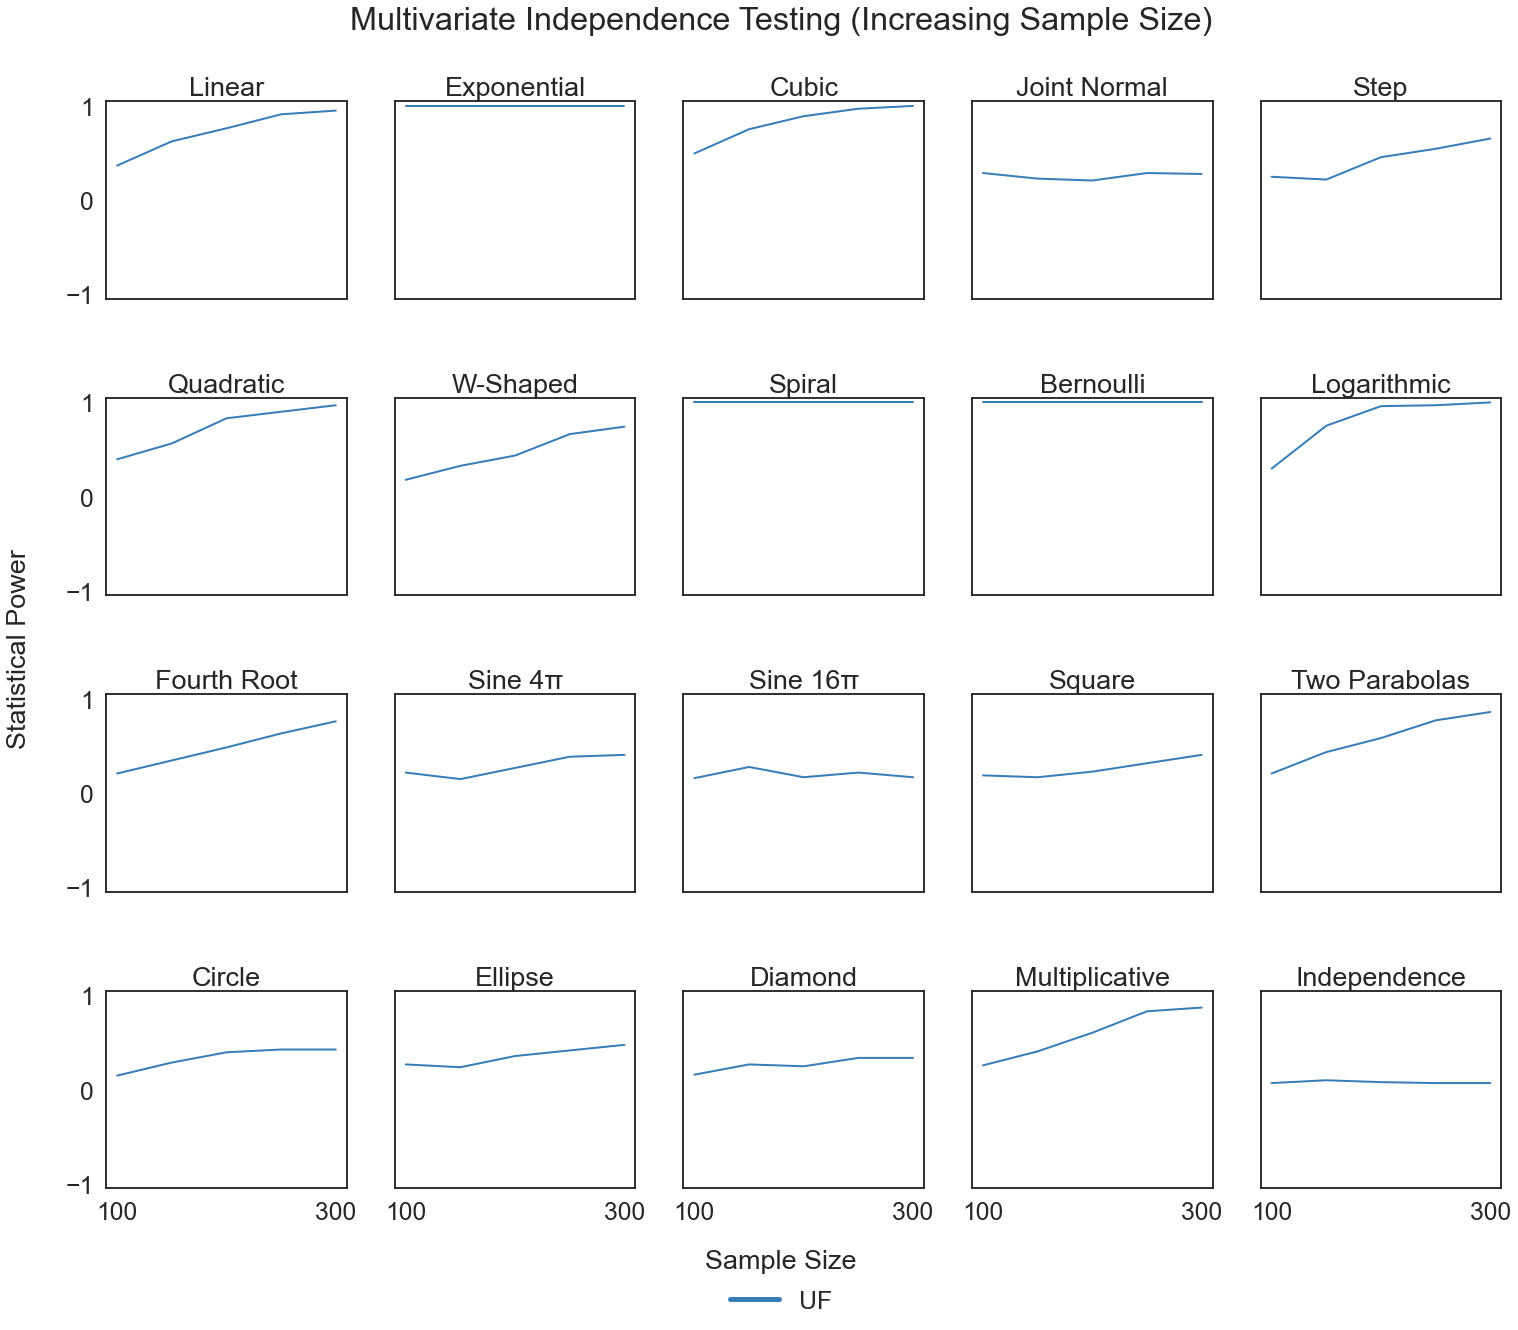

In [31]:
plot_power()